<a href="https://colab.research.google.com/github/Doktor-Hu/Data-Science-Assignment/blob/main/20231108_Data_Science_Assignment_HZ_for_BOL_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Assignment - Team Forecasting

**Author:** Zhongyang Hu (zhongyang.hu.rs@gmail.com)

<p align="left">
    <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average" title="ARIMA"><img src="https://img.shields.io/badge/Model-ARIMA-blue"></a>
		<a href="https://en.wikipedia.org/wiki/XGBoost" title="XGBoost"><img src="https://img.shields.io/badge/Model-XGBoost-blue"></a>
</p>

<br>

---

Introduction: This Jupyter Notebook is for the `Data Science Assignment - Team Forecasting` project. The aim is to create forecasts for the upcoming 12 weeks (not included in the dataset) for all 4 levels. The datasets used are
- The file `sales_data.csv` with 4 time series of sales at (total, retailer_type_1, retailer_type_2 and retailer_type_3).
- [Brent Crude Oil Futures](https://en.wikipedia.org/wiki/Brent_Crude)
- [COVID-19: Stringency Index](https://ourworldindata.org/explorers/coronavirus-data-explorer?uniformYAxis=0&hideControls=true&Interval=7-day+rolling+average&Relative+to+Population=true&Color+by+test+positivity=false&country=USA~ITA~CAN~DEU~GBR~FRA&Metric=Stringency+index)

The experimented models are:
- ARIMA (a classic statistical model for time-series as a baseline model), and
- XGBoost (a prevalently used machine learning model)

After experiments and validation, I decided to use the XGBoost model for the final forecast.

More overviews can be viewed by clicking the > below.

---

<br>

### Notebook Environments

_Developed originally using Google CoLab._

<br>

### Notebook Structure

<details><summary>click here to check details</summary>


Part I: Preparation and Data Exploration

- Section 1: Prepare Environment and Setups

- Section 2: Basic Overview of the Dataframe

- Section 3: Training/Validation/Testing Dataset Split

- Section 4: Time-Series Analysis

Part II: Modelling and Validation

- Section 5: Baseline Model: ARIMA

- Section 6: XGBoost Model: Experiments

Part III: Forecasting

- Section 7: Model Selection and Final Forecasting

</details>

<br>

### Key Take-away Messages

<details><summary>click here to check details</summary>

- ARIMA models tend to converge towards a constant, leading to a reduced ability to capture variations effectively.

- Underfitting is observed in XGBoost, and its behavior varies between single-point prediction and recurrent forecasting.

- A noticeable distribution shift has been identified across the training, validation, and testing datasets, resulting in a conceptual shift within the model.

- The presence of anomalies in `retailer_type_3` during the year 2020 adds complexity to the forecasting task, warranting heightened attention.

</details>

<br>

## Section 1. Prepare Environment and Setups



### 1.1. Setup PATH

In [3]:
PARENT_DIR_PATH = "/content/"
INPUT_FILENAME = "sales_data.csv"

### 1.2. import the dependent dictionary

If you are using Google CoLab

In [4]:
!pip install sktime
!pip install pmdarima

If you are using a local jupyter notebook, check the `requirements.txt` file, exported by the following code.

In [5]:
# Generate requirements file
# !pip freeze > requirements.txt
# from google.colab import files
# files.download('requirements.txt')

In [6]:
import os
import json
import scipy

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from sktime.forecasting.arima import AutoARIMA
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

## Section 2. Basic Overview of the Dataframe

### 2.1. Load data and check dataframe

In [7]:
# Load the CSV file
data_file_path = os.path.join(PARENT_DIR_PATH, "DATA", INPUT_FILENAME)
df_raw = pd.read_csv(data_file_path)

# Convert the 'report_date' column to a datetime format and set it as the index
df_raw["report_date"] = pd.to_datetime(df_raw["report_date"])
df_raw.set_index("report_date", inplace=True)

# Quick overview of the data
print("Quick overview of the data:")
print("=" * 79)
print(f"Shape of the DataFrame: {df_raw.shape}")
print(f"Columns: {', '.join(df_raw.columns)}")
print(f"Time range from {df_raw.index.min()} to {df_raw.index.max()}")
print("-" * 79)

# Data basic statistics
print("Data basic statistics:")
print(df_raw.describe())
print("-" * 79)

# Data information
print("Data information:")
df_raw.info()
print("-" * 79)

# Preview of the data
print("Preview of the data:")
print(df_raw.head())

Quick overview of the data:
Shape of the DataFrame: (192, 4)
Columns: total, retailer_type_1, retailer_type_2, retailer_type_3
Time range from 2017-01-02 00:00:00 to 2020-08-31 00:00:00
-------------------------------------------------------------------------------
Data basic statistics:
            total  retailer_type_1  retailer_type_2  retailer_type_3
count  192.000000       192.000000       192.000000       192.000000
mean     0.264334         0.116175         0.051026         0.097133
std      0.209690         0.089400         0.043742         0.089767
min     -0.007649        -0.004396        -0.001176        -0.002077
25%      0.096784         0.055152         0.015056         0.028821
50%      0.209324         0.100932         0.036262         0.067783
75%      0.368477         0.151541         0.071858         0.126337
max      1.003464         0.504809         0.228092         0.361196
-------------------------------------------------------------------------------
Data infor

### 2.2. Preview of the data

#### 2.2.1. Overall pattern

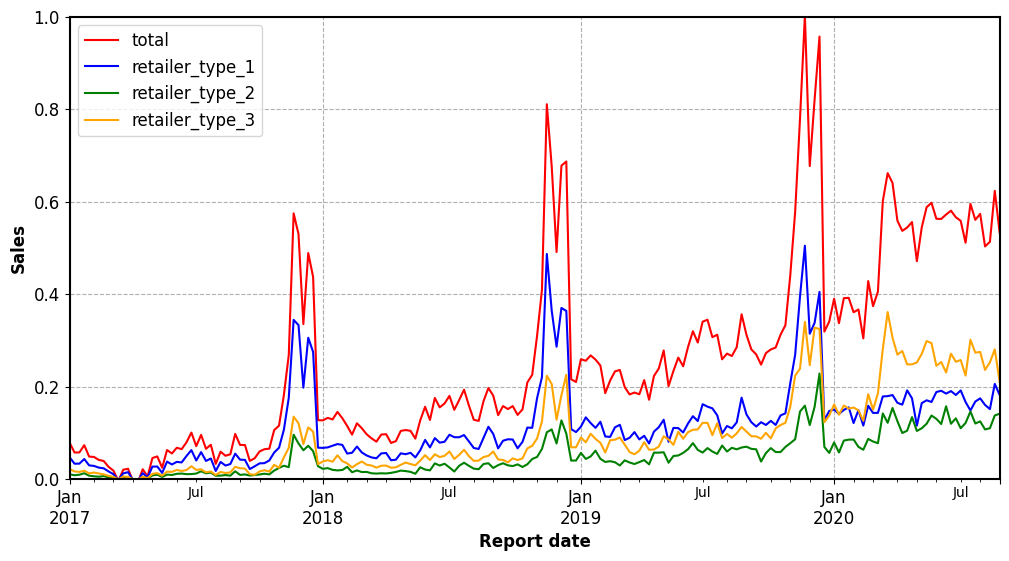

In [8]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

# Plot the data with specific colors
colors = ["red", "blue", "green", "orange"]
df_raw.plot(ax=ax, color=colors)

# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel("Sales", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(0, 1)

# Add a legend
ax.legend(df_raw.columns, loc="upper left", fontsize=12)

# Display the plot
plt.show()

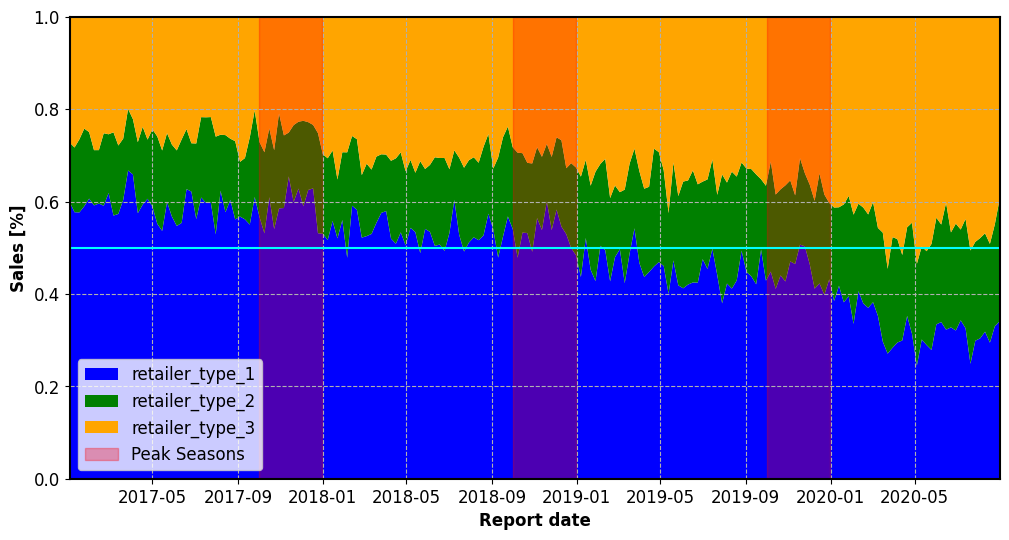

In [9]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

plt.stackplot(
    df_raw.index,
    df_raw["retailer_type_1"].divide(df_raw["total"]),
    df_raw["retailer_type_2"].divide(df_raw["total"]),
    df_raw["retailer_type_3"].divide(df_raw["total"]),
    labels=["retailer_type_1", "retailer_type_2", "retailer_type_3"],
    colors=["blue", "green", "orange"],
)

plt.axhline(y=0.5, color="cyan", linestyle="-")

ax.add_patch(
    Rectangle(
        (pd.Timestamp(f"2017-10-01"), 0),
        np.timedelta64(3, "M"),
        1,
        color="red",
        alpha=0.3,
        label="Peak Seasons",
    )
)

for year in range(2018, 2020):
    ax.add_patch(
        Rectangle(
            (pd.Timestamp(f"{year}-10-01"), 0),
            np.timedelta64(3, "M"),
            1,
            color="red",
            alpha=0.3,
        )
    )

# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel("Sales [%]", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(0, 1)
ax.set_xlim(df_raw.index[0], df_raw.index[-1])

# Add a legend
ax.legend(loc="lower left", fontsize=12)

# Display the plot
plt.show()

#### 2.2.2. Intra-annual comparison

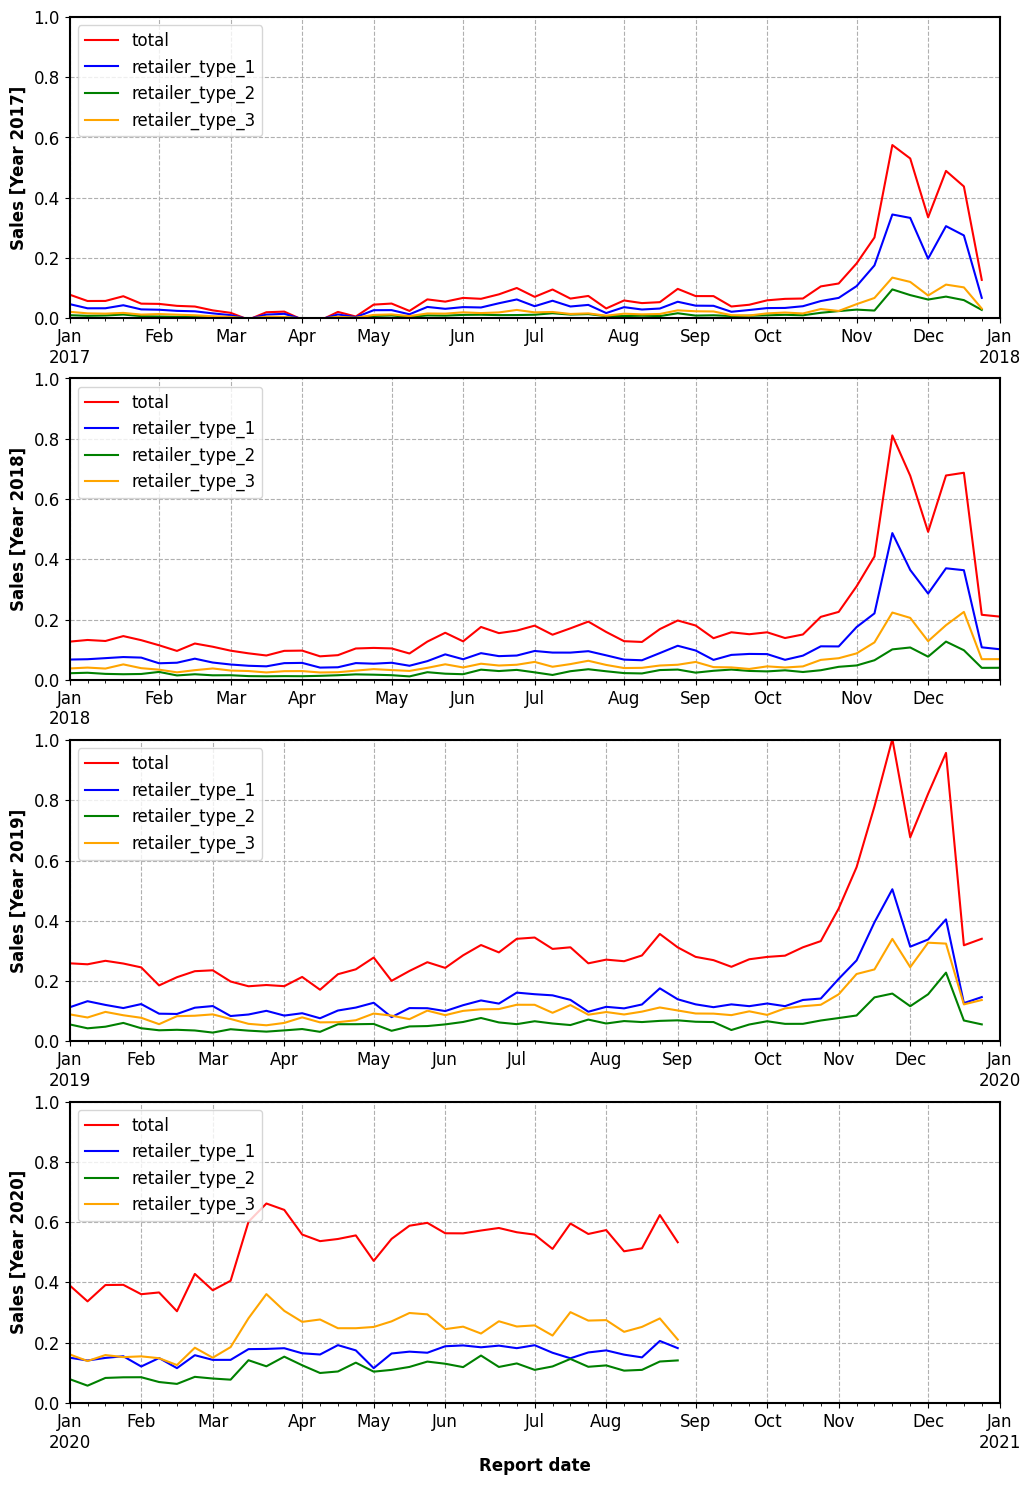

In [10]:
# Intra-annual comparison
years = range(2017, 2021)
fig, axes = plt.subplots(figsize=(12, 18), nrows=4, sharex=False)
plt.subplots_adjust(hspace=0.2)

for k, year in enumerate(years, 1):
    # Filter data for the current year
    df_year_raw = df_raw[df_raw.index.year == year]

    # Set spines' linewidth for each axis
    for axis in ["top", "bottom", "left", "right"]:
        axes[k - 1].spines[axis].set_linewidth(1.5)

    # Plot data and customize axes
    df_year_raw.plot(ax=axes[k - 1], color=["red", "blue", "green", "orange"])
    axes[k - 1].set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
    axes[k - 1].set_ylim(0, 1)

    if k < 4:
        axes[k - 1].set_xlabel("")
    else:
        axes[k - 1].set_xlabel("Report date", fontsize=12, fontweight="bold")

    axes[k - 1].set_ylabel(f"Sales [Year {year}]", fontsize=12, fontweight="bold")
    axes[k - 1].tick_params(axis="x", labelsize=12)
    axes[k - 1].tick_params(axis="y", labelsize=12)

    axes[k - 1].legend(loc="upper left", fontsize=12)
    axes[k - 1].grid(linestyle="--")

plt.show()

#### 2.2.3. Inter-annual comparison

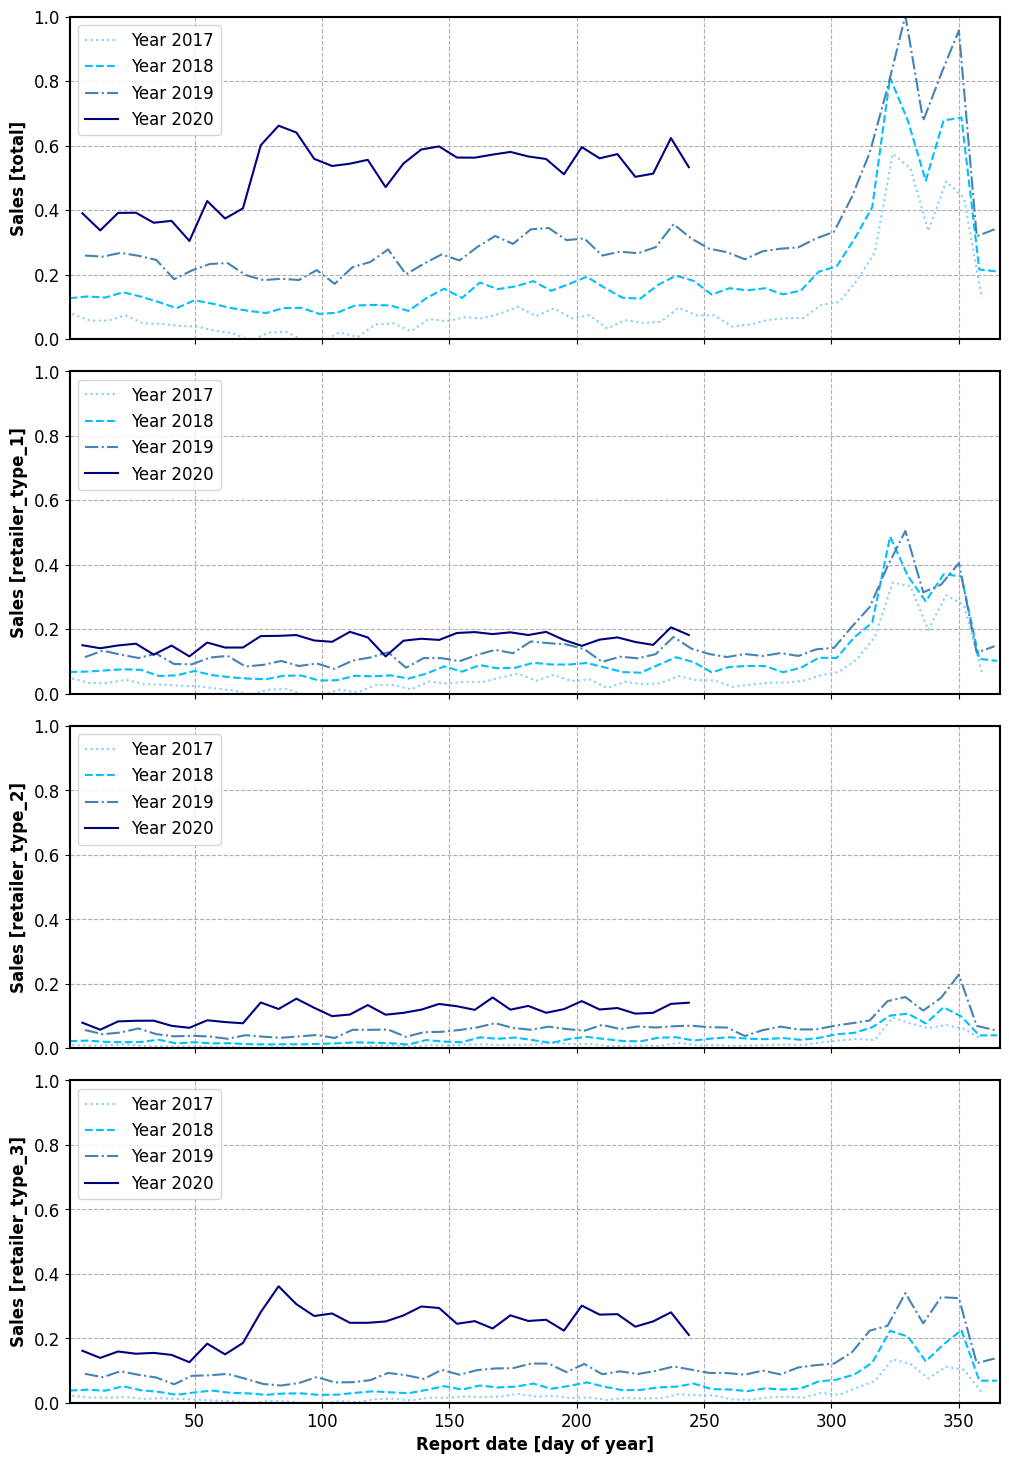

In [11]:
# Inter-annual comparison
# Define years and retailer types
years = [2017, 2018, 2019, 2020]
retailer_types = df_raw.columns

# Create subplots
fig, axes = plt.subplots(
    nrows=len(retailer_types), ncols=1, figsize=(12, 18), sharex=True
)
plt.subplots_adjust(hspace=0.1)


for k, retailer_type in enumerate(retailer_types):
    # Set spines' linewidth for each axis
    for axis in ["top", "bottom", "left", "right"]:
        axes[k].spines[axis].set_linewidth(1.5)

    # Plot data for each year using isocalendar().week
    colors = ["lightskyblue", "deepskyblue", "steelblue", "navy"]
    linestyles = ["dotted", "dashed", "dashdot", "solid"]
    for year_idx, year in enumerate(years):
        year_data = df_raw[df_raw.index.year == year]
        axes[k].plot(
            year_data.index.dayofyear,
            year_data[retailer_type],
            label=f"Year {year}",
            color=colors[year_idx],
            linestyle=linestyles[year_idx],
        )

    # Customize axes
    axes[k].set_ylim(0, 1)
    if k < len(retailer_types) - 1:
        axes[k].set_xlabel("")
    else:
        axes[k].set_xlabel("Report date [day of year]", fontsize=12, fontweight="bold")
    axes[k].set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
    axes[k].set_xlim(1, 366)
    axes[k].tick_params(axis="x", labelsize=12)
    axes[k].tick_params(axis="y", labelsize=12)
    axes[k].legend(loc="upper left", fontsize=12)
    axes[k].grid(linestyle="--")

plt.show()

## Section 3. Training/Validation/Testing Dataset Split

> In the previous session, we observed anomalies in `retailer_type_3` during the spring of 2020. Consequently, as we split the training (train), validation (val), and testing datasets, it is advisable to take these anomalies into consideration.

### 3.1. normal split

> Notice: The split date may shift when lag terms are incorporated into the models.

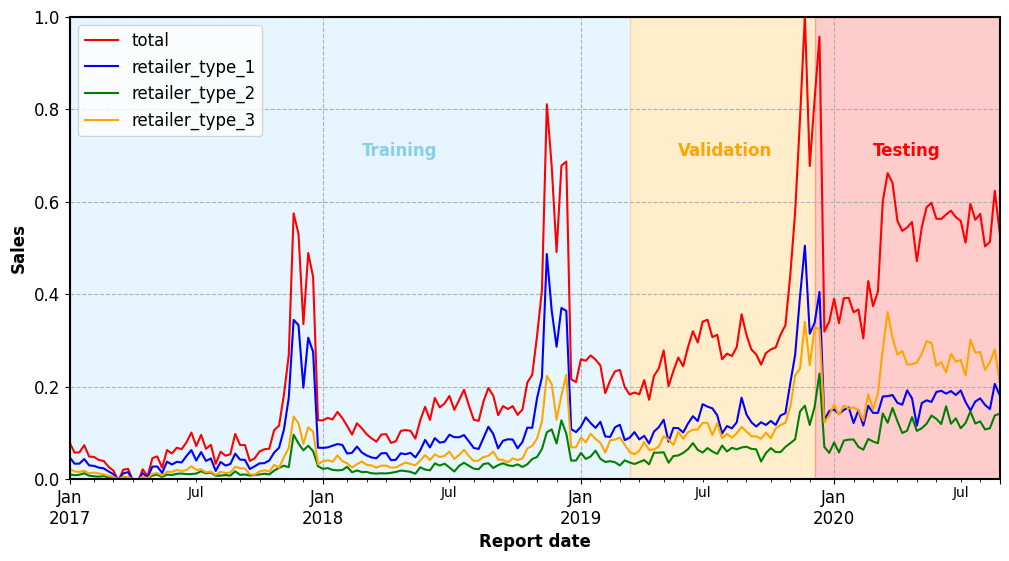

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

df_raw.plot(ax=ax, color=["red", "blue", "green", "orange"])
plt.xlabel("Report date", fontsize=12, fontweight="bold")
plt.ylabel("Sales", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle="--")

plt.ylim(0, 1)

ax.add_patch(
    Rectangle(
        (df_raw.index[0], 0),
        np.timedelta64(round(192 * 0.6), "W"),
        1,
        color="lightskyblue",
        alpha=0.2,
    )
)
ax.add_patch(
    Rectangle(
        (df_raw.index[0] + np.timedelta64(round(192 * 0.6), "W"), 0),
        np.timedelta64(round(192 * 0.2), "W"),
        1,
        color="orange",
        alpha=0.2,
    )
)
ax.add_patch(
    Rectangle(
        (
            df_raw.index[0]
            + np.timedelta64(round(192 * 0.6), "W")
            + np.timedelta64(round(192 * 0.2), "W"),
            0,
        ),
        np.timedelta64(round(192 * 0.2), "W"),
        1,
        color="red",
        alpha=0.2,
    )
)

plt.text(
    df_raw.index[60], 0.7, "Training", fontsize=12, fontweight="bold", color="skyblue"
)
plt.text(
    df_raw.index[125], 0.7, "Validation", fontsize=12, fontweight="bold", color="orange"
)
plt.text(df_raw.index[165], 0.7, "Testing", fontsize=12, fontweight="bold", color="red")


plt.legend(loc="upper left", fontsize=12)

plt.show()

### 3.2. shifted split

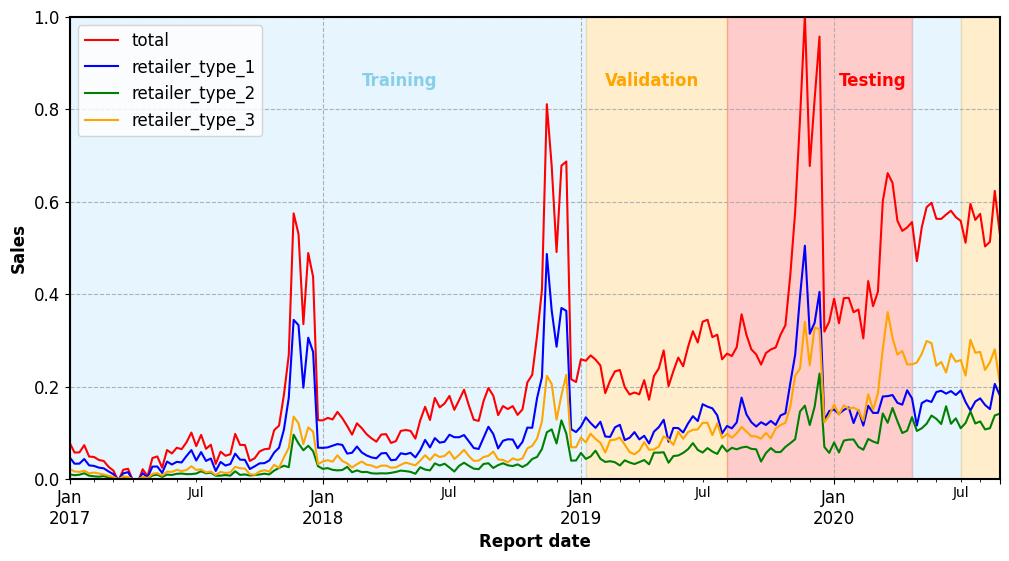

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

df_raw.plot(ax=ax, color=["red", "blue", "green", "orange"])
plt.xlabel("Report date", fontsize=12, fontweight="bold")
plt.ylabel("Sales", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle="--")

plt.ylim(0, 1)

ax.add_patch(
    Rectangle(
        (df_raw.index[0], 0),
        np.timedelta64(106, "W"),
        1,
        color="lightskyblue",
        alpha=0.2,
    )
)
ax.add_patch(
    Rectangle(
        (df_raw.index[0] + np.timedelta64(106, "W"), 0),
        np.timedelta64(29, "W"),
        1,
        color="orange",
        alpha=0.2,
    )
)
ax.add_patch(
    Rectangle(
        (df_raw.index[0] + np.timedelta64(135, "W"), 0),
        np.timedelta64(38, "W"),
        1,
        color="red",
        alpha=0.2,
    )
)
ax.add_patch(
    Rectangle(
        (df_raw.index[0] + np.timedelta64(173, "W"), 0),
        np.timedelta64(10, "W"),
        1,
        color="lightskyblue",
        alpha=0.2,
    )
)
ax.add_patch(
    Rectangle(
        (df_raw.index[0] + np.timedelta64(183, "W"), 0),
        np.timedelta64(9, "W"),
        1,
        color="orange",
        alpha=0.2,
    )
)

plt.text(
    df_raw.index[60], 0.85, "Training", fontsize=12, fontweight="bold", color="skyblue"
)
plt.text(
    df_raw.index[110],
    0.85,
    "Validation",
    fontsize=12,
    fontweight="bold",
    color="orange",
)
plt.text(
    df_raw.index[158], 0.85, "Testing", fontsize=12, fontweight="bold", color="red"
)


plt.legend(loc="upper left", fontsize=12)

plt.show()

In [14]:
def dataset_split(df_in, sampling_rate, split_manner="traditional"):
    total_samples = df_in.shape[0]
    sizes = [round(total_samples * sr) for sr in sampling_rate]

    # Adjust sizes to ensure the sum is exactly equal to the total
    diff = total_samples - sum(sizes)

    # Distribute the remaining samples
    sizes[0] += diff

    if split_manner == "traditional":
        train_size, val_size, test_size = sizes

        train = df_in.iloc[:train_size, :]
        val = df_in.iloc[train_size : (train_size + val_size), :]
        test = df_in.iloc[(train_size + val_size) :, :]

        return train, val, test

    elif split_manner == "intersect":
        train_size_1, val_size_1, test_size, train_size_2, val_size_2 = sizes

        train_1 = df_in.iloc[:train_size_1, :]
        val_1 = df_in.iloc[train_size_1 : (train_size_1 + val_size_1), :]
        test = df_in.iloc[
            (train_size_1 + val_size_1) : (train_size_1 + val_size_1 + test_size), :
        ]
        train_2 = df_in.iloc[
            (train_size_1 + val_size_1 + test_size) : (
                train_size_1 + val_size_1 + test_size + train_size_2
            ),
            :,
        ]
        val_2 = df_in.iloc[(train_size_1 + val_size_1 + test_size + train_size_2) :, :]

        train = pd.concat([train_1, train_2])
        val = pd.concat([val_1, val_2])

        return train, val, test, val_1

    else:
        raise ValueError(f"Unknow split manner {split_manner}")

## Section 4. Time-Series Analysis

### 4.1. Trend and Seasonality

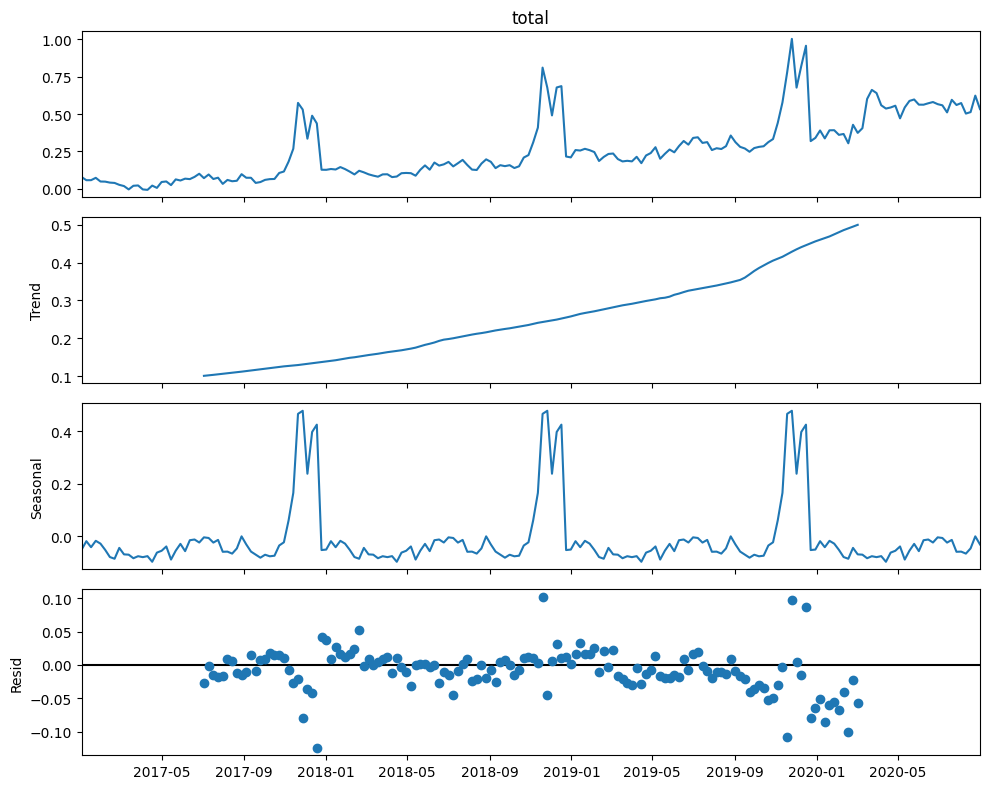

In [15]:
plt.rc("figure", figsize=(10, 8))
ts_total_decompose = sm.tsa.seasonal_decompose(df_raw["total"])
ts_total_plot = ts_total_decompose.plot()
plt.tight_layout()
plt.show()

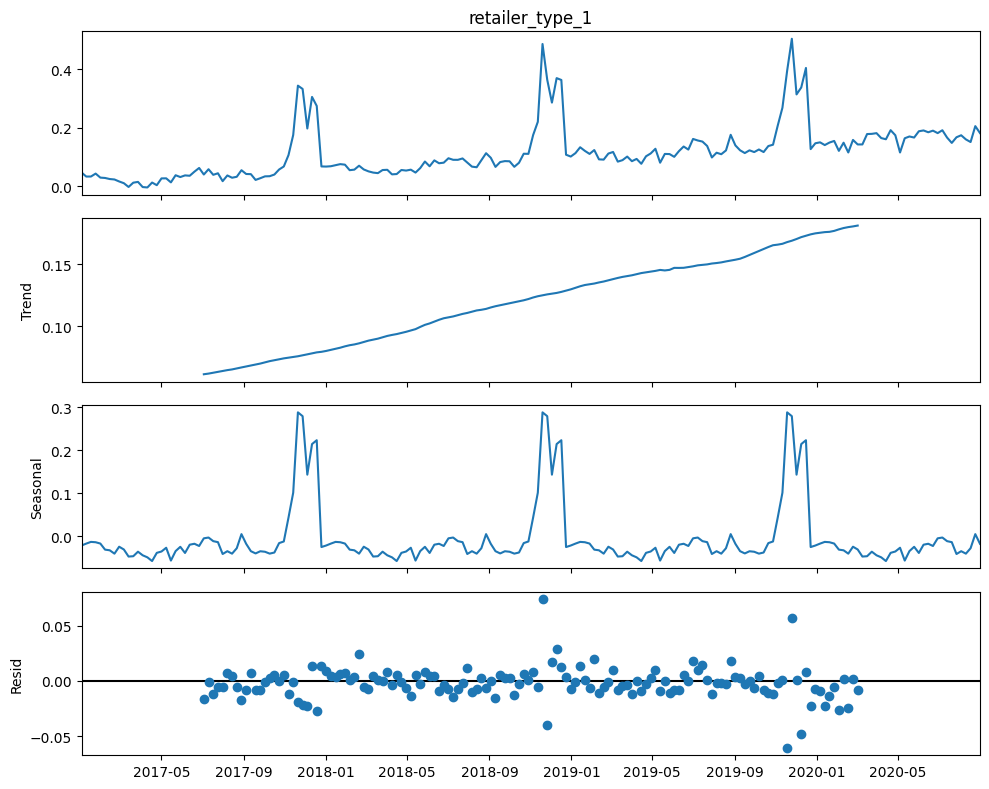

In [16]:
plt.rc("figure", figsize=(10, 8))
ts_rt1_decompose = sm.tsa.seasonal_decompose(df_raw["retailer_type_1"])
ts_rt1_plot = ts_rt1_decompose.plot()
plt.tight_layout()
plt.show()

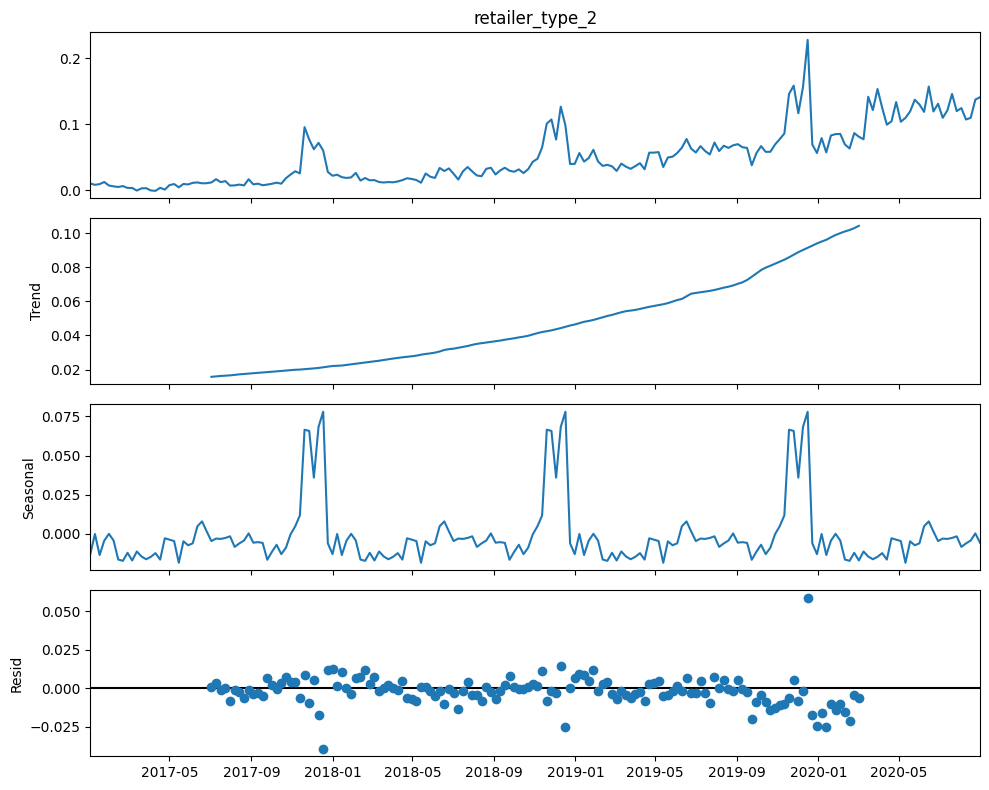

In [17]:
plt.rc("figure", figsize=(10, 8))
ts_rt2_decompose = sm.tsa.seasonal_decompose(df_raw["retailer_type_2"])
ts_rt2_plot = ts_rt2_decompose.plot()
plt.tight_layout()
plt.show()

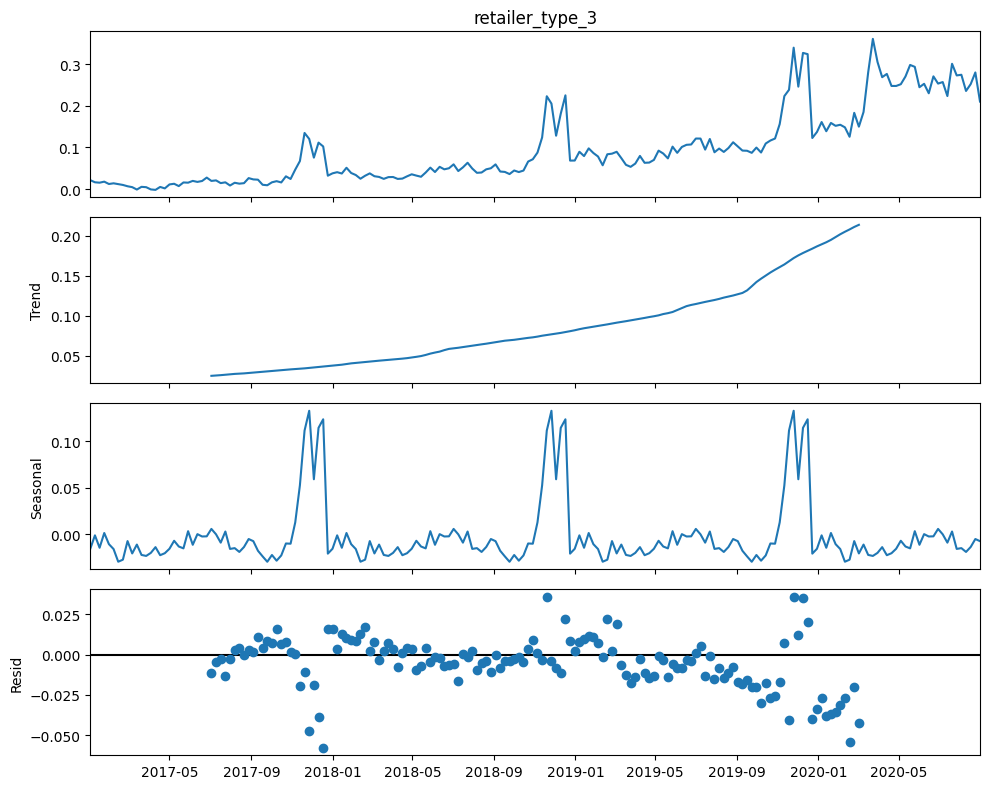

In [18]:
plt.rc("figure", figsize=(10, 8))
ts_rt3_decompose = sm.tsa.seasonal_decompose(df_raw["retailer_type_3"])
ts_rt3_plot = ts_rt3_decompose.plot()
plt.tight_layout()
plt.show()

### 4.2. Data Split

In [19]:
train_arima, _, test_arima = dataset_split(df_raw, (0.8, 0, 0.2))
train_arima.index.freq = "7D"
test_arima.index.freq = "7D"

### 4.3. Stationarity (d)

In [20]:
def check_stationarity_stat(df_in):
    stationarity_check = pd.DataFrame(
        columns=["total", "retailer_type_1", "retailer_type_2", "retailer_type_3"],
        index=["lag_0", "lag_1"],
    )

    for retailer in ["total", "retailer_type_1", "retailer_type_2", "retailer_type_3"]:
        for lag in range(2):
            if lag == 0:
                stationarity_check.at[f"lag_{lag}", retailer] = adfuller(
                    df_in[retailer]
                )[1]
            else:
                diff = (df_in[retailer] - df_in[retailer].shift(lag))[lag:]
                stationarity_check.at[f"lag_{lag}", retailer] = adfuller(diff)[1]

    return stationarity_check.style.applymap(
        lambda x: "color: green" if x < 0.01 else "color: red"
    )

In [21]:
print("Entire Dataset")
check_stationarity_stat(df_raw)

Entire Dataset


In [22]:
print("Training Dataset")
check_stationarity_stat(train_arima)

Training Dataset


In [23]:
print("Testing Dataset")
check_stationarity_stat(test_arima)

Testing Dataset


> According to the augmented Dickey-Fuller test, `d=1` for all the retailer type in the corresponding ARIMA model

### 4.4. Autocorrelation (p) and Partial Autocorrelation (q)

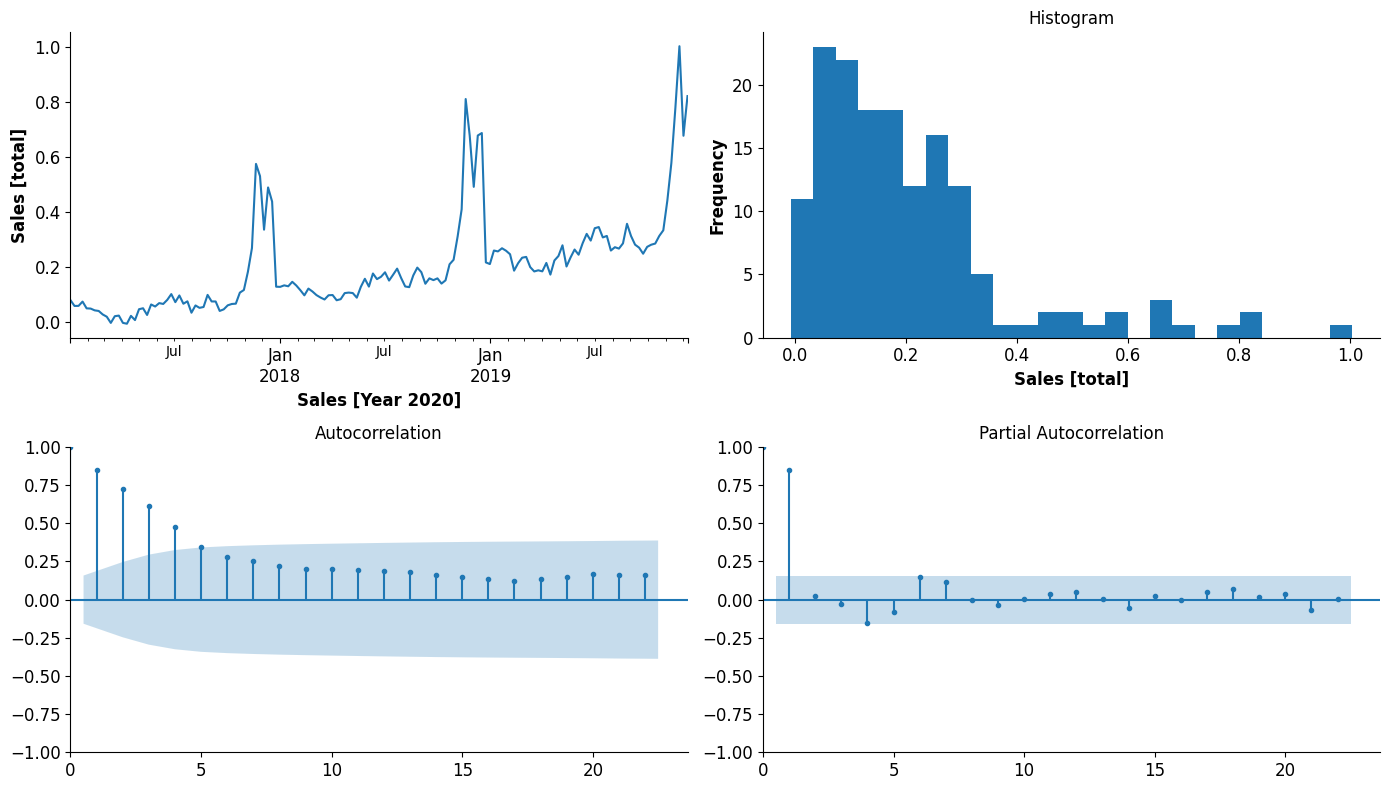

In [24]:
retailer_type = "total"

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout()

ts_ax, hist_ax, acf_ax, pacf_ax = axes.ravel()

train_arima[retailer_type].plot(ax=ts_ax)
ts_ax.set_xlabel(f"Sales [Year {year}]", fontsize=12, fontweight="bold")
ts_ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
[ax.tick_params(axis="x", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]
[ax.tick_params(axis="y", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]


train_arima[retailer_type].plot(ax=hist_ax, kind="hist", bins=25)
hist_ax.set_title("Histogram")
hist_ax.set_ylabel(f"Frequency", fontsize=12, fontweight="bold")
hist_ax.set_xlabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")

sm.graphics.tsa.plot_acf(train_arima[retailer_type], ax=acf_ax, markersize=3)
sm.graphics.tsa.plot_pacf(train_arima[retailer_type], ax=pacf_ax, markersize=3)
[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]

sns.despine()
fig.tight_layout()

plt.show()

> According to the autocorrelation plot and partial autocorrelation plot, `p = 6` and `q = 1` should be set for the ARIMA model for the `retailer_type_total`.

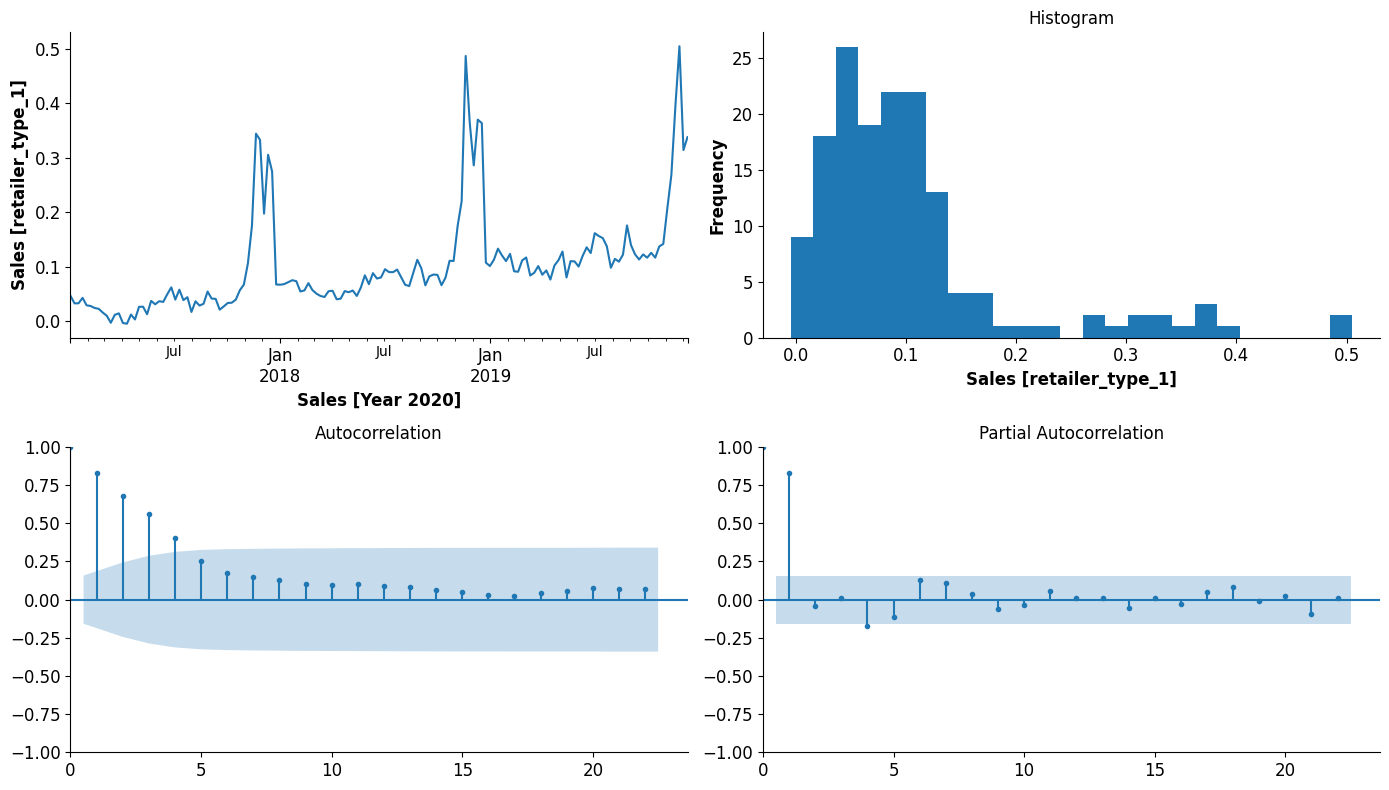

In [25]:
retailer_type = "retailer_type_1"

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout()

ts_ax, hist_ax, acf_ax, pacf_ax = axes.ravel()

train_arima[retailer_type].plot(ax=ts_ax)
ts_ax.set_xlabel(f"Sales [Year {year}]", fontsize=12, fontweight="bold")
ts_ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
[ax.tick_params(axis="x", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]
[ax.tick_params(axis="y", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]


train_arima[retailer_type].plot(ax=hist_ax, kind="hist", bins=25)
hist_ax.set_title("Histogram")
hist_ax.set_ylabel(f"Frequency", fontsize=12, fontweight="bold")
hist_ax.set_xlabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")

sm.graphics.tsa.plot_acf(train_arima[retailer_type], ax=acf_ax, markersize=3)
sm.graphics.tsa.plot_pacf(train_arima[retailer_type], ax=pacf_ax, markersize=3)
[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]

sns.despine()
fig.tight_layout()

plt.show()

> According to the autocorrelation plot and partial autocorrelation plot, `p = 5` and `q = 1` should be set for the ARIMA model for the `retailer_type_1`.

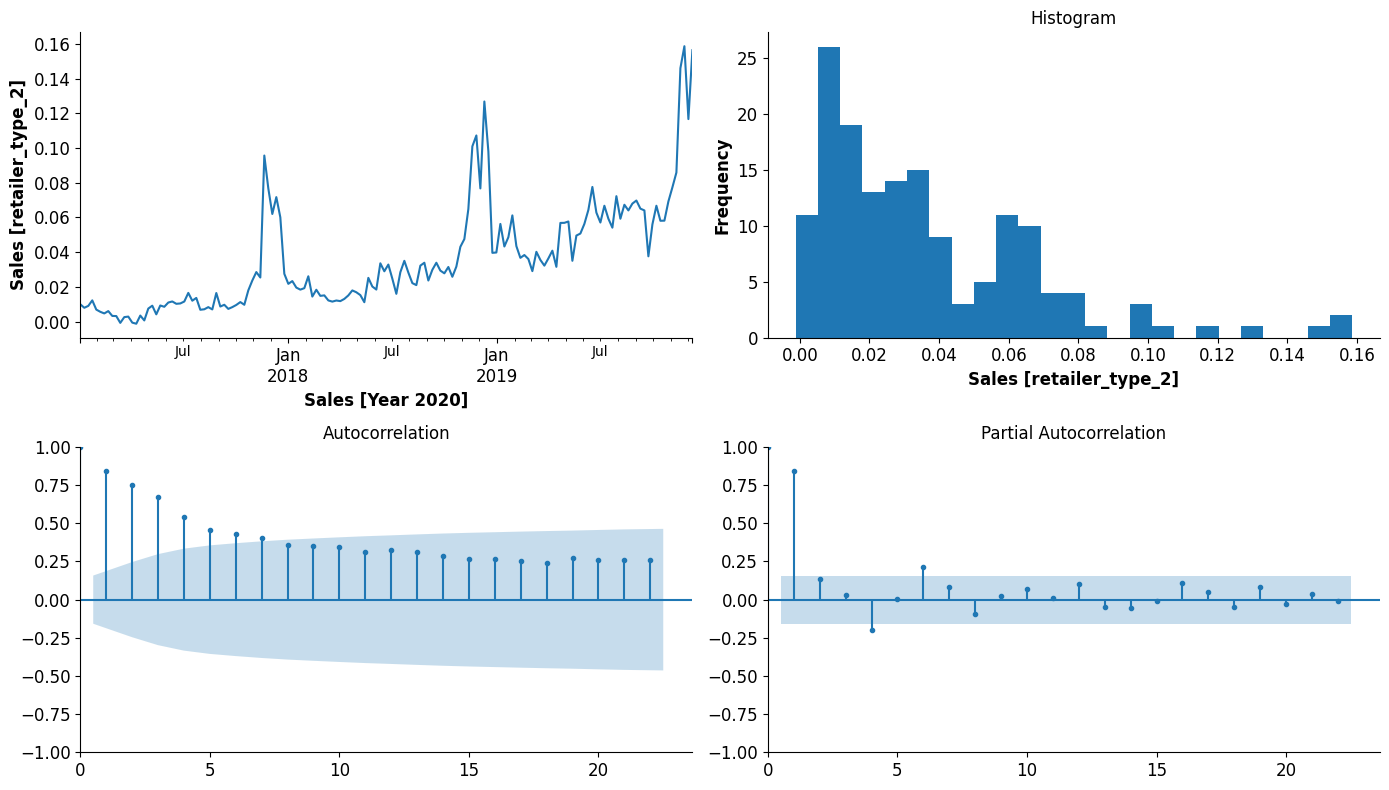

In [26]:
retailer_type = "retailer_type_2"

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout()

ts_ax, hist_ax, acf_ax, pacf_ax = axes.ravel()

train_arima[retailer_type].plot(ax=ts_ax)
ts_ax.set_xlabel(f"Sales [Year {year}]", fontsize=12, fontweight="bold")
ts_ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
[ax.tick_params(axis="x", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]
[ax.tick_params(axis="y", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]


train_arima[retailer_type].plot(ax=hist_ax, kind="hist", bins=25)
hist_ax.set_title("Histogram")
hist_ax.set_ylabel(f"Frequency", fontsize=12, fontweight="bold")
hist_ax.set_xlabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")

sm.graphics.tsa.plot_acf(train_arima[retailer_type], ax=acf_ax, markersize=3)
sm.graphics.tsa.plot_pacf(train_arima[retailer_type], ax=pacf_ax, markersize=3)
[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]

sns.despine()
fig.tight_layout()

plt.show()

> According to the autocorrelation plot and partial autocorrelation plot, `p = 8` and `q = 1` should be set for the ARIMA model for the `retailer_type_2`.

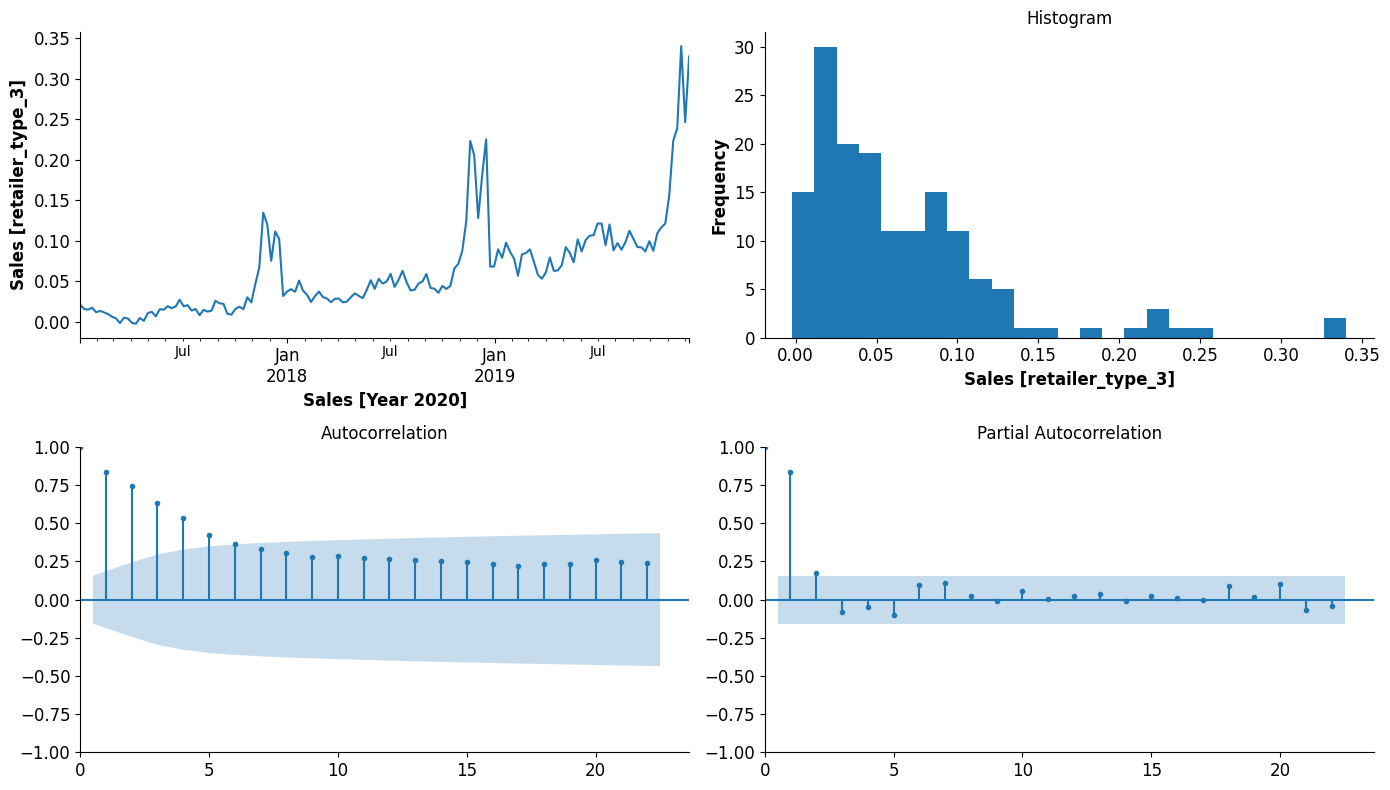

In [27]:
retailer_type = "retailer_type_3"

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.tight_layout()

ts_ax, hist_ax, acf_ax, pacf_ax = axes.ravel()

train_arima[retailer_type].plot(ax=ts_ax)
ts_ax.set_xlabel(f"Sales [Year {year}]", fontsize=12, fontweight="bold")
ts_ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
[ax.tick_params(axis="x", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]
[ax.tick_params(axis="y", labelsize=12) for ax in [ts_ax, hist_ax, acf_ax, pacf_ax]]


train_arima[retailer_type].plot(ax=hist_ax, kind="hist", bins=25)
hist_ax.set_title("Histogram")
hist_ax.set_ylabel(f"Frequency", fontsize=12, fontweight="bold")
hist_ax.set_xlabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")

sm.graphics.tsa.plot_acf(train_arima[retailer_type], ax=acf_ax, markersize=3)
sm.graphics.tsa.plot_pacf(train_arima[retailer_type], ax=pacf_ax, markersize=3)
[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]

sns.despine()
fig.tight_layout()

plt.show()

> According to the autocorrelation plot and partial autocorrelation plot, `p = 7` and `q = 1` should be set for the ARIMA model for the `retailer_type_3`.

## Section 5: Baseline Model: ARIMA

In [28]:
#  Evaluation Metrics
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)


def r_squared(actual, predicted):
    _, _, r_value, _, _ = scipy.stats.linregress(actual, predicted)
    return r_value**2


def mae(actual, predicted):
    return mean_absolute_error(actual, predicted)

### 5.1. ARIMA for retailer type `total` (6, 1, 1)

In [29]:
retailer_type = "total"
sarima_total = sm.tsa.statespace.SARIMAX(train_arima["total"], order=(6, 1, 1)).fit()
sarima_total_forecast = sarima_total.forecast(test_arima.shape[0])

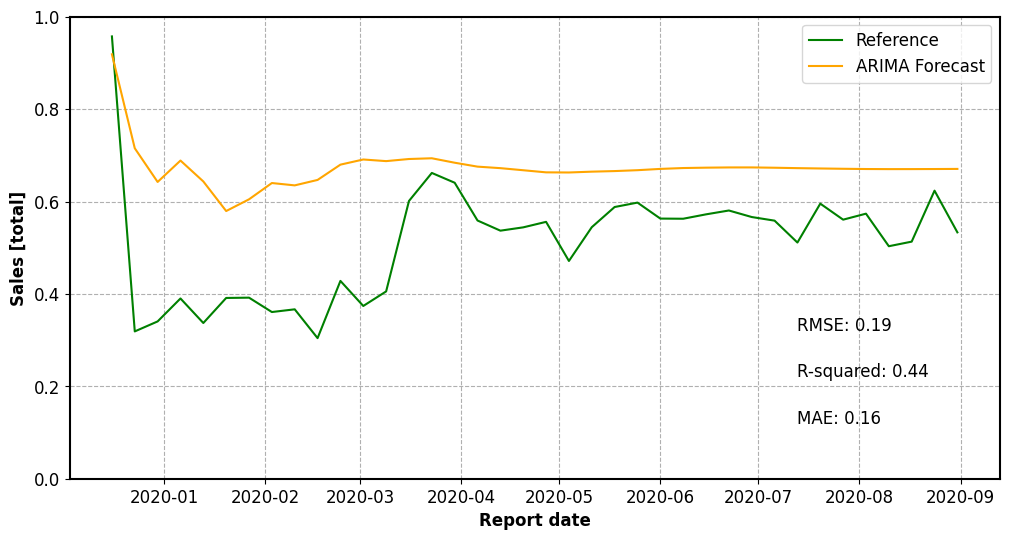

In [30]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

# Plot the data with specific colors
plt.plot(test_arima[retailer_type], label="Reference", color="green")
plt.plot(sarima_total_forecast, label="ARIMA Forecast", color="orange")

stat_rmse = "%.2f" % rmse(test_arima[retailer_type], sarima_total_forecast)
stat_r2 = "%.2f" % r_squared(test_arima[retailer_type], sarima_total_forecast)
stat_mae = "%.2f" % mae(test_arima[retailer_type], sarima_total_forecast)

plt.text(sarima_total_forecast.index[-8], 0.32, f"RMSE: {stat_rmse}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.22, f"R-squared: {stat_r2}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.12, f"MAE: {stat_mae}", fontsize=12)

# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(0, 1)

# Add a legend
ax.legend(loc="upper right", fontsize=12)

# Display the plot
plt.show()

### 5.2. ARIMA for `retailer type 1` (5, 1, 1)

In [31]:
retailer_type = "retailer_type_1"
sarima_rt1 = sm.tsa.statespace.SARIMAX(
    train_arima[retailer_type], order=(5, 1, 1)
).fit(maxiter=1000)
sarima_rt1_forecast = sarima_rt1.forecast(test_arima.shape[0])

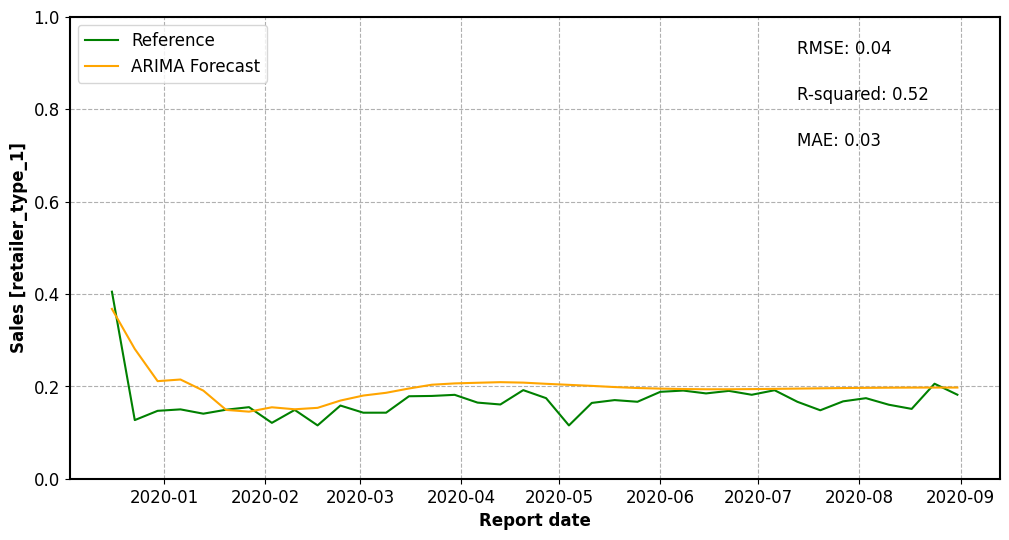

In [32]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

# Plot the data with specific colors
plt.plot(test_arima[retailer_type], label="Reference", color="green")
plt.plot(sarima_rt1_forecast, label="ARIMA Forecast", color="orange")

stat_rmse = "%.2f" % rmse(test_arima[retailer_type], sarima_rt1_forecast)
stat_r2 = "%.2f" % r_squared(test_arima[retailer_type], sarima_rt1_forecast)
stat_mae = "%.2f" % mae(test_arima[retailer_type], sarima_rt1_forecast)

plt.text(sarima_total_forecast.index[-8], 0.92, f"RMSE: {stat_rmse}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.82, f"R-squared: {stat_r2}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.72, f"MAE: {stat_mae}", fontsize=12)

# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(0, 1)

# Add a legend
ax.legend(loc="upper left", fontsize=12)

# Display the plot
plt.show()

### 5.3. ARIMA for `retailer type 2` (8, 1, 1)

In [33]:
retailer_type = "retailer_type_2"
sarima_rt2 = sm.tsa.statespace.SARIMAX(
    train_arima[retailer_type], order=(8, 1, 1)
).fit()
sarima_rt2_forecast = sarima_rt2.forecast(test_arima.shape[0])

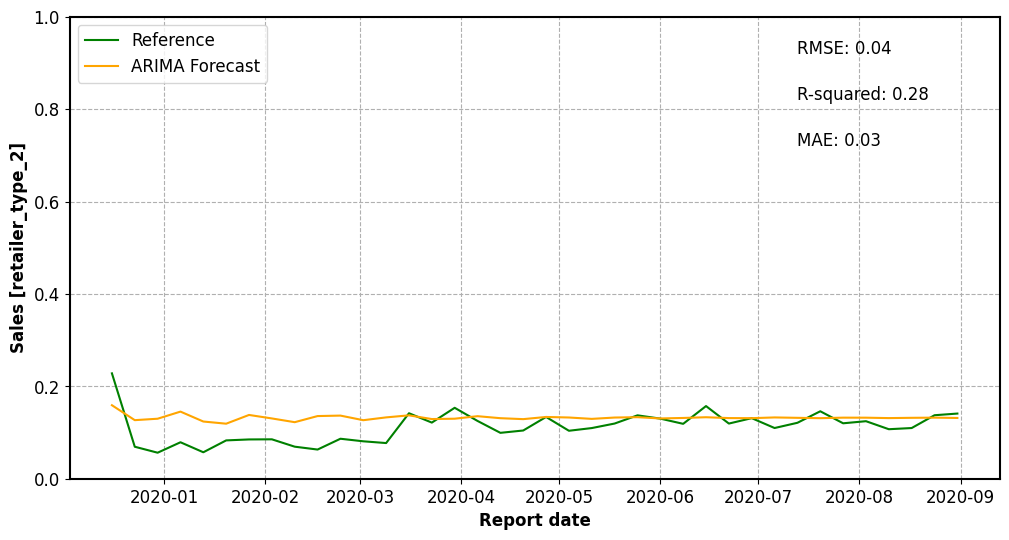

In [34]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

# Plot the data with specific colors
plt.plot(test_arima[retailer_type], label="Reference", color="green")
plt.plot(sarima_rt2_forecast, label="ARIMA Forecast", color="orange")

stat_rmse = "%.2f" % rmse(test_arima[retailer_type], sarima_rt2_forecast)
stat_r2 = "%.2f" % r_squared(test_arima[retailer_type], sarima_rt2_forecast)
stat_mae = "%.2f" % mae(test_arima[retailer_type], sarima_rt2_forecast)

plt.text(sarima_total_forecast.index[-8], 0.92, f"RMSE: {stat_rmse}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.82, f"R-squared: {stat_r2}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.72, f"MAE: {stat_mae}", fontsize=12)

# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(0, 1)

# Add a legend
ax.legend(loc="upper left", fontsize=12)

# Display the plot
plt.show()

### 5.4. ARIMA for `retailer type 3` (7, 1, 1)

In [35]:
retailer_type = "retailer_type_3"
sarima_rt3 = sm.tsa.statespace.SARIMAX(
    train_arima[retailer_type], order=(7, 1, 1)
).fit(maxiter=1000)
sarima_rt3_forecast = sarima_rt3.forecast(test_arima.shape[0])

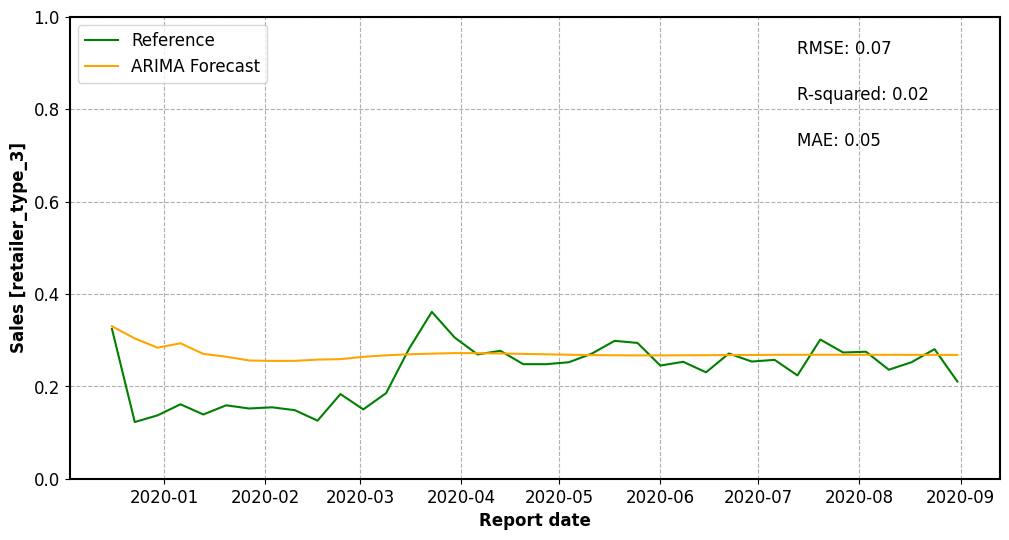

In [36]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

# Plot the data with specific colors
plt.plot(test_arima[retailer_type], label="Reference", color="green")
plt.plot(sarima_rt3_forecast, label="ARIMA Forecast", color="orange")

stat_rmse = "%.2f" % rmse(test_arima[retailer_type], sarima_rt3_forecast)
stat_r2 = "%.2f" % r_squared(test_arima[retailer_type], sarima_rt3_forecast)
stat_mae = "%.2f" % mae(test_arima[retailer_type], sarima_rt3_forecast)

plt.text(sarima_total_forecast.index[-8], 0.92, f"RMSE: {stat_rmse}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.82, f"R-squared: {stat_r2}", fontsize=12)
plt.text(sarima_total_forecast.index[-8], 0.72, f"MAE: {stat_mae}", fontsize=12)

# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Sales [{retailer_type}]", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(0, 1)

# Add a legend
ax.legend(loc="upper left", fontsize=12)

# Display the plot
plt.show()

## Section 6. XGBoost Model: Experiments


### 6.1. Training Framework

In [37]:
class XgbModel:
    def __init__(self, dmt_train, dmt_val, existing_model=None):
        self.dtrain = dmt_train
        self.dval = dmt_val
        self.existing_model = existing_model

    def single_xgb_train(self, param, model=None):
        result = {}
        xgb_reg_model = xgb.train(
            param,
            self.dtrain,
            early_stopping_rounds=10,
            num_boost_round=500,
            evals=[(self.dval, "validation"), (self.dtrain, "train")],
            evals_result=result,
            verbose_eval=False,
            xgb_model=model,
        )
        return xgb_reg_model, result

    def hyperparameter_tuning(self, space):
        params = {
            "max_depth": int(space["max_depth"]),
            "gamma": space["gamma"],
            "colsample_bytree": space["colsample_bytree"],
            "min_child_weight": space["min_child_weight"],
            "subsample": space["subsample"],
            "learning_rate": space["learning_rate"],
            "reg_alpha": space["reg_alpha"],
            "reg_lambda": space["reg_lambda"],
            "tree_method": "exact",
            "objective": "reg:squarederror",
        }

        model = xgb.train(
            params=params,
            dtrain=self.dtrain,
            early_stopping_rounds=10,
            num_boost_round=500,
            evals=[(self.dval, "validation"), (self.dtrain, "train")],
            verbose_eval=False,
            xgb_model=self.existing_model,
        )

        return {"loss": model.best_score, "status": STATUS_OK, "model": model}

In [38]:
def model_tuning(
    input_df, retailer_type, split_ratio=(0.6, 0.2, 0.2), custom_space=None, ex_data=[]
):
    df_single_retailer = input_df[
        [retailer_type]
        + ex_data
        + ["dayofyear", "dayofweek", "quarter", "year", "week"]
        + [f"lag_{lag}w_{retailer_type}" for lag in range(1, lags + 1)]
    ]

    if len(split_ratio) == 3:
        train_dataset, val_dataset, test_dataset = dataset_split(
            df_single_retailer, split_ratio
        )
    elif len(split_ratio) == 5:
        (
            train_dataset,
            val_dataset,
            test_dataset,
            val_dataset_first_part,
        ) = dataset_split(df_single_retailer, split_ratio, split_manner="intersect")
    else:
        raise ValueError("Unkonw split_ratio configuration")

    dmat_train = xgb.DMatrix(
        data=train_dataset.iloc[:, 1:], label=train_dataset.iloc[:, 0]
    )
    dmat_val = xgb.DMatrix(data=val_dataset.iloc[:, 1:], label=val_dataset.iloc[:, 0])

    xgb_model = XgbModel(dmat_train, dmat_val)

    if custom_space:
        check_space = len(
            set(custom_space.keys()).difference(
                [
                    "max_depth",
                    "gamma",
                    "colsample_bytree",
                    "min_child_weight",
                    "subsample",
                    "learning_rate",
                    "reg_alpha",
                    "reg_lambda",
                ]
            )
        )
    else:
        check_space = 1

    if check_space == 0:
        print("Using customized space for finetuning")
        best_param = fmin(
            fn=xgb_model.hyperparameter_tuning,
            space=custom_space,
            algo=tpe.suggest,
            max_evals=500,
            trials=Trials(),
        )
    else:
        print("Using default space for finetuning")
        best_param = fmin(
            fn=xgb_model.hyperparameter_tuning,
            space={
                "max_depth": hp.quniform("max_depth", 3, 20, 1),
                "gamma": hp.uniform("gamma", 0, 1),
                "colsample_bytree": hp.uniform("colsample_bytree", 0.1, 1),
                "min_child_weight": hp.uniform("min_child_weight", 1, 10),
                "subsample": hp.uniform("subsample", 0.8, 1),
                "learning_rate": hp.loguniform("learning_rate", -5, 0),
                "reg_alpha": hp.loguniform("reg_alpha", -5, 0),
                "reg_lambda": hp.loguniform("reg_lambda", -5, 0),
            },
            algo=tpe.suggest,
            max_evals=500,
            trials=Trials(),
        )

    best_param_input = {
        "max_depth": int(best_param["max_depth"]),
        "gamma": best_param["gamma"],
        "colsample_bytree": best_param["colsample_bytree"],
        "min_child_weight": best_param["min_child_weight"],
        "subsample": best_param["subsample"],
        "learning_rate": best_param["learning_rate"],
        "reg_alpha": best_param["reg_alpha"],
        "reg_lambda": best_param["reg_lambda"],
        "objective": "reg:squarederror",
        "tree_method": "exact",
    }

    if len(split_ratio) == 3:
        return train_dataset, val_dataset, test_dataset, xgb_model, best_param_input
    else:
        return (
            train_dataset,
            val_dataset,
            test_dataset,
            val_dataset_first_part,
            xgb_model,
            best_param_input,
        )

In [39]:
def recurrent_forecast(
    last_df, forecast_len, forecast_model, retailer_type, lag_len=26
):
    # Get the last record from val_total
    last_record = last_df.iloc[-1]

    # Create a date range for forecasting
    forecast_dates = pd.date_range(
        last_record.name, periods=forecast_len + 1, freq="7D"
    )

    # Create an empty DataFrame with NaN values
    forecast_df = pd.DataFrame(np.nan, index=forecast_dates, columns=last_df.columns)

    # Fill the first row of the forecast_df with the last_record values
    forecast_df.iloc[0] = last_record.astype(float)

    # Add date-related features
    date_features = ["dayofyear", "dayofweek", "quarter", "year"]
    for feature in date_features:
        forecast_df[feature] = forecast_df.index.to_series().apply(
            lambda x: getattr(x, feature)
        )

    # Calculate the week number
    forecast_df["week"] = forecast_df.index.isocalendar().week.astype(int)

    # Iterate over time steps
    for t in range(1, forecast_len + 1):
        for lag in range(lag_len):
            if lag == 0:
                forecast_df.at[
                    forecast_dates[t], f"lag_{lag+1}w_{retailer_type}"
                ] = forecast_df.at[forecast_dates[t - 1], retailer_type]
            else:
                forecast_df.at[
                    forecast_dates[t], f"lag_{lag+1}w_{retailer_type}"
                ] = forecast_df.at[forecast_dates[t - 1], f"lag_{lag}w_{retailer_type}"]

        # Make predictions using the model
        data_for_prediction = forecast_df.iloc[
            t : t + 1, 1:
        ]  # Exclude the target variable
        forecast_df.at[forecast_dates[t], retailer_type] = forecast_model.predict(
            xgb.DMatrix(data_for_prediction)
        )

    return forecast_df.iloc[1:, :]

In [40]:
def evaluation_plot(
    model_name,
    training_log,
    test_df,
    retailer_type_name,
    train_df,
    val_df,
    forecast_name,
    compare_forecast_model=None,
    compare_forecast_name=None,
    val_df_first=None,
):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    loss_ax, test_ax, hist_ax, forecast_ax = axes.flatten()

    # Plot training and validation loss
    loss_ax.plot(training_log["train"]["rmse"], color="orange", label="training")
    loss_ax.plot(training_log["validation"]["rmse"], color="green", label="validation")
    loss_ax.set_ylim(0, 0.3)
    loss_ax.set_xlabel("Loss", fontsize=12, fontweight="bold")
    loss_ax.set_ylabel("Epoch", fontsize=12, fontweight="bold")
    loss_ax.tick_params(axis="both", labelsize=12)
    loss_ax.grid(linestyle="--")
    loss_ax.set_ylim(0, 0.3)
    loss_ax.legend(loc="upper right", fontsize=12)

    # Plot XGB predictions and reference in the test subplot
    test_ax.plot(
        test_df.index,
        model_name.predict(xgb.DMatrix(test_df.iloc[:, 1:])),
        label=forecast_name,
        color="blue",
    )
    test_ax.plot(
        test_df.index, test_df.iloc[:, 0].values, label="Reference", color="green"
    )

    if compare_forecast_model:
        test_ax.plot(
            test_df.index,
            compare_forecast_model.predict(xgb.DMatrix(test_df.iloc[:, 1:])),
            label=compare_forecast_name,
            color="blue",
            linestyle="--",
        )

    test_ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
    test_ax.set_ylabel(f"Sales [{retailer_type_name}]", fontsize=12, fontweight="bold")
    test_ax.tick_params(axis="both", labelsize=12)
    test_ax.grid(linestyle="--")
    test_ax.set_ylim(0, 1)
    test_ax.legend(loc="upper right", fontsize=12)

    # hist
    hist_ax.hist(
        train_df.iloc[:, 0],
        bins=[bin / 100 for bin in list(range(0, 110, 5))],
        label="training dataset",
        color="blue",
        alpha=0.3,
        edgecolor="blue",
    )
    hist_ax.hist(
        val_df.iloc[:, 0],
        bins=[bin / 100 for bin in list(range(0, 110, 5))],
        label="validation dataset",
        color="green",
        alpha=0.3,
        edgecolor="green",
    )
    hist_ax.hist(
        test_df.iloc[:, 0],
        bins=[bin / 100 for bin in list(range(0, 110, 5))],
        label="testing dataset",
        color="red",
        alpha=0.3,
        edgecolor="red",
    )
    hist_ax.set_xlabel(f"Sales [{retailer_type_name}]", fontsize=12, fontweight="bold")
    hist_ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
    hist_ax.tick_params(axis="both", labelsize=12)
    hist_ax.legend(loc="upper right", fontsize=12)
    hist_ax.set_xlim(0, 1)

    # Plot forecasted values and reference in the forecast subplot
    if compare_forecast_model:
        forecasted = recurrent_forecast(
            val_df_first.iloc[-1:, :], test_df.shape[0], model_name, retailer_type_name
        )[retailer_type_name]
        forecast_ax.plot(
            test_df.index, test_df.iloc[:, 0].values, label="Reference", color="green"
        )
        forecast_ax.plot(forecasted, color="blue", label=forecast_name)
        forecasted_compare = recurrent_forecast(
            val_df_first.iloc[-1:, :],
            test_df.shape[0],
            compare_forecast_model,
            retailer_type_name,
        )[retailer_type_name]
        forecast_ax.plot(
            forecasted_compare,
            color="blue",
            linestyle="--",
            label=compare_forecast_name,
        )
    else:
        forecasted = recurrent_forecast(
            val_df.iloc[-1:, :], test_df.shape[0], model_name, retailer_type_name
        )[retailer_type_name]
        forecast_ax.plot(
            test_df.index, test_df.iloc[:, 0].values, label="Reference", color="green"
        )
        forecast_ax.plot(forecasted, color="blue", label=forecast_name)

    forecast_ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
    forecast_ax.set_ylabel(
        f"Sales [{retailer_type_name}]", fontsize=12, fontweight="bold"
    )
    forecast_ax.tick_params(axis="both", labelsize=12)
    forecast_ax.grid(linestyle="--")
    forecast_ax.set_ylim(0, 1)
    forecast_ax.legend(loc="upper right", fontsize=12)

    # Add any necessary comments or additional explanations
    plt.show()

In [41]:
def importance_plot(model):
    model_importance = model.get_score(importance_type="gain")
    VALUES = np.array([importance for importance in model_importance.values()])
    LABELS = model_importance.keys()

    # Overall pattern
    fig, ax = plt.subplots(figsize=(15, 6))

    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    plt.bar(LABELS, VALUES)

    plt.xlabel("Feature Name", fontsize=12, fontweight="bold")
    plt.ylabel("Importance", fontsize=12, fontweight="bold")
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.show()

In [42]:
def evaluation_stat_dict(
    train_df, val_df, test_df, model, retailer_type_name, val_df_first_part=None
):
    eval_stat = dict()
    dataset_dict = {
        "train": train_df,
        "val": val_df,
        "test": test_df,
        "forecast": test_df,
    }
    metrix_dict = {"RMSE": rmse, "MAE": mae, "R2": r_squared}

    for metrix in ["RMSE", "MAE", "R2"]:
        for dataset in ["train", "val", "test", "forecast"]:
            ref = dataset_dict[dataset].iloc[:, 0].values
            if dataset != "forecast":
                pred = model.predict(xgb.DMatrix(dataset_dict[dataset].iloc[:, 1:]))
            elif not isinstance(None, pd.DataFrame):
                pred = recurrent_forecast(
                    val_df.iloc[-1:, :], test_df.shape[0], model, retailer_type_name
                )[retailer_type_name]
            else:
                pred = recurrent_forecast(
                    val_df_first_part.iloc[-1:, :],
                    test_df.shape[0],
                    model,
                    retailer_type_name,
                )[retailer_type_name]
            eval_stat[dataset + "_" + metrix] = metrix_dict[metrix](ref, pred)

    return eval_stat

### 6.2. 1st iteration: ML model: XGBoost without asset data

#### 6.2.1. Feature engineering

In [43]:
lags = 26

# Create a copy of the original DataFrame
df_features = df_raw.copy()

# Extract date-related features
date_features = ["dayofyear", "dayofweek", "quarter", "year"]
for feature in date_features:
    df_features[feature] = getattr(df_features.index, feature)

df_features["week"] = df_features.index.isocalendar().week


# Create lag features
lag_dataframes = []

for lag in range(1, lags + 1):
    lag_features = {}
    for retailer_type in df_features.columns:
        lag_features[f"lag_{lag}w_{retailer_type}"] = df_features[retailer_type].shift(
            lag
        )
    lag_dataframes.append(pd.DataFrame(lag_features))

# Concatenate lag DataFrames along columns axis
df_features = pd.concat([df_features] + lag_dataframes, axis=1)

df_features_NoNa = df_features.dropna()
df_features_NoNa.head()

total  retailer_type_1  retailer_type_2  retailer_type_3  \
report_date                                                                
2017-07-03   0.070976         0.039885         0.011618         0.019474   
2017-07-10   0.095340         0.058041         0.016572         0.020727   
2017-07-17   0.065201         0.038932         0.012076         0.014193   
2017-07-24   0.073955         0.044207         0.013682         0.016065   
2017-07-31   0.032471         0.017177         0.006865         0.008429   

             dayofyear  dayofweek  quarter  year  week  lag_1w_total  ...  \
report_date                                                           ...   
2017-07-03         184          0        3  2017    27      0.100326  ...   
2017-07-10         191          0        3  2017    28      0.070976  ...   
2017-07-17         198          0        3  2017    29      0.095340  ...   
2017-07-24         205          0        3  2017    30      0.065201  ...   
2017-07-31         212          0        3  2017    31      0.073955  ...   

             lag_25w_week  lag_26w_total  lag_26w_retailer_type_1  \
report_date                                                         
2017-07-03              2       0.078178                 0.046857   
2017-07-10              3       0.057156                 0.032969   
2017-07-17              4       0.057374                 0.033073   
2017-07-24              5       0.073040                 0.043078   
2017-07-31              6       0.048374                 0.029330   

             lag_26w_retailer_type_2  lag_26w_retailer_type_3  \
report_date                                                     
2017-07-03                  0.010031                 0.021290   
2017-07-10                  0.008006                 0.016181   
2017-07-17                  0.009078                 0.015222   
2017-07-24                  0.012273                 0.017690   
2017-07-31                  0.006967                 0.012077   

             lag_26w_dayofyear  lag_26w_dayofweek  lag_26w_quarter  \
report_date                                                          
2017-07-03                 2.0                0.0              1.0   
2017-07-10                 9.0                0.0              1.0   
2017-07-17                16.0                0.0              1.0   
2017-07-24                23.0                0.0              1.0   
2017-07-31                30.0                0.0              1.0   

             lag_26w_year  lag_26w_week  
report_date                              
2017-07-03         2017.0             1  
2017-07-10         2017.0             2  
2017-07-17         2017.0             3  
2017-07-24         2017.0             4  
2017-07-31         2017.0             5  

[5 rows x 243 columns]

#### 6.2.2. XGBoost Model for retialer type `total`

In [44]:
(
    train_total,
    val_total,
    test_total,
    xgb_model_total,
    best_param_input_total,
) = model_tuning(input_df=df_features_NoNa, retailer_type="total")

Using default space for finetuning
100%|██████████| 500/500 [01:29<00:00,  5.61trial/s, best loss: 0.00603089181503619]


> Caution: prediction != forecasting, when encounting lag terms

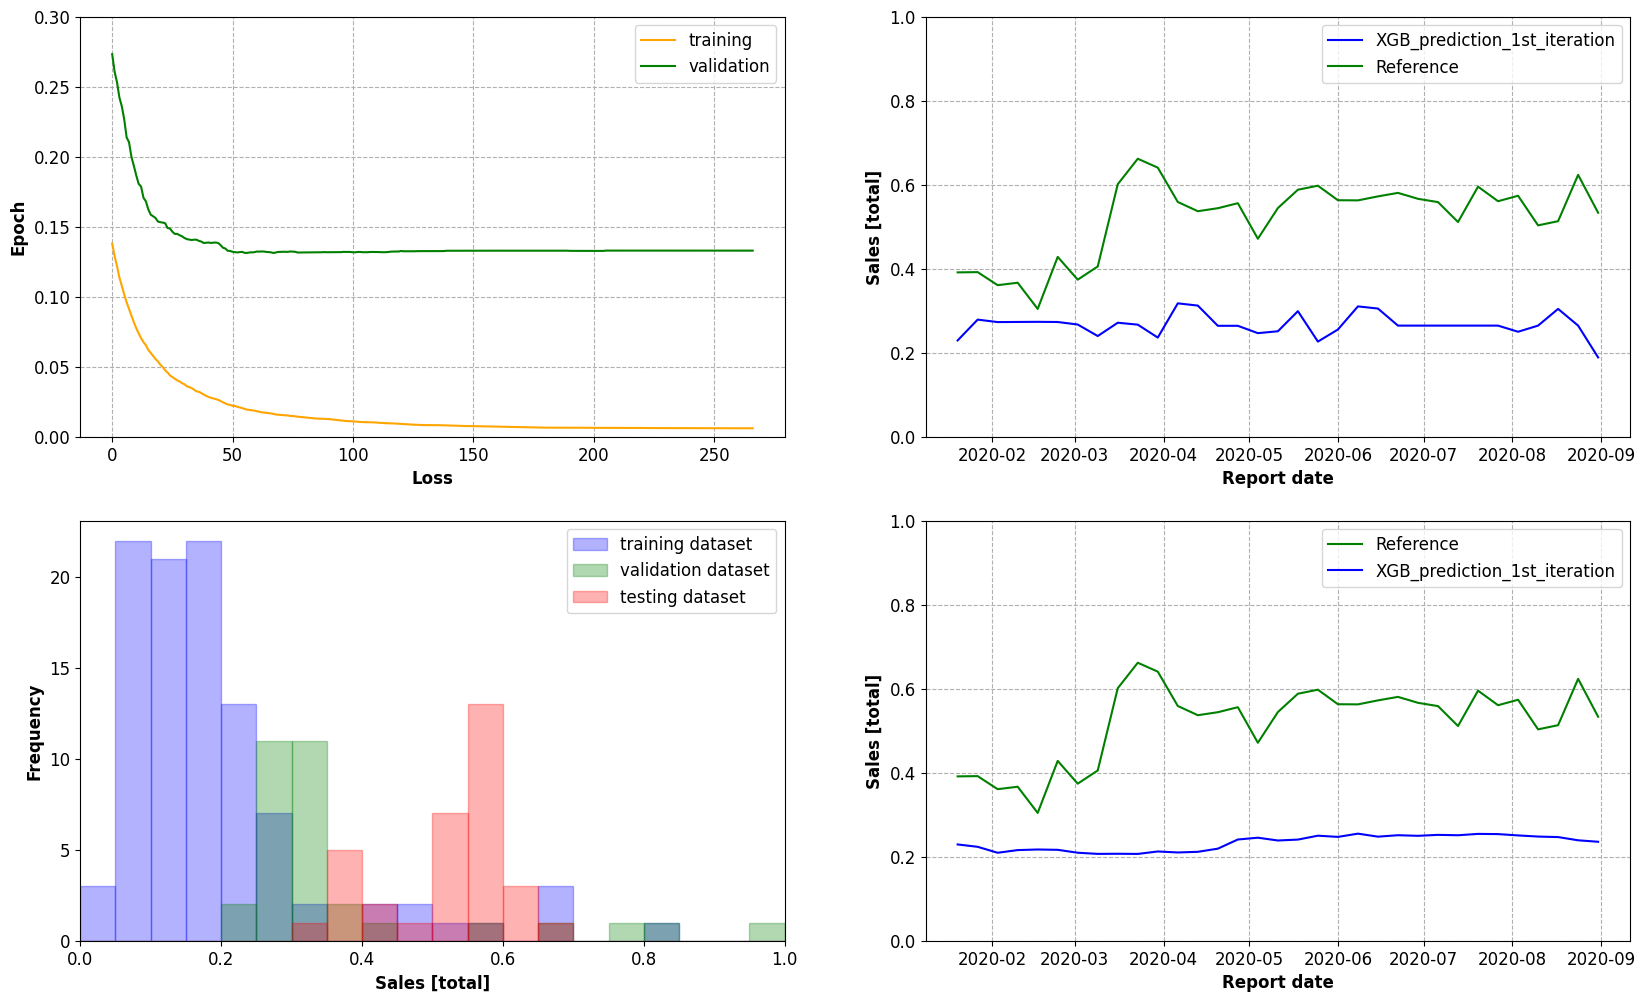

In [45]:
total_tuned_model_V1, total_training_log_tuned_V1 = xgb_model_total.single_xgb_train(
    best_param_input_total
)

# Get Model Details
# print(json.loads(total_tuned_model_V1.save_config()))
# Get Feature Importance
# total_tuned_model_V1.get_score(importance_type="gain")

evaluation_plot(
    model_name=total_tuned_model_V1,
    training_log=total_training_log_tuned_V1,
    test_df=test_total,
    retailer_type_name="total",
    train_df=train_total,
    val_df=val_total,
    forecast_name="XGB_prediction_1st_iteration",
)

evaluation_stat_total_V1 = evaluation_stat_dict(
    train_total, val_total, test_total, total_tuned_model_V1, "total"
)

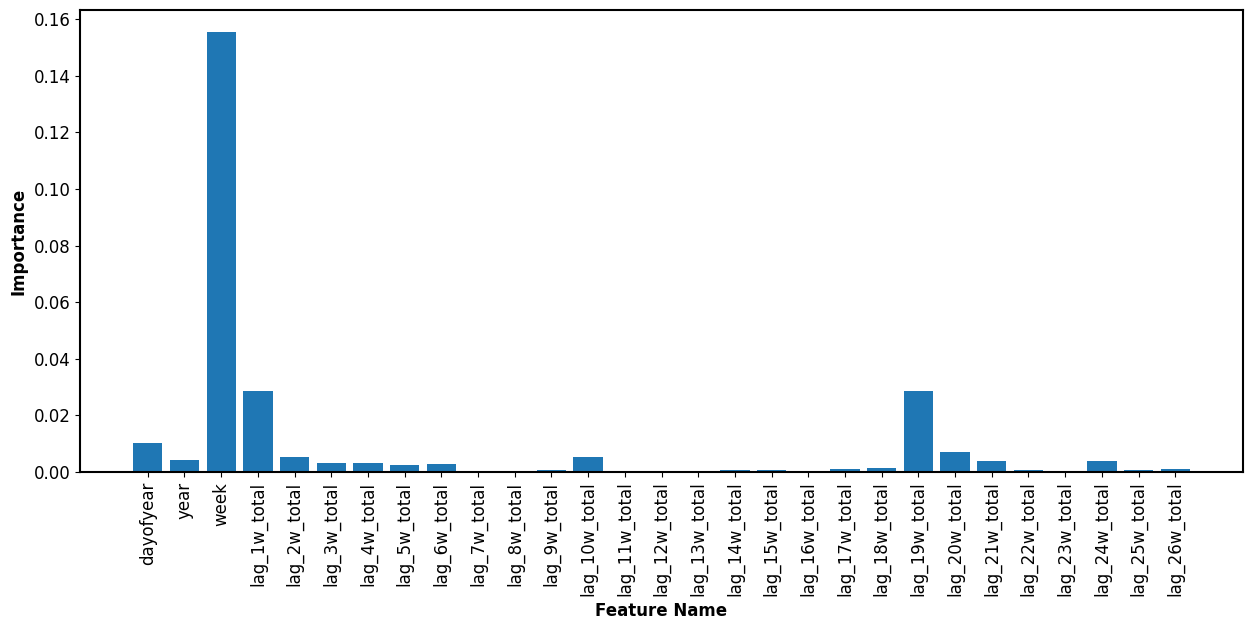

In [46]:
# Plot Feature importance
importance_plot(total_tuned_model_V1)

In [47]:
# Save the model
total_tuned_model_V1.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_Total_Experiment1_20231108_V1.json"
)

In [48]:
# # Test model loading
# xbg_model_load_test = xgb.Booster()
# xbg_model_load_test.load_model(PARENT_DIR_PATH + 'MODEL/XGB_Experiment1_20231108_V1.json')

# # Check the loaded model
# json.loads(xbg_model_load_test.save_config())

#### 6.2.3. XGBoost Model for `retialer type 1`

In [49]:
custom_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.8, 1),
    "min_child_weight": hp.uniform("min_child_weight", 1, 10),
    "subsample": hp.uniform("subsample", 0.8, 1),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 0),
}
train_rt1, val_rt1, test_rt1, xgb_model_rt1, best_param_input_rt1 = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="retailer_type_1",
    custom_space=custom_space,
)

Using customized space for finetuning
100%|██████████| 500/500 [01:15<00:00,  6.67trial/s, best loss: 0.00656127873035707]


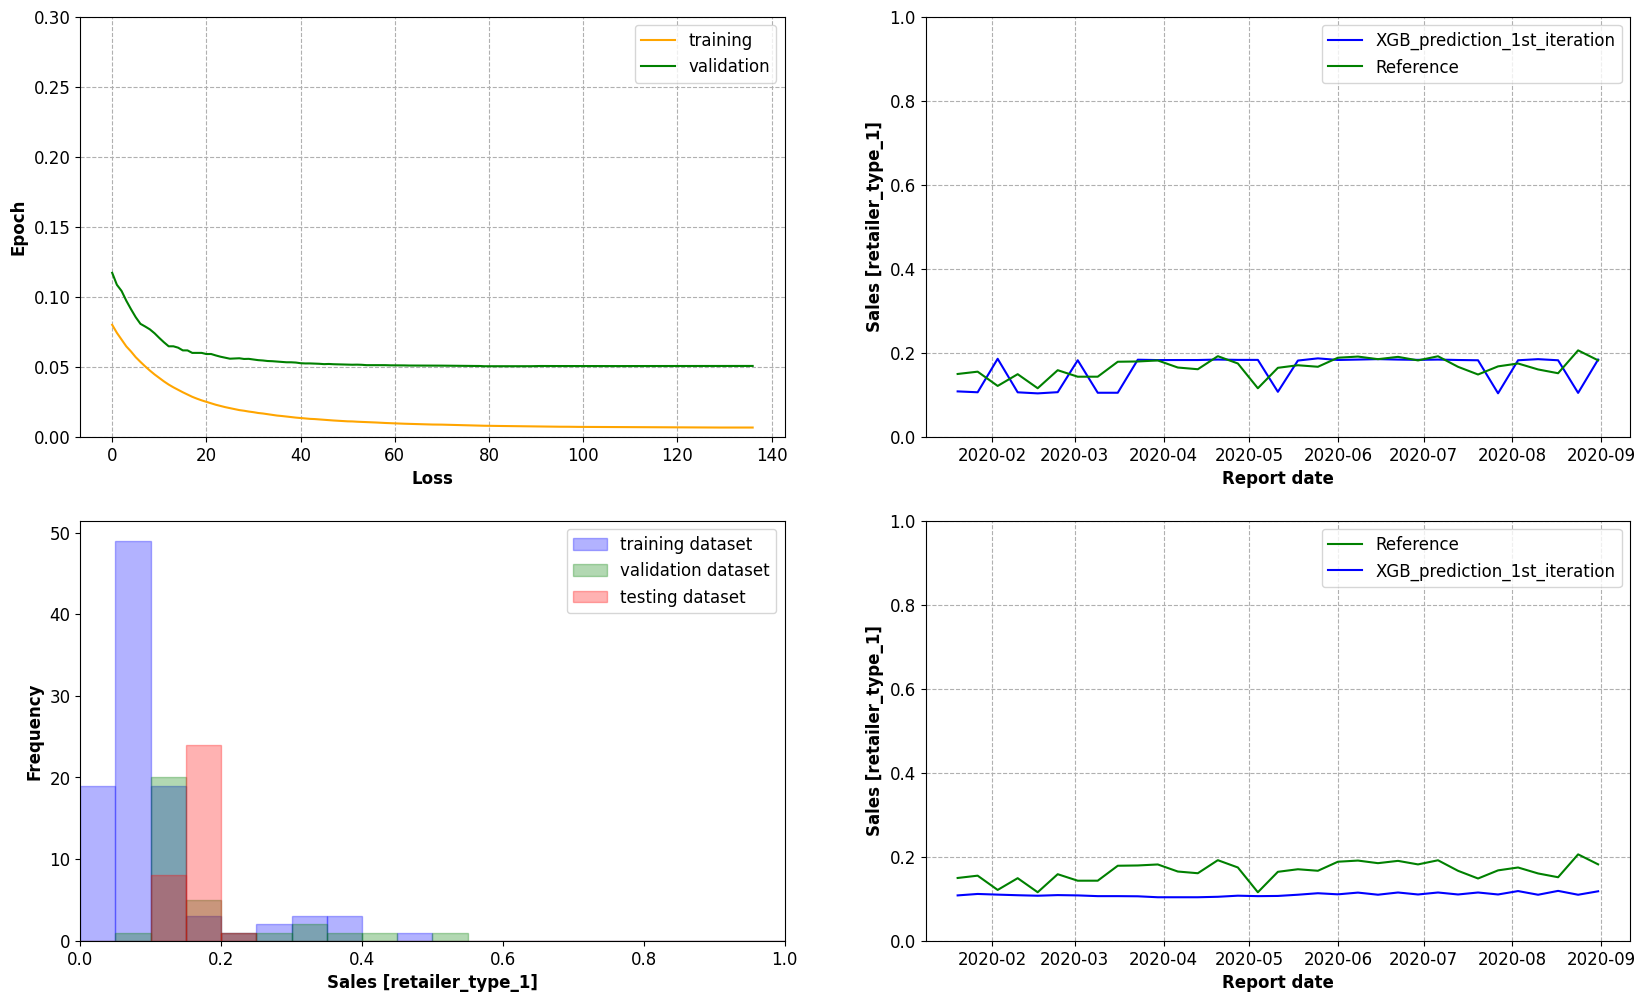

In [50]:
rt1_tuned_model_V1, rt1_training_log_tuned_V1 = xgb_model_rt1.single_xgb_train(
    best_param_input_rt1
)

# Get Model Details
# print(json.loads(rt1_tuned_model_V1.save_config()))
# Get Feature Importance
# rt1_tuned_model_V1.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt1_tuned_model_V1,
    training_log=rt1_training_log_tuned_V1,
    test_df=test_rt1,
    retailer_type_name="retailer_type_1",
    train_df=train_rt1,
    val_df=val_rt1,
    forecast_name="XGB_prediction_1st_iteration",
)

evaluation_stat_rt1_V1 = evaluation_stat_dict(
    train_rt1, val_rt1, test_rt1, rt1_tuned_model_V1, "retailer_type_1"
)

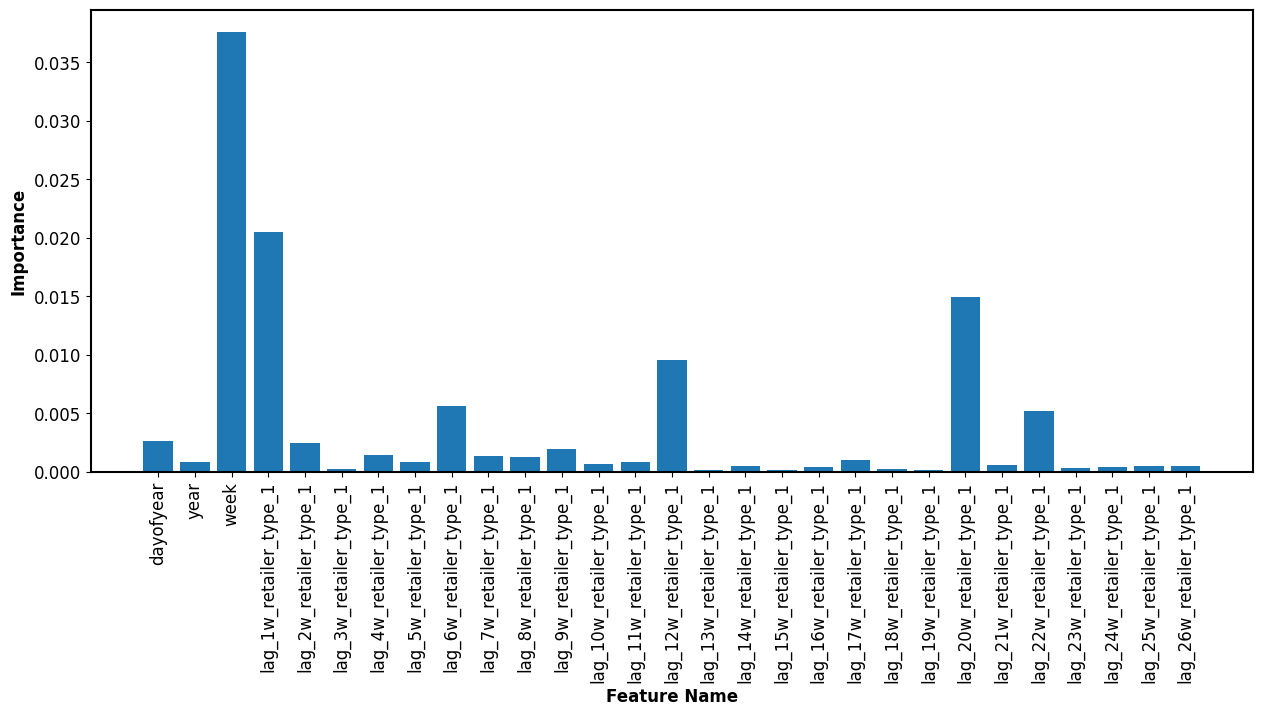

In [51]:
# Plot Feature importance
importance_plot(rt1_tuned_model_V1)

In [52]:
# Save the model
rt1_tuned_model_V1.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT1_Experiment1_20231108_V1.json"
)

#### 6.3.4. XGBoost Model for `retialer type 2`

In [53]:
custom_space = {
    "max_depth": hp.quniform("max_depth", 3, 21, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.9, 1),
    "min_child_weight": hp.uniform("min_child_weight", 1, 10),
    "subsample": hp.uniform("subsample", 0.8, 1),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 0),
}
train_rt2, val_rt2, test_rt2, xgb_model_rt2, best_param_input_rt2 = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="retailer_type_2",
    custom_space=custom_space,
)

Using customized space for finetuning
100%|██████████| 500/500 [00:52<00:00,  9.59trial/s, best loss: 0.00205390556686722]


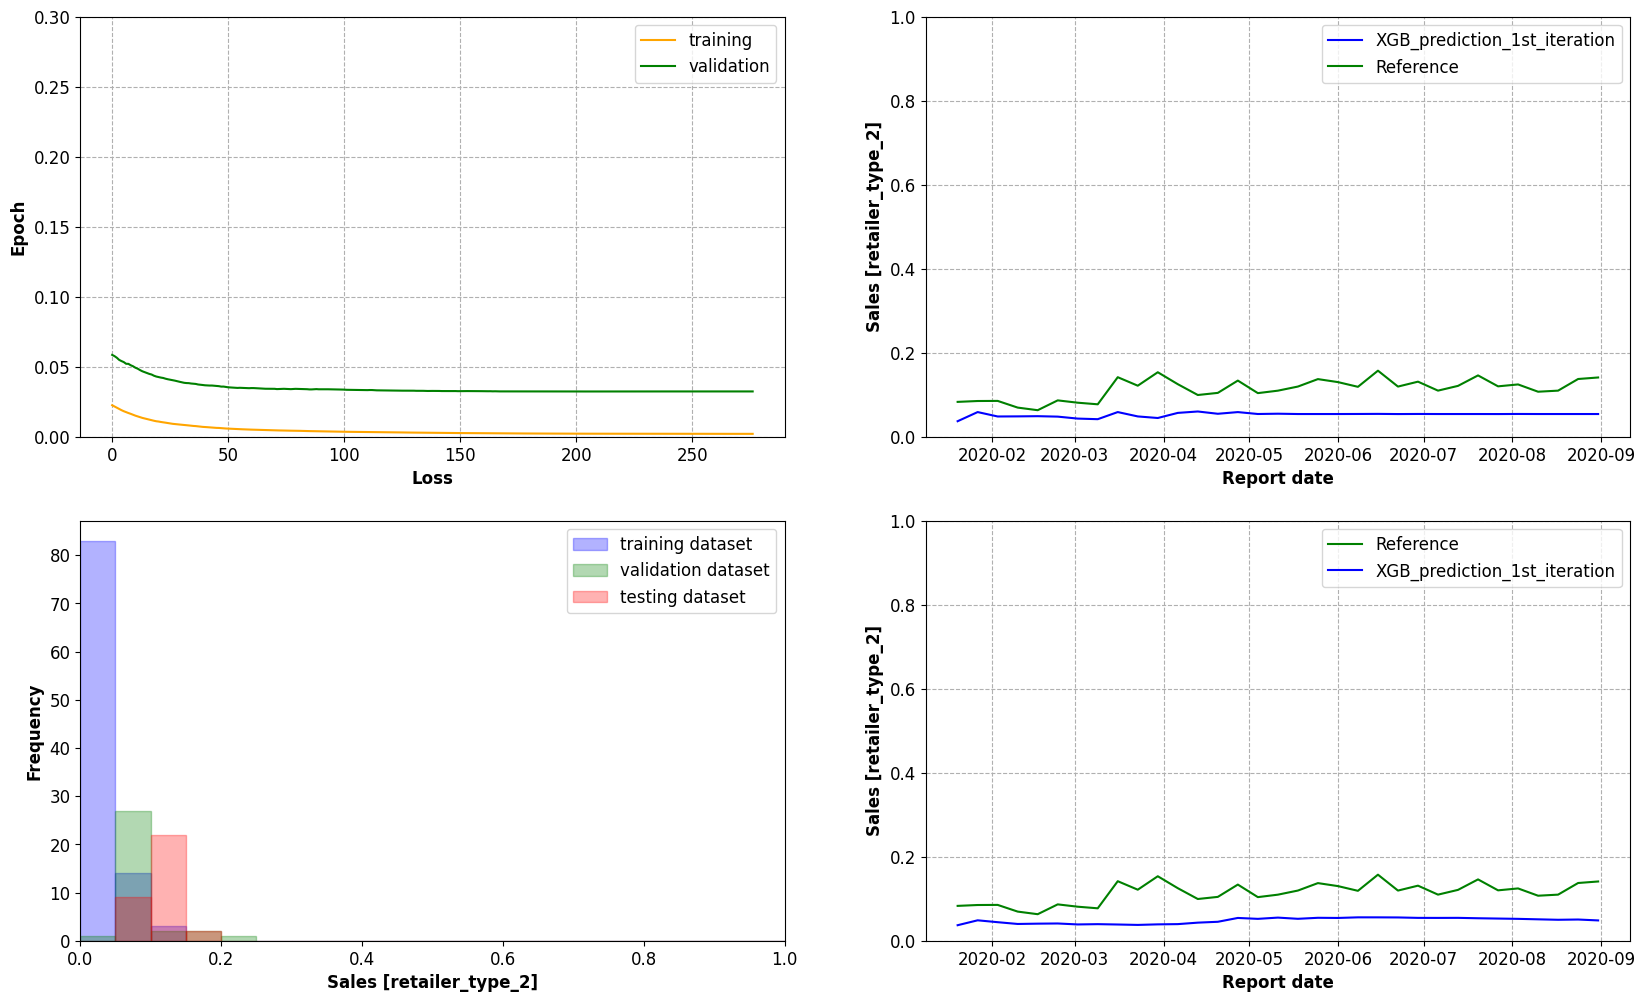

In [54]:
rt2_tuned_model_V1, rt2_training_log_tuned_V1 = xgb_model_rt2.single_xgb_train(
    best_param_input_rt2
)

# Get Model Details
# print(json.loads(rt2_tuned_model_V1.save_config()))
# Get Feature Importance
# rt2_tuned_model_V1.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt2_tuned_model_V1,
    training_log=rt2_training_log_tuned_V1,
    test_df=test_rt2,
    retailer_type_name="retailer_type_2",
    train_df=train_rt2,
    val_df=val_rt2,
    forecast_name="XGB_prediction_1st_iteration",
)

evaluation_stat_rt2_V1 = evaluation_stat_dict(
    train_rt2, val_rt2, test_rt2, rt2_tuned_model_V1, "retailer_type_2"
)

> Ceiling Effect observed

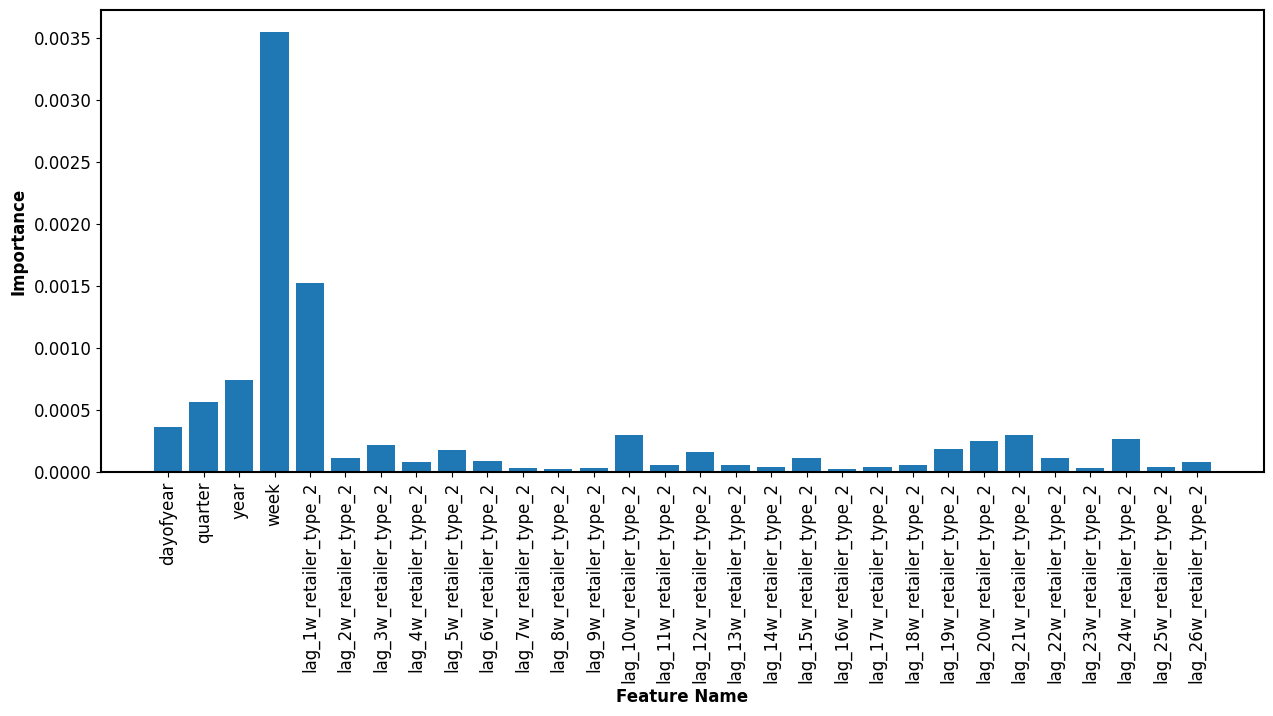

In [55]:
# Plot Feature importance
importance_plot(rt2_tuned_model_V1)

In [56]:
# Save the model
rt2_tuned_model_V1.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT2_Experiment1_20231108_V1.json"
)

#### 6.3.5. XGBoost Model for `retialer type 3`

In [57]:
custom_space = {
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "gamma": hp.uniform("gamma", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.8, 1),
    "min_child_weight": hp.uniform("min_child_weight", 1, 10),
    "subsample": hp.uniform("subsample", 0.8, 1),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),
    "reg_alpha": hp.loguniform("reg_alpha", -5, 0),
    "reg_lambda": hp.loguniform("reg_lambda", -5, 0),
}

train_rt3, val_rt3, test_rt3, xgb_model_rt3, best_param_input_rt3 = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="retailer_type_3",
    custom_space=custom_space,
)

Using customized space for finetuning
100%|██████████| 500/500 [00:44<00:00, 11.17trial/s, best loss: 0.00232830514604855]


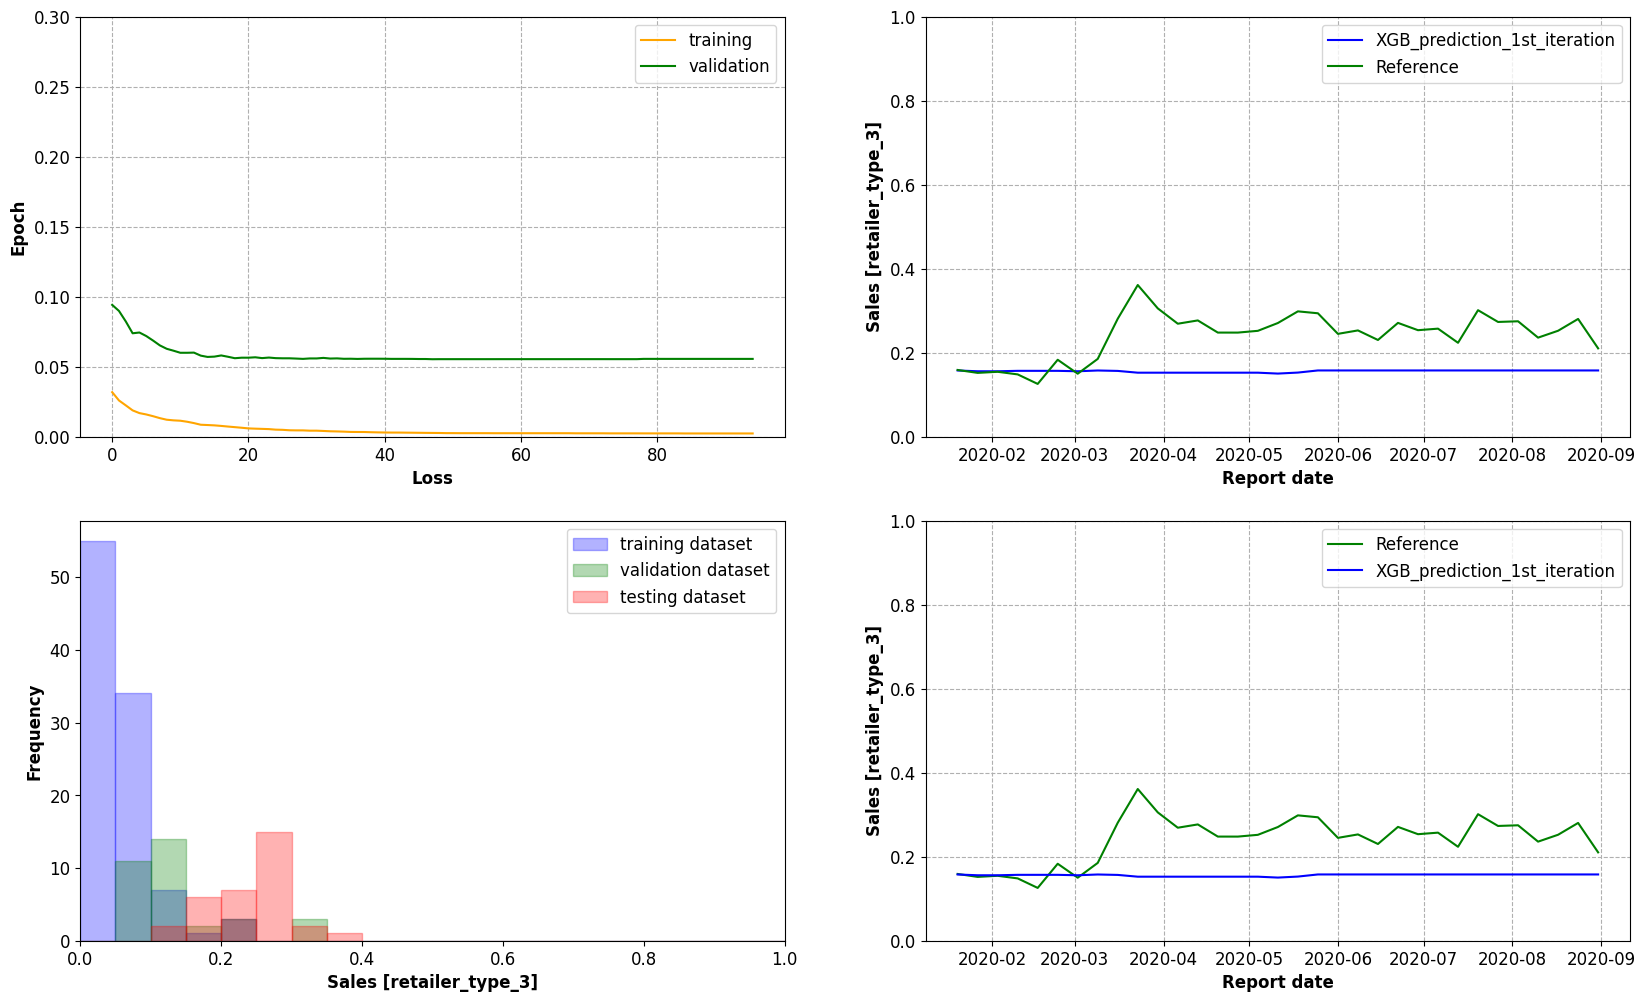

In [58]:
rt3_tuned_model_V1, rt3_training_log_tuned_V1 = xgb_model_rt3.single_xgb_train(
    best_param_input_rt3
)

# Get Model Details
# print(json.loads(rt3_tuned_model_V1.save_config()))
# Get Feature Importance
# rt3_tuned_model_V1.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt3_tuned_model_V1,
    training_log=rt3_training_log_tuned_V1,
    test_df=test_rt3,
    retailer_type_name="retailer_type_3",
    train_df=train_rt3,
    val_df=val_rt3,
    forecast_name="XGB_prediction_1st_iteration",
)

evaluation_stat_rt3_V1 = evaluation_stat_dict(
    train_rt3, val_rt3, test_rt3, rt3_tuned_model_V1, "retailer_type_3"
)

> Ceiling Effect observed

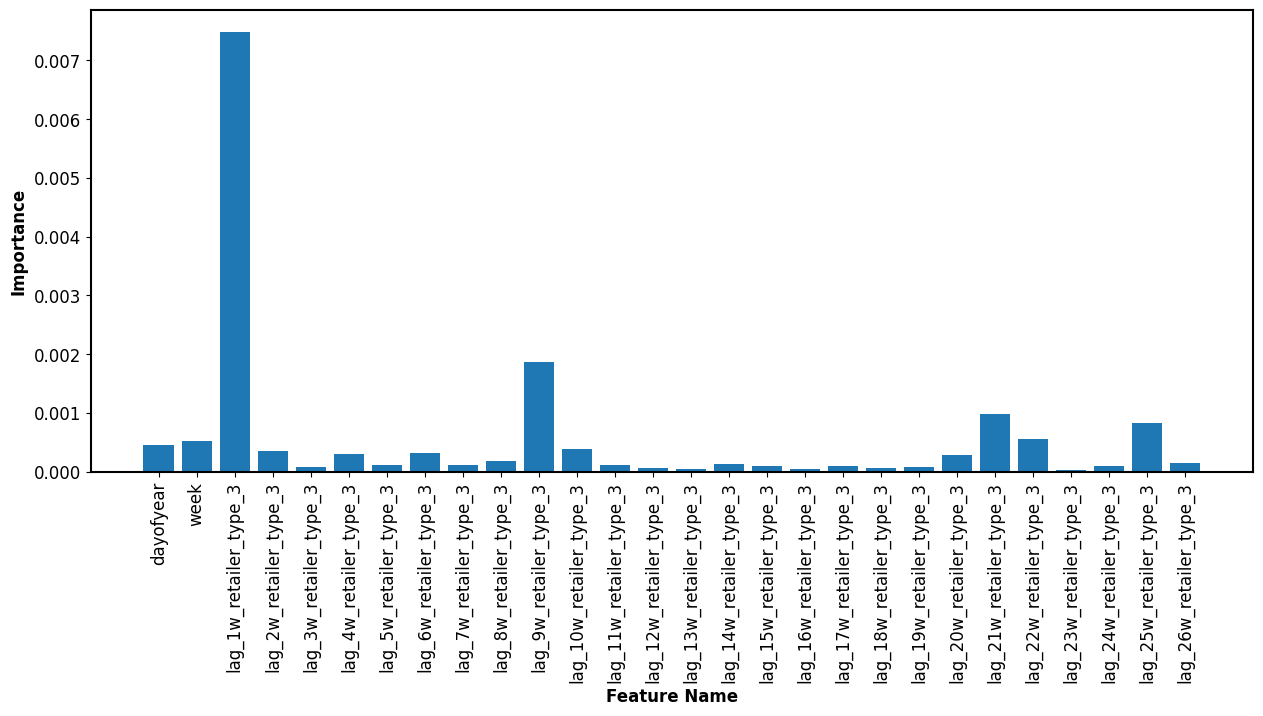

In [59]:
# Plot Feature importance
importance_plot(rt3_tuned_model_V1)

In [60]:
# Save the model
rt3_tuned_model_V1.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT3_Experiment1_20231108_V1.json"
)

#### 6.3.6. Summary of 1st iteration

In [61]:
# RMSE
summary_df_iter_1 = pd.DataFrame(
    columns=[
        "train_RMSE",
        "val_RMSE",
        "test_RMSE",
        "forecast_RMSE",
        "train_MAE",
        "val_MAE",
        "test_MAE",
        "forecast_MAE",
        "train_R2",
        "val_R2",
        "test_R2",
        "forecast_R2",
    ],
    index=[
        "total (iter1)",
        "retailer_type_1 (iter1)",
        "retailer_type_2 (iter1)",
        "retailer_type_3 (iter1)",
    ],
)
summary_df_iter_1.iloc[0, :] = pd.DataFrame(evaluation_stat_total_V1.items())[1].values
summary_df_iter_1.iloc[1, :] = pd.DataFrame(evaluation_stat_rt1_V1.items())[1].values
summary_df_iter_1.iloc[2, :] = pd.DataFrame(evaluation_stat_rt2_V1.items())[1].values
summary_df_iter_1.iloc[3, :] = pd.DataFrame(evaluation_stat_rt3_V1.items())[1].values
summary_df_iter_1.astype("float").style.background_gradient(cmap="coolwarm")
summary_df_iter_1.to_csv(PARENT_DIR_PATH + "LOG/LOG_Experiment1_20231108_V1.csv")

### 6.3. 2nd iteration: ML model: XGBoost with new split

#### 6.3.1. XGBoost Model for retialer type `total`

In [62]:
(
    train_total,
    val_total,
    test_total,
    val_total_first_part,
    xgb_model_total,
    best_param_input_total_V2,
) = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="total",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
)

Using default space for finetuning
100%|██████████| 500/500 [01:36<00:00,  5.18trial/s, best loss: 0.00363058494810742]


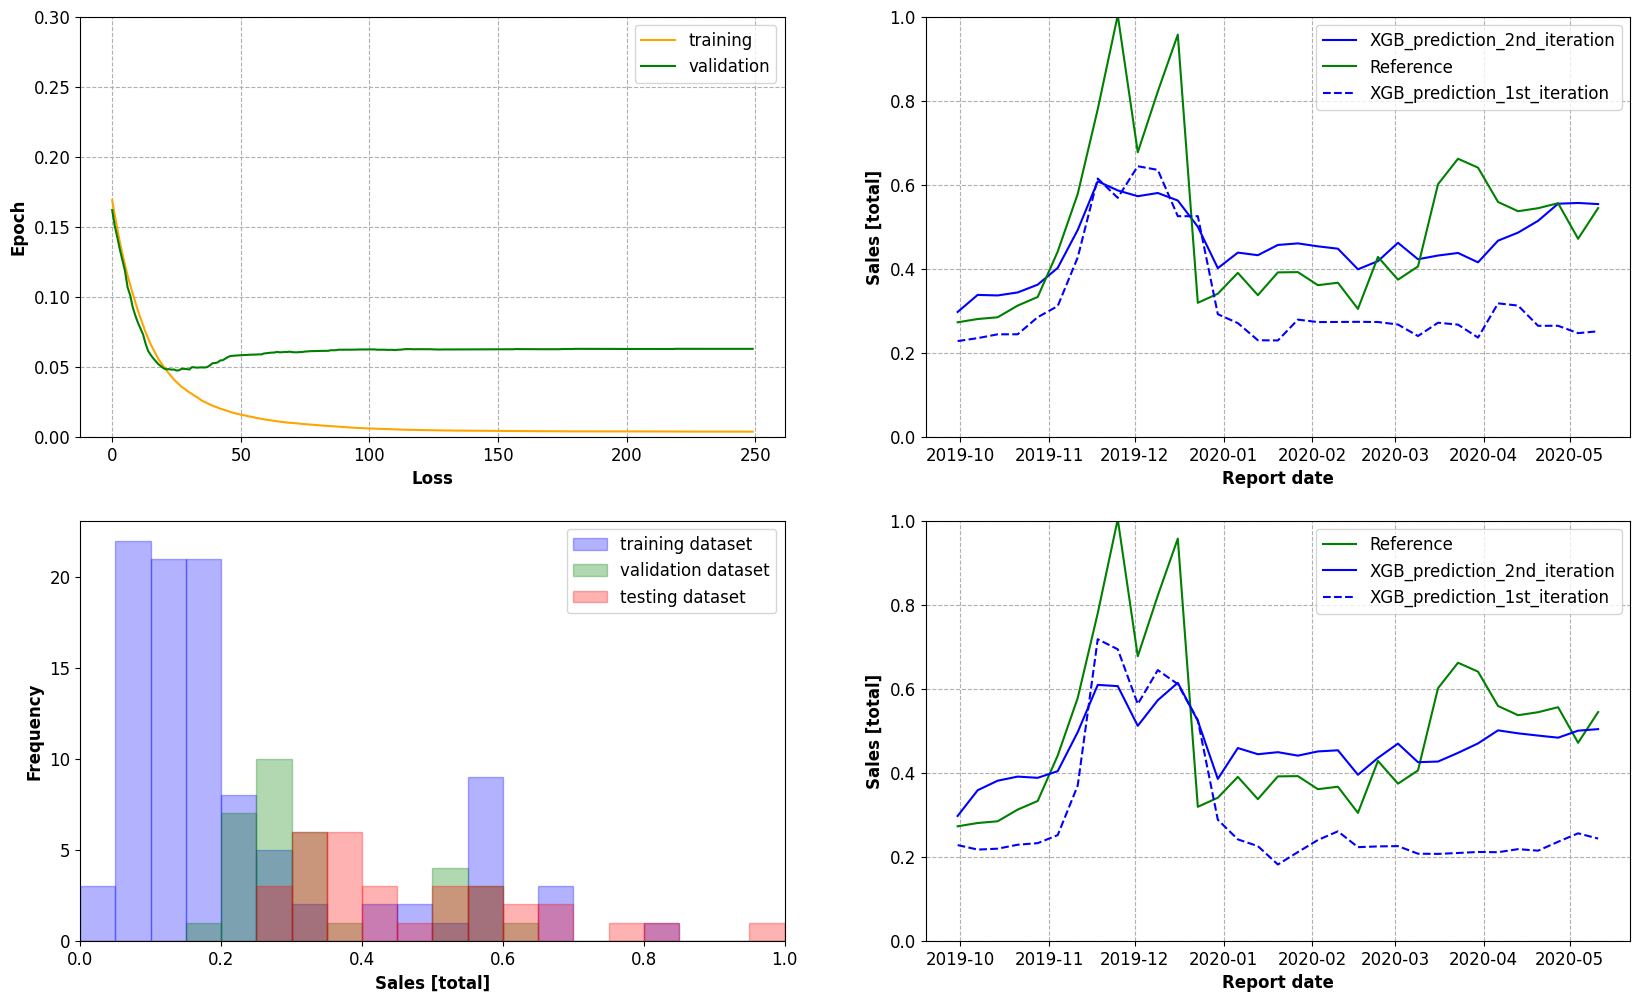

In [63]:
total_tuned_model_V2, total_training_log_tuned_V2 = xgb_model_total.single_xgb_train(
    best_param_input_total_V2
)

# Get Model Details
# print(json.loads(total_tuned_model_V2.save_config()))
# Get Feature Importance
# total_tuned_model_V2.get_score(importance_type="gain")

evaluation_plot(
    model_name=total_tuned_model_V2,
    training_log=total_training_log_tuned_V2,
    test_df=test_total,
    retailer_type_name="total",
    train_df=train_total,
    val_df=val_total,
    forecast_name="XGB_prediction_2nd_iteration",
    compare_forecast_model=total_tuned_model_V1,
    compare_forecast_name="XGB_prediction_1st_iteration",
    val_df_first=val_total_first_part,
)

evaluation_stat_total_V2 = evaluation_stat_dict(
    train_total,
    val_total,
    test_total,
    total_tuned_model_V2,
    "total",
    val_df_first_part=val_total_first_part,
)

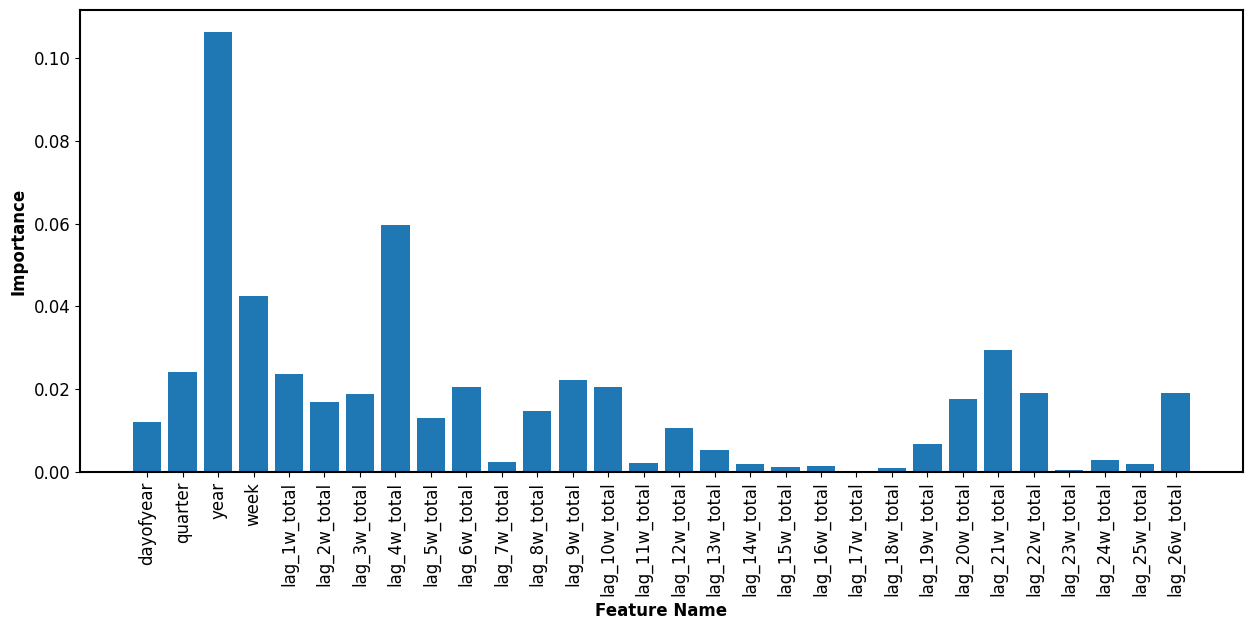

In [113]:
# Plot Feature importance
importance_plot(total_tuned_model_V2)

In [65]:
# Save the model
total_tuned_model_V2.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_Total_Experiment2_20231108_V1.json"
)

#### 6.3.2. XGBoost Model for `retialer type 1`

In [66]:
(
    train_rt1,
    val_rt1,
    test_rt1,
    val_rt1_first_part,
    xgb_model_rt1,
    best_param_input_rt1_V2,
) = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="retailer_type_1",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
)

Using default space for finetuning
100%|██████████| 500/500 [00:49<00:00, 10.18trial/s, best loss: 0.00309838600310278]


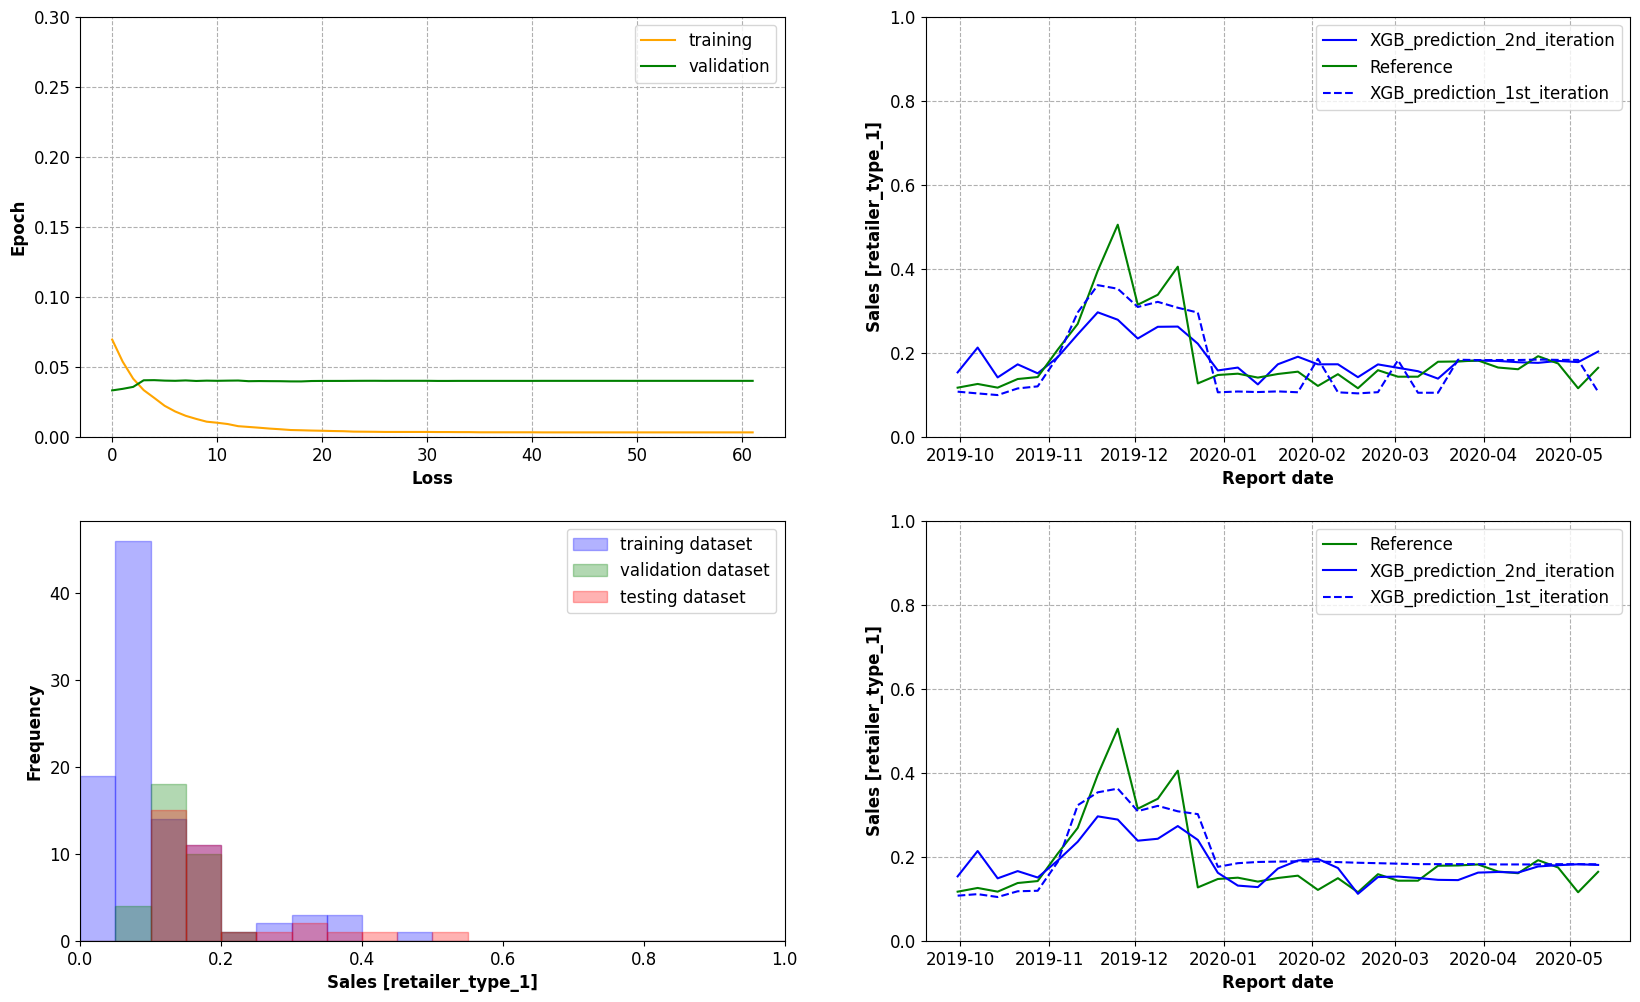

In [67]:
rt1_tuned_model_V2, rt1_training_log_tuned_V2 = xgb_model_rt1.single_xgb_train(
    best_param_input_rt1_V2
)

# Get Model Details
# print(json.loads(rt1_tuned_model_V2.save_config()))
# Get Feature Importance
# rt1_tuned_model_V2.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt1_tuned_model_V2,
    training_log=rt1_training_log_tuned_V2,
    test_df=test_rt1,
    retailer_type_name="retailer_type_1",
    train_df=train_rt1,
    val_df=val_rt1,
    forecast_name="XGB_prediction_2nd_iteration",
    compare_forecast_model=rt1_tuned_model_V1,
    compare_forecast_name="XGB_prediction_1st_iteration",
    val_df_first=val_rt1_first_part,
)

evaluation_stat_rt1_V2 = evaluation_stat_dict(
    train_rt1,
    val_rt1,
    test_rt1,
    rt1_tuned_model_V2,
    "retailer_type_1",
    val_df_first_part=val_rt1_first_part,
)

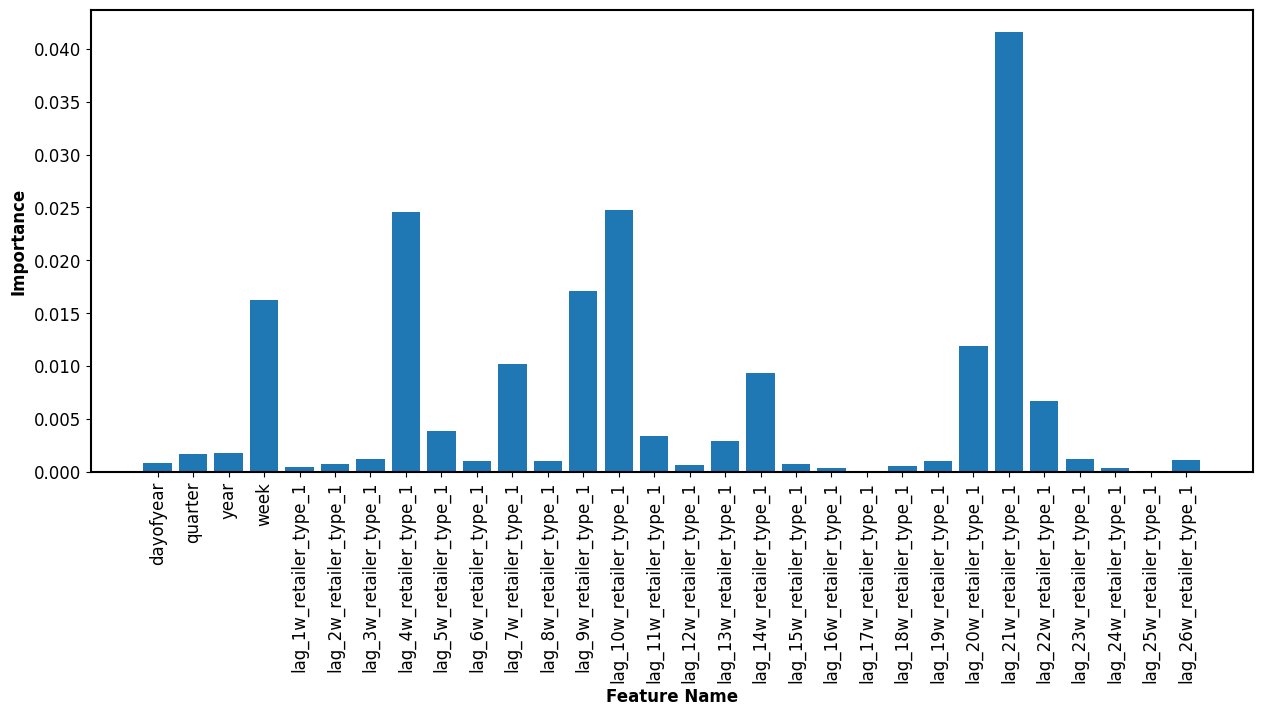

In [68]:
# Plot Feature importance
importance_plot(rt1_tuned_model_V2)

In [69]:
# Save the model
rt1_tuned_model_V2.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT1_Experiment2_20231108_V1.json"
)

#### 6.3.3. XGBoost Model for `retialer type 2`

In [70]:
(
    train_rt2,
    val_rt2,
    test_rt2,
    val_rt2_first_part,
    xgb_model_rt2,
    best_param_input_rt2_V2,
) = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="retailer_type_2",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
)

Using default space for finetuning
100%|██████████| 500/500 [00:36<00:00, 13.73trial/s, best loss: 0.0039238665260484]


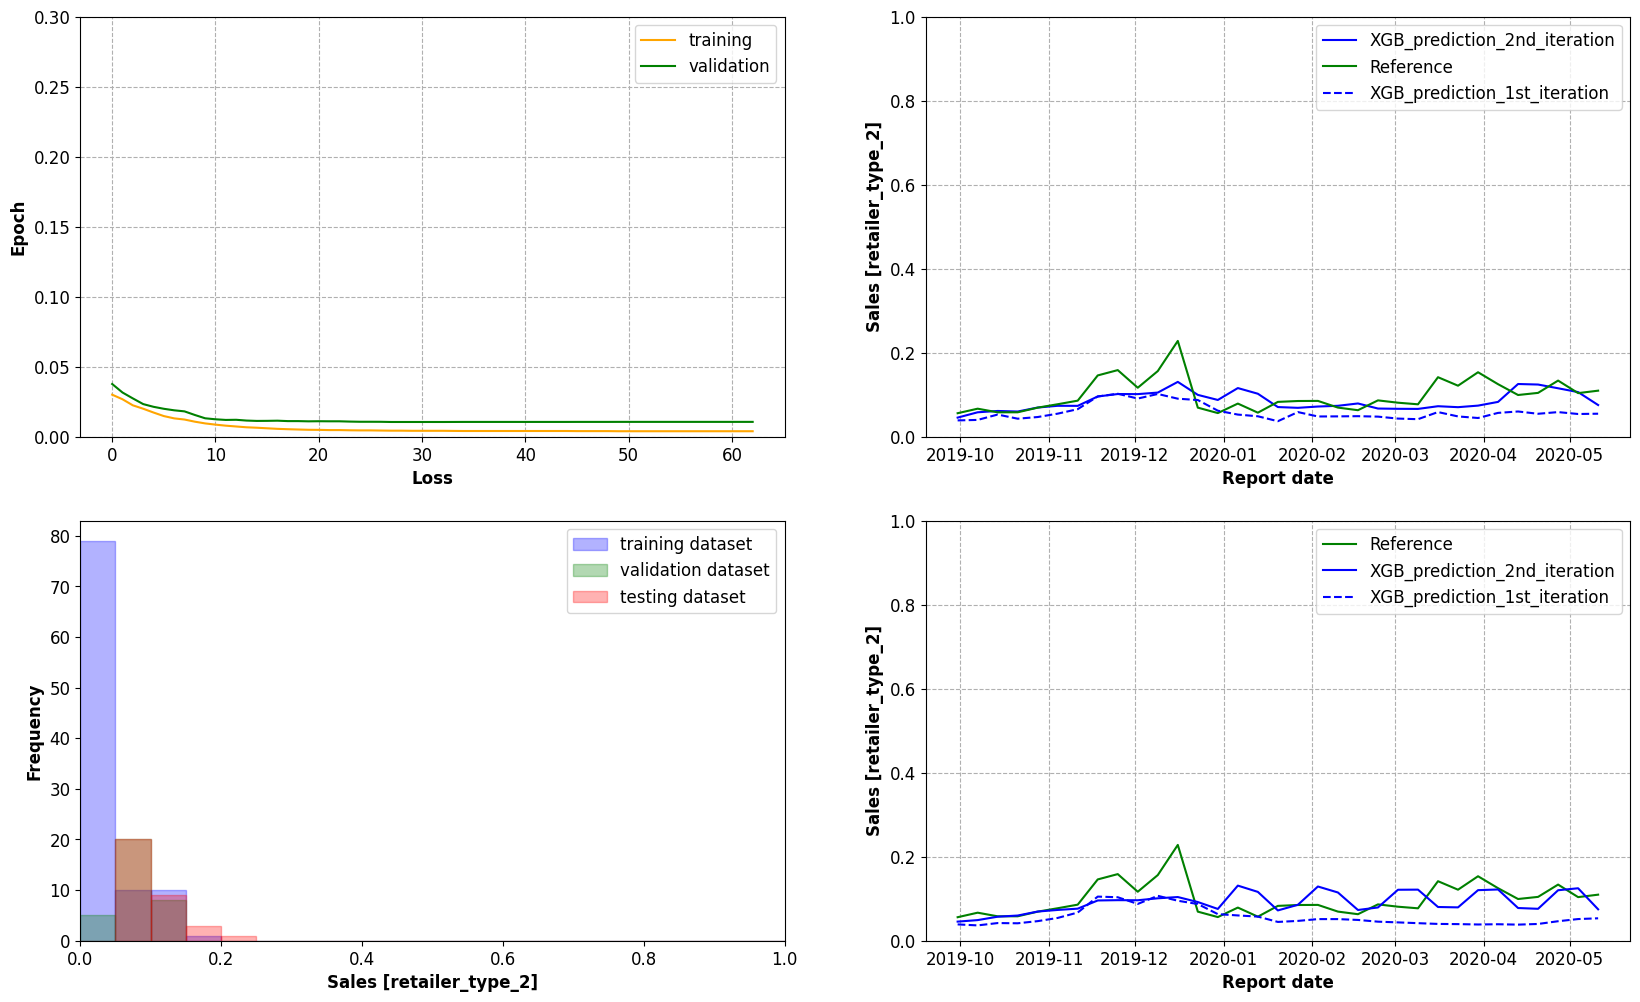

In [71]:
rt2_tuned_model_V2, rt2_training_log_tuned_V2 = xgb_model_rt2.single_xgb_train(
    best_param_input_rt2_V2
)

# Get Model Details
# print(json.loads(rt1_tuned_model_V2.save_config()))
# Get Feature Importance
# rt1_tuned_model_V2.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt2_tuned_model_V2,
    training_log=rt2_training_log_tuned_V2,
    test_df=test_rt2,
    retailer_type_name="retailer_type_2",
    train_df=train_rt2,
    val_df=val_rt2,
    forecast_name="XGB_prediction_2nd_iteration",
    compare_forecast_model=rt2_tuned_model_V1,
    compare_forecast_name="XGB_prediction_1st_iteration",
    val_df_first=val_rt2_first_part,
)

evaluation_stat_rt2_V2 = evaluation_stat_dict(
    train_rt2,
    val_rt2,
    test_rt2,
    rt2_tuned_model_V2,
    "retailer_type_2",
    val_df_first_part=val_rt2_first_part,
)

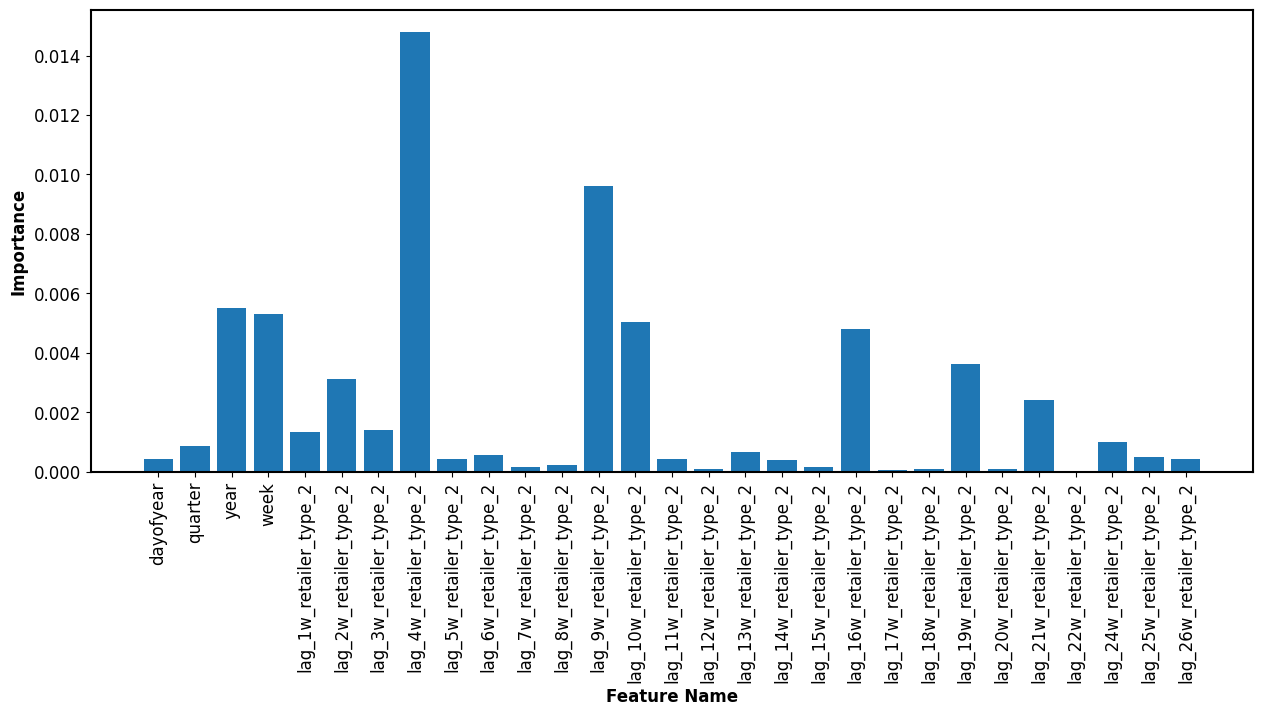

In [72]:
# Plot Feature importance
importance_plot(rt2_tuned_model_V2)

In [73]:
# Save the model
rt2_tuned_model_V2.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT2_Experiment2_20231108_V1.json"
)

#### 6.3.4. XGBoost Model for `retialer type 3`

In [74]:
(
    train_rt3,
    val_rt3,
    test_rt3,
    val_rt3_first_part,
    xgb_model_rt3,
    best_param_input_rt3_V2,
) = model_tuning(
    input_df=df_features_NoNa,
    retailer_type="retailer_type_3",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
)

Using default space for finetuning
100%|██████████| 500/500 [01:22<00:00,  6.06trial/s, best loss: 0.00295379757957249]


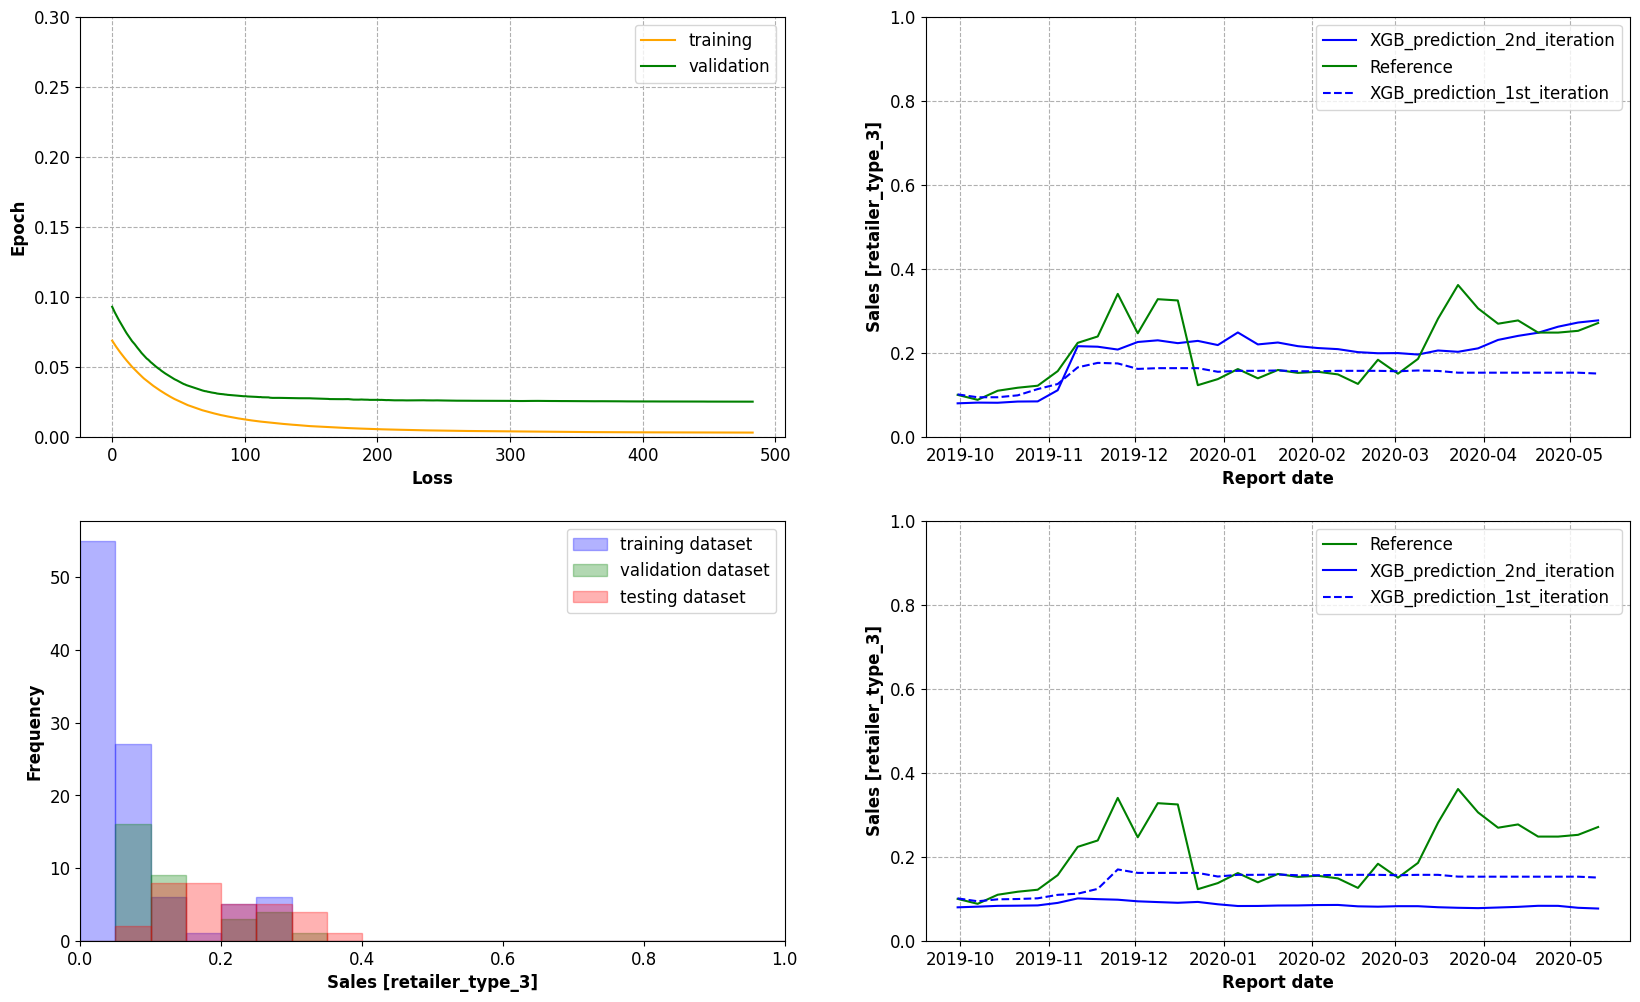

In [75]:
rt3_tuned_model_V2, rt3_training_log_tuned_V2 = xgb_model_rt3.single_xgb_train(
    best_param_input_rt3_V2
)

# Get Model Details
# print(json.loads(rt3_tuned_model_V2.save_config()))
# Get Feature Importance
# rt3_tuned_model_V2.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt3_tuned_model_V2,
    training_log=rt3_training_log_tuned_V2,
    test_df=test_rt3,
    retailer_type_name="retailer_type_3",
    train_df=train_rt3,
    val_df=val_rt3,
    forecast_name="XGB_prediction_2nd_iteration",
    compare_forecast_model=rt3_tuned_model_V1,
    compare_forecast_name="XGB_prediction_1st_iteration",
    val_df_first=val_rt3_first_part,
)

evaluation_stat_rt3_V2 = evaluation_stat_dict(
    train_rt3,
    val_rt3,
    test_rt3,
    rt3_tuned_model_V2,
    "retailer_type_3",
    val_df_first_part=val_rt3_first_part,
)

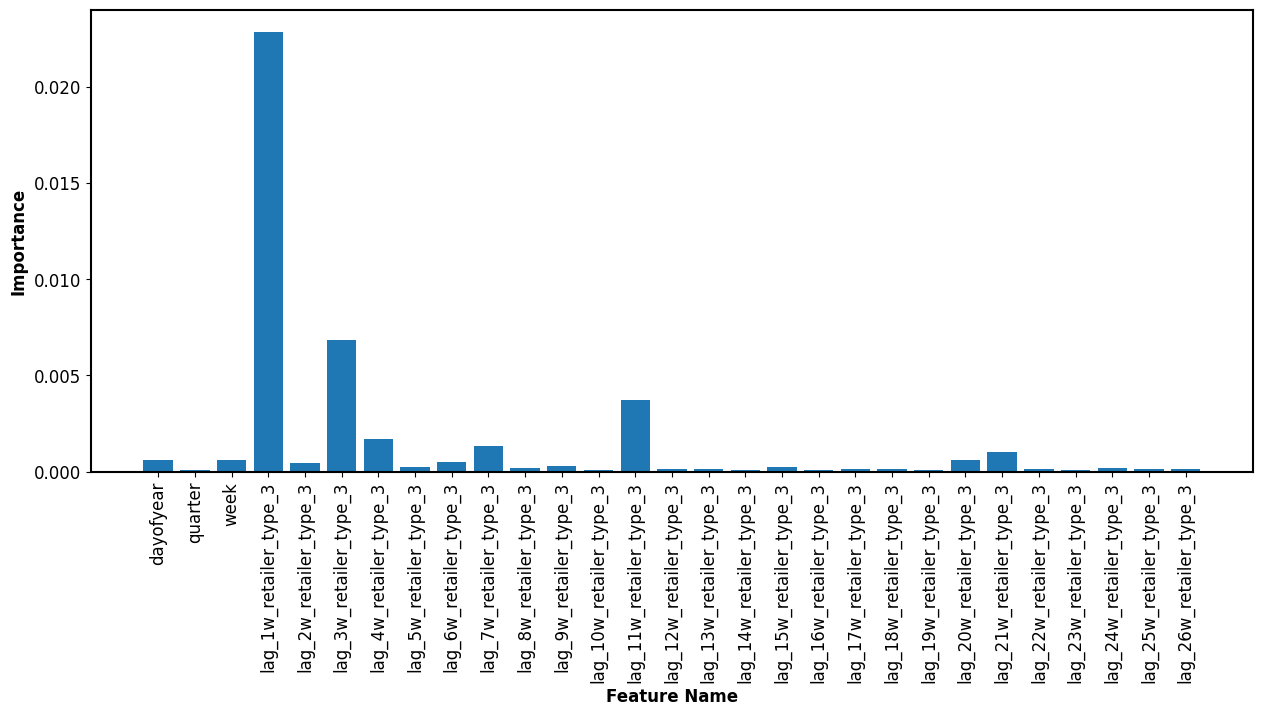

In [76]:
# Plot Feature importance
importance_plot(rt3_tuned_model_V2)

In [77]:
# Save the model
rt3_tuned_model_V2.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT3_Experiment2_20231108_V1.json"
)

#### 6.3.5. Summary of 2nd iteration

In [78]:
summary_df_iter_2 = pd.DataFrame(
    columns=[
        "train_RMSE",
        "val_RMSE",
        "test_RMSE",
        "forecast_RMSE",
        "train_MAE",
        "val_MAE",
        "test_MAE",
        "forecast_MAE",
        "train_R2",
        "val_R2",
        "test_R2",
        "forecast_R2",
    ],
    index=[
        "total (iter2)",
        "retailer_type_1 (iter2)",
        "retailer_type_2 (iter2)",
        "retailer_type_3 (iter2)",
    ],
)
summary_df_iter_2.iloc[0, :] = pd.DataFrame(evaluation_stat_total_V2.items())[1].values
summary_df_iter_2.iloc[1, :] = pd.DataFrame(evaluation_stat_rt1_V2.items())[1].values
summary_df_iter_2.iloc[2, :] = pd.DataFrame(evaluation_stat_rt2_V2.items())[1].values
summary_df_iter_2.iloc[3, :] = pd.DataFrame(evaluation_stat_rt3_V2.items())[1].values
summary_df_iter_2.astype("float").style.background_gradient(cmap="coolwarm")
summary_df_iter_2.to_csv(PARENT_DIR_PATH + "LOG/LOG_Experiment2_20231108_V1.csv")

### 6.4. 3rd iteration: ML model: XGBoost with external data

#### 6.4.1. New Feature engineering

In [79]:
external_df = pd.read_csv(
    "/content/DATA/External_Data-SI-BCOP.csv",
)
external_df["report_date"] = external_df["report_date"].apply(pd.Timestamp)
external_df = external_df.set_index("report_date")
external_df = external_df.divide(100)

In [80]:
lags = 26

# Create a copy of the original DataFrame
df_features_init = df_raw.copy()
df_features = pd.concat([df_features_init, external_df], axis=1)

# Extract date-related features
date_features = ["dayofyear", "dayofweek", "quarter", "year"]
for feature in date_features:
    df_features[feature] = getattr(df_features.index, feature)

df_features["week"] = df_features.index.isocalendar().week

df_features

# Create lag features
lag_dataframes = []

for lag in range(1, lags + 1):
    lag_features = {}
    for retailer_type in df_features.columns:
        lag_features[f"lag_{lag}w_{retailer_type}"] = df_features[retailer_type].shift(
            lag
        )
    lag_dataframes.append(pd.DataFrame(lag_features))

# Concatenate lag DataFrames along columns axis
df_features = pd.concat([df_features] + lag_dataframes, axis=1)

df_features_ex_NoNa = df_features.dropna()
df_features_ex_NoNa.head()

total  retailer_type_1  retailer_type_2  retailer_type_3  \
report_date                                                                
2017-07-03   0.070976         0.039885         0.011618         0.019474   
2017-07-10   0.095340         0.058041         0.016572         0.020727   
2017-07-17   0.065201         0.038932         0.012076         0.014193   
2017-07-24   0.073955         0.044207         0.013682         0.016065   
2017-07-31   0.032471         0.017177         0.006865         0.008429   

             SI_High  SI_Mean  SI_Low  Brent_Crude_Oil_High  \
report_date                                                   
2017-07-03       0.0      0.0     0.0                0.4911   
2017-07-10       0.0      0.0     0.0                0.5019   
2017-07-17       0.0      0.0     0.0                0.5270   
2017-07-24       0.0      0.0     0.0                0.5293   
2017-07-31       0.0      0.0     0.0                0.5364   

             Brent_Crude_Oil_Low  dayofyear  ...  lag_26w_SI_High  \
report_date                                  ...                    
2017-07-03                0.4611        184  ...              0.0   
2017-07-10                0.4781        191  ...              0.0   
2017-07-17                0.4768        198  ...              0.0   
2017-07-24                0.5088        205  ...              0.0   
2017-07-31                0.5130        212  ...              0.0   

             lag_26w_SI_Mean  lag_26w_SI_Low  lag_26w_Brent_Crude_Oil_High  \
report_date                                                                  
2017-07-03               0.0             0.0                        0.5700   
2017-07-10               0.0             0.0                        0.5695   
2017-07-17               0.0             0.0                        0.5655   
2017-07-24               0.0             0.0                        0.5745   
2017-07-31               0.0             0.0                        0.5713   

             lag_26w_Brent_Crude_Oil_Low  lag_26w_dayofyear  \
report_date                                                   
2017-07-03                        0.5358                2.0   
2017-07-10                        0.5377                9.0   
2017-07-17                        0.5465               16.0   
2017-07-24                        0.5490               23.0   
2017-07-31                        0.5444               30.0   

             lag_26w_dayofweek  lag_26w_quarter  lag_26w_year  lag_26w_week  
report_date                                                                  
2017-07-03                 0.0              1.0        2017.0             1  
2017-07-10                 0.0              1.0        2017.0             2  
2017-07-17                 0.0              1.0        2017.0             3  
2017-07-24                 0.0              1.0        2017.0             4  
2017-07-31                 0.0              1.0        2017.0             5  

[5 rows x 378 columns]

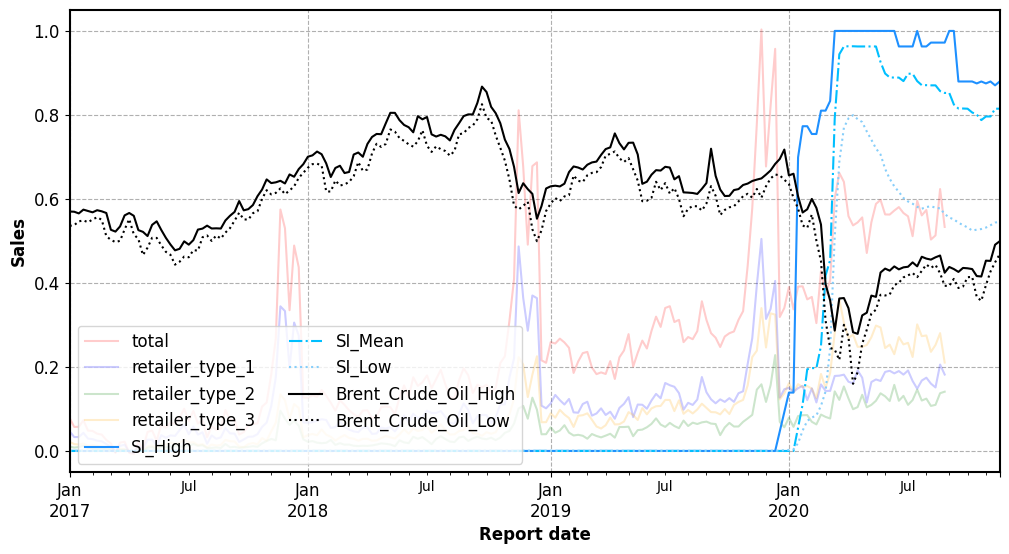

In [81]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Customize spines
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

# Plot the data with specific colors
colors = ["red", "blue", "green", "orange"]
df_raw.plot(ax=ax, color=colors, alpha=0.2)


coolr_list = ["dodgerblue", "deepskyblue", "lightskyblue", "black", "black"]
line_list = ["-", "-.", "dotted", "-", "dotted"]
for idx, ex_data in enumerate(external_df.columns.values):
    external_df[ex_data].plot(
        ax=ax, color=coolr_list[idx], linestyle=line_list[idx], label=ex_data
    )


# Set labels and styles
ax.set_xlabel("Report date", fontsize=12, fontweight="bold")
ax.set_ylabel("Sales", fontsize=12, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)
ax.grid(linestyle="--")

# Set y-axis limits
ax.set_ylim(-0.05, 1.05)

# Add a legend
ax.legend(loc="lower left", fontsize=12, ncol=2)

# Display the plot
plt.show()

#### 6.4.2. XGBoost Model for retialer type `total`

In [82]:
(
    train_total,
    val_total,
    test_total,
    val_total_first_part,
    xgb_model_total,
    best_param_input_total_V3,
) = model_tuning(
    input_df=df_features_ex_NoNa,
    retailer_type="total",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
    ex_data=[
        "SI_High",
        "SI_Low",
        "SI_Mean",
        "Brent_Crude_Oil_High",
        "Brent_Crude_Oil_Low",
    ],
)

Using default space for finetuning
100%|██████████| 500/500 [01:07<00:00,  7.41trial/s, best loss: 0.00418045871315138]


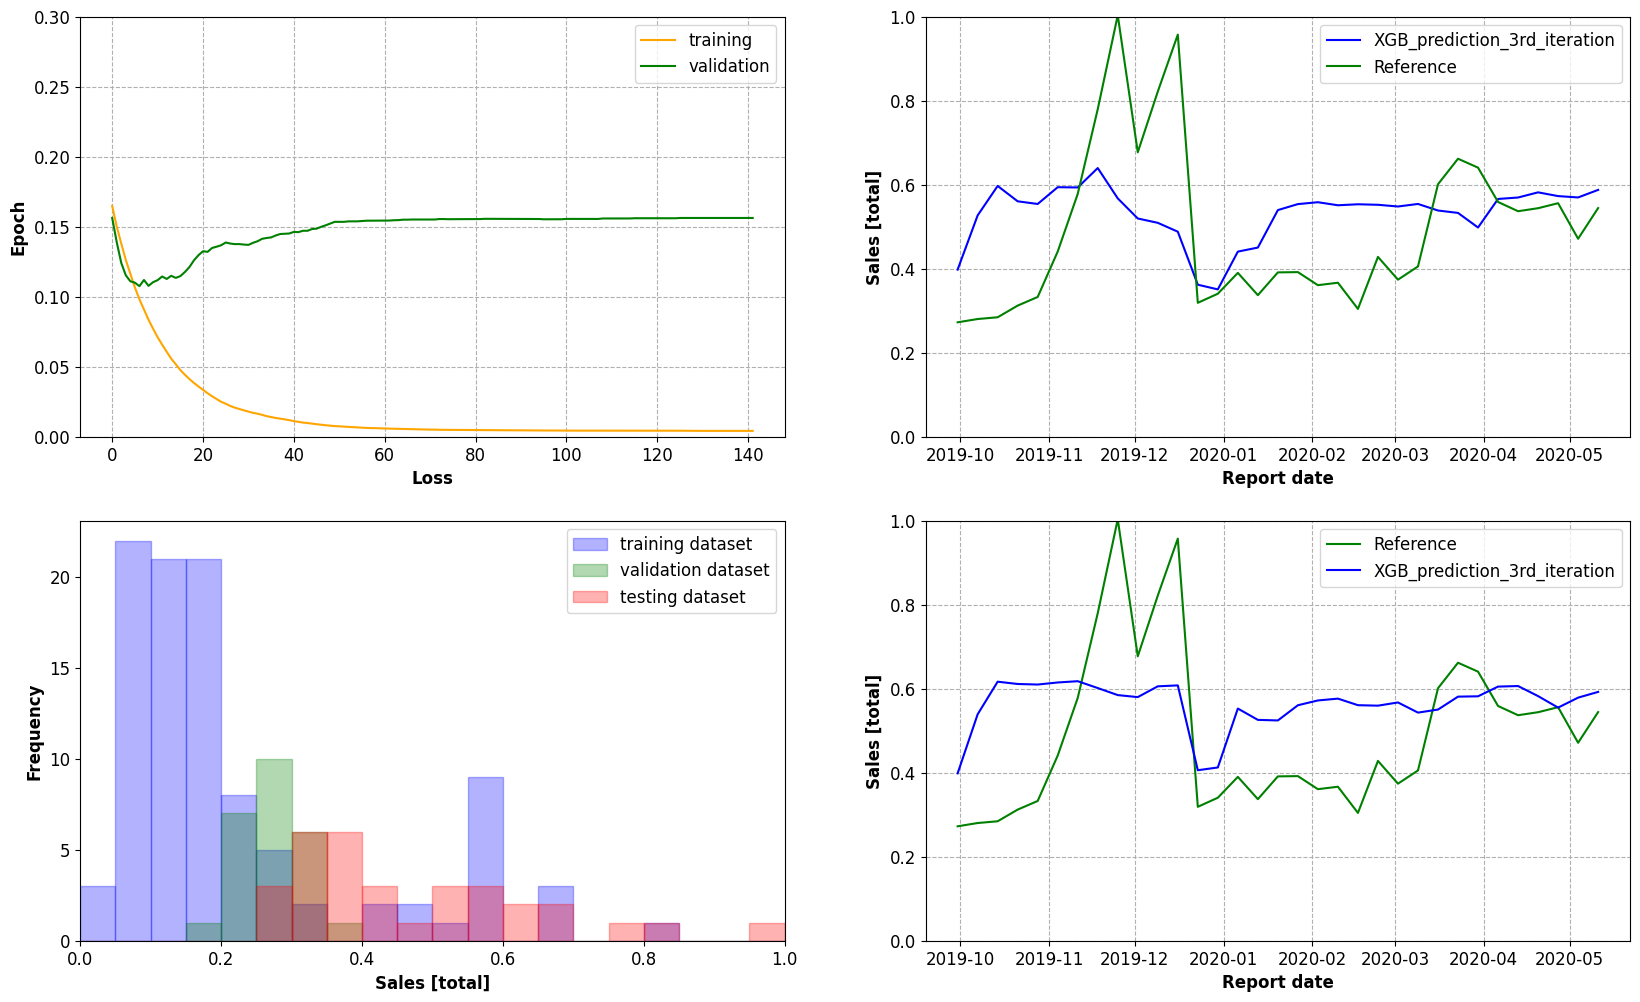

In [83]:
total_tuned_model_V3, total_training_log_tuned_V3 = xgb_model_total.single_xgb_train(
    best_param_input_total_V3
)

# Get Model Details
# print(json.loads(total_tuned_model_V3.save_config()))
# Get Feature Importance
# total_tuned_model_V3.get_score(importance_type="gain")

evaluation_plot(
    model_name=total_tuned_model_V3,
    training_log=total_training_log_tuned_V3,
    test_df=test_total,
    retailer_type_name="total",
    train_df=train_total,
    val_df=val_total_first_part,
    forecast_name="XGB_prediction_3rd_iteration",
)

evaluation_stat_total_V3 = evaluation_stat_dict(
    train_total,
    val_total,
    test_total,
    total_tuned_model_V3,
    "total",
    val_df_first_part=val_total_first_part,
)

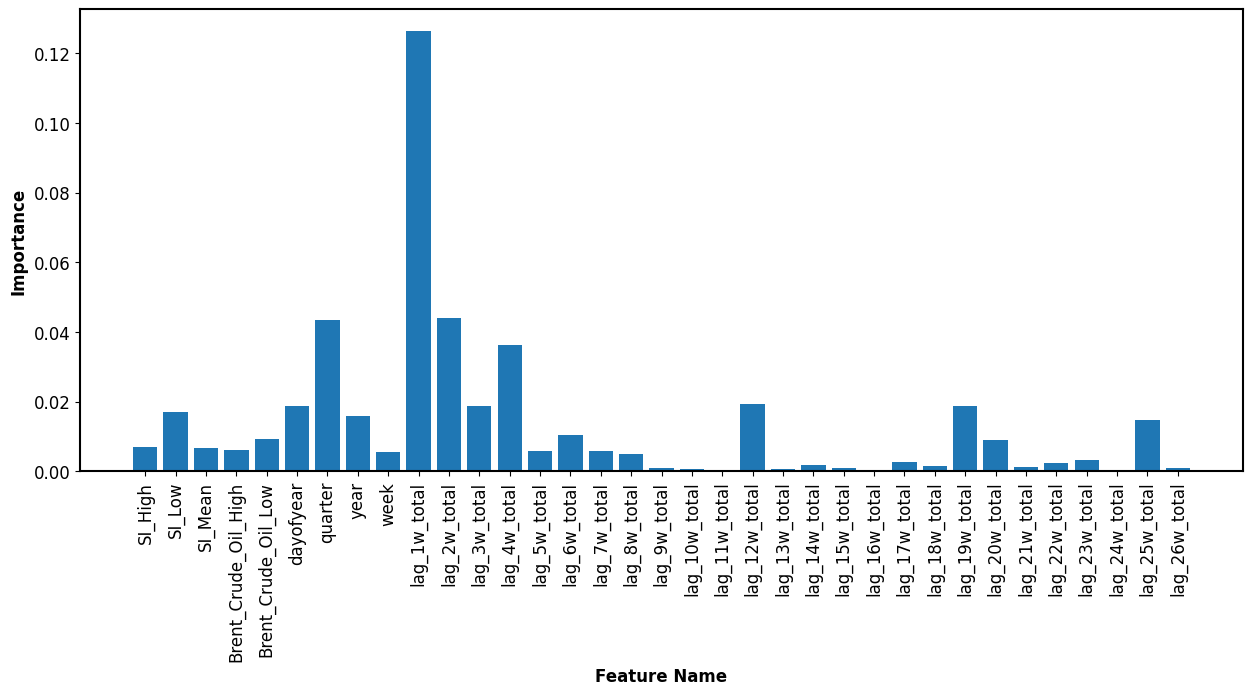

In [84]:
# Plot Feature importance
importance_plot(total_tuned_model_V3)

In [85]:
# Save the model
total_tuned_model_V3.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_Total_Experiment3_20231108_V1.json"
)

#### 6.4.3. XGBoost Model for `retialer type 1`

In [86]:
(
    train_rt1,
    val_rt1,
    test_rt1,
    val_rt1_first_part,
    xgb_model_rt1,
    best_param_input_rt1_V3,
) = model_tuning(
    input_df=df_features_ex_NoNa,
    retailer_type="retailer_type_1",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
    ex_data=[
        "SI_High",
        "SI_Low",
        "SI_Mean",
        "Brent_Crude_Oil_High",
        "Brent_Crude_Oil_Low",
    ],
)

Using default space for finetuning
100%|██████████| 500/500 [01:22<00:00,  6.09trial/s, best loss: 0.00481405093061956]


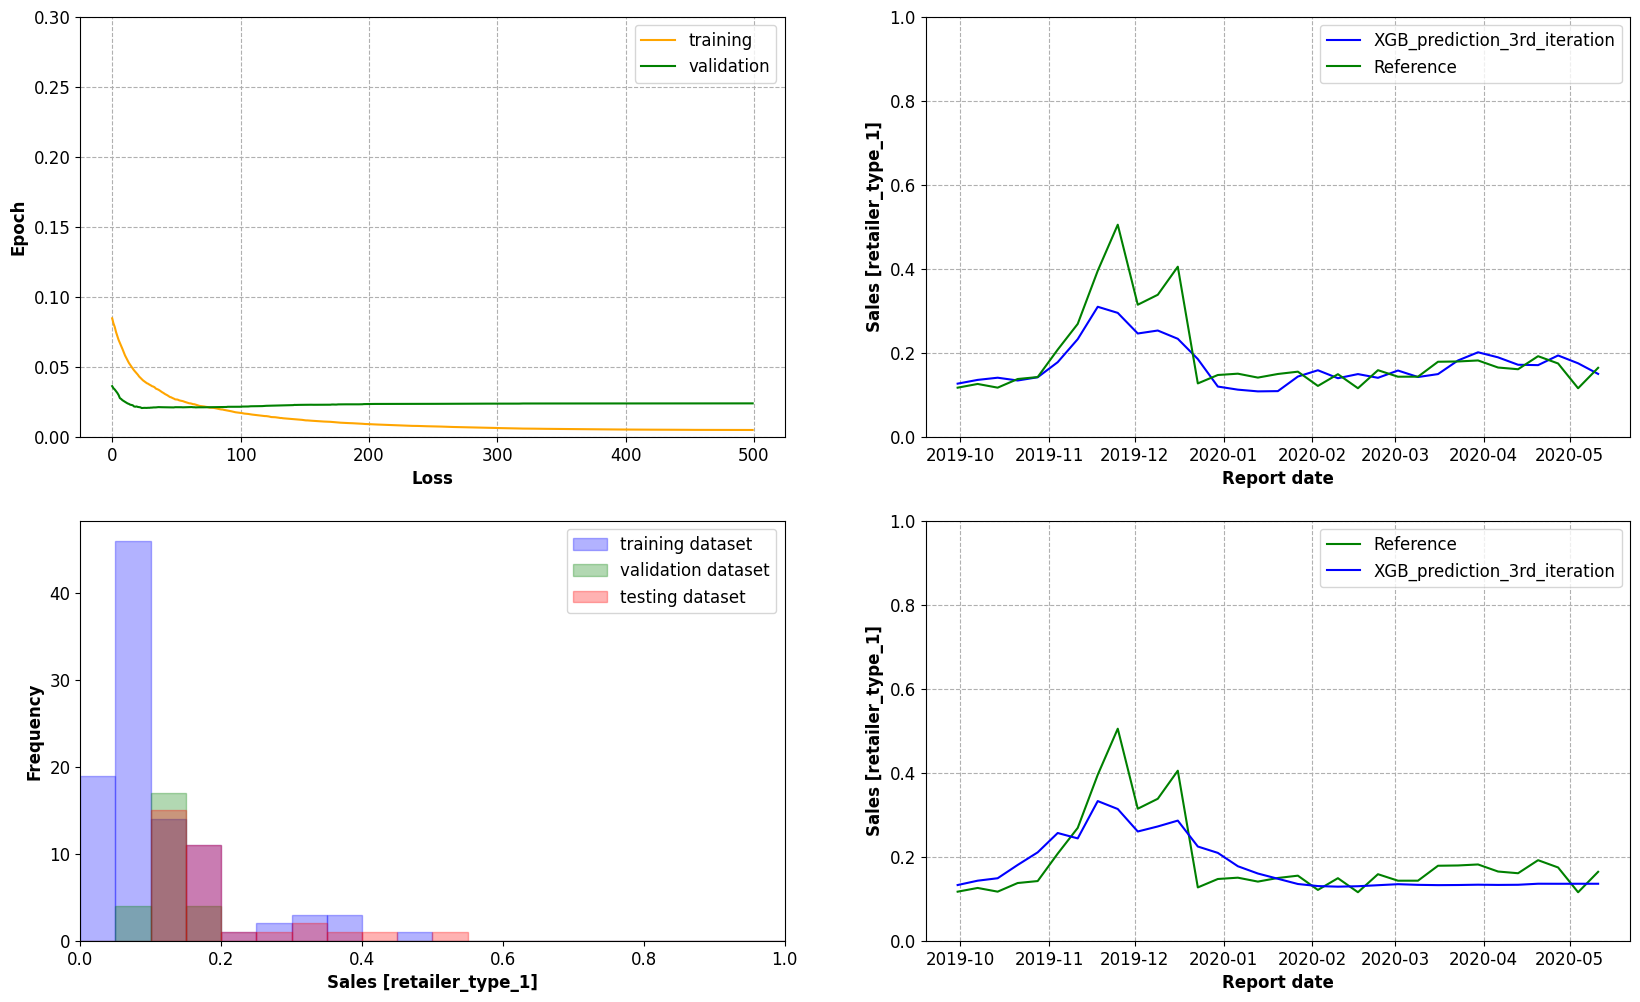

In [87]:
rt1_tuned_model_V3, rt1_training_log_tuned_V3 = xgb_model_rt1.single_xgb_train(
    best_param_input_rt1_V3
)

# Get Model Details
# print(json.loads(rt1_tuned_model_V3.save_config()))
# Get Feature Importance
# rt1_tuned_model_V3.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt1_tuned_model_V3,
    training_log=rt1_training_log_tuned_V3,
    test_df=test_rt1,
    retailer_type_name="retailer_type_1",
    train_df=train_rt1,
    val_df=val_rt1_first_part,
    forecast_name="XGB_prediction_3rd_iteration",
)

evaluation_stat_rt1_V3 = evaluation_stat_dict(
    train_rt1,
    val_rt1,
    test_rt1,
    rt1_tuned_model_V3,
    "retailer_type_1",
    val_df_first_part=val_rt1_first_part,
)

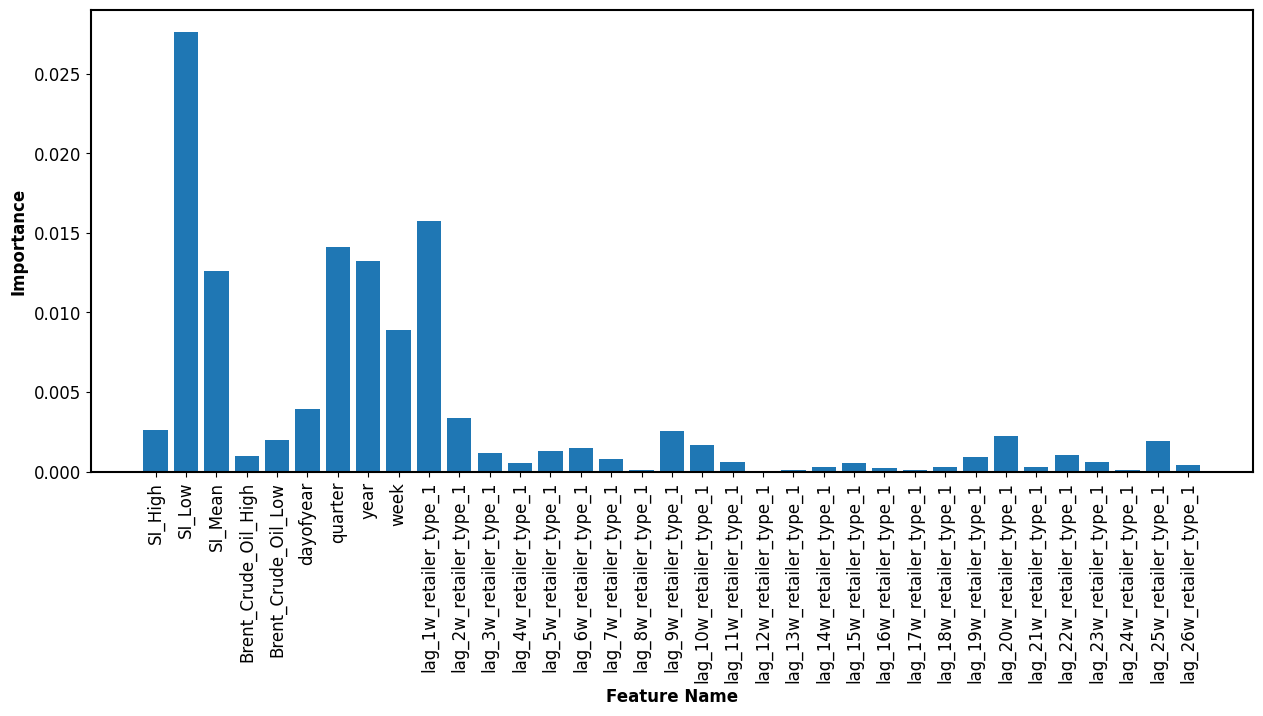

In [88]:
# Plot Feature importance
importance_plot(rt1_tuned_model_V3)

In [89]:
# Save the model
rt1_tuned_model_V3.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT1_Experiment3_20231108_V1.json"
)

#### 6.4.4. XGBoost Model for `retialer type 2`

In [90]:
(
    train_rt2,
    val_rt2,
    test_rt2,
    val_rt2_first_part,
    xgb_model_rt2,
    best_param_input_rt2_V3,
) = model_tuning(
    input_df=df_features_ex_NoNa,
    retailer_type="retailer_type_2",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
    ex_data=[
        "SI_High",
        "SI_Low",
        "SI_Mean",
        "Brent_Crude_Oil_High",
        "Brent_Crude_Oil_Low",
    ],
)

Using default space for finetuning
100%|██████████| 500/500 [00:41<00:00, 12.15trial/s, best loss: 0.00309272084596505]


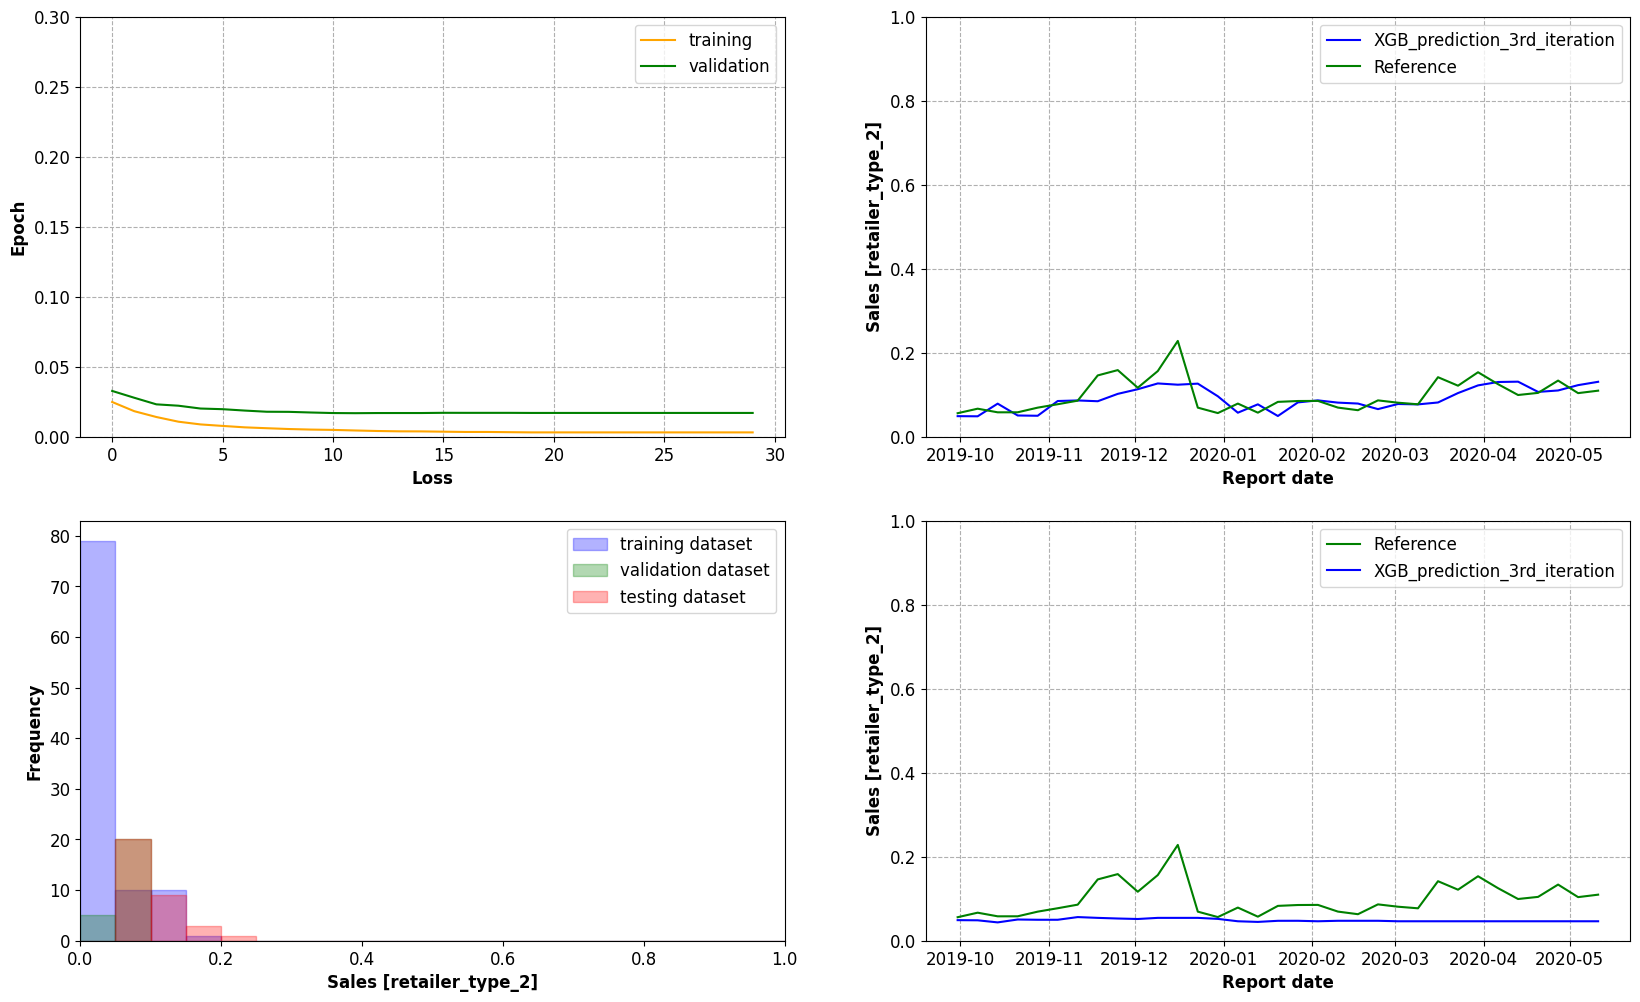

In [91]:
rt2_tuned_model_V3, rt2_training_log_tuned_V3 = xgb_model_rt2.single_xgb_train(
    best_param_input_rt2_V3
)

# Get Model Details
# print(json.loads(rt1_tuned_model_V3.save_config()))
# Get Feature Importance
# rt1_tuned_model_V3.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt2_tuned_model_V3,
    training_log=rt2_training_log_tuned_V3,
    test_df=test_rt2,
    retailer_type_name="retailer_type_2",
    train_df=train_rt2,
    val_df=val_rt2_first_part,
    forecast_name="XGB_prediction_3rd_iteration",
)

evaluation_stat_rt2_V3 = evaluation_stat_dict(
    train_rt2,
    val_rt2,
    test_rt2,
    rt2_tuned_model_V3,
    "retailer_type_2",
    val_df_first_part=val_rt2_first_part,
)

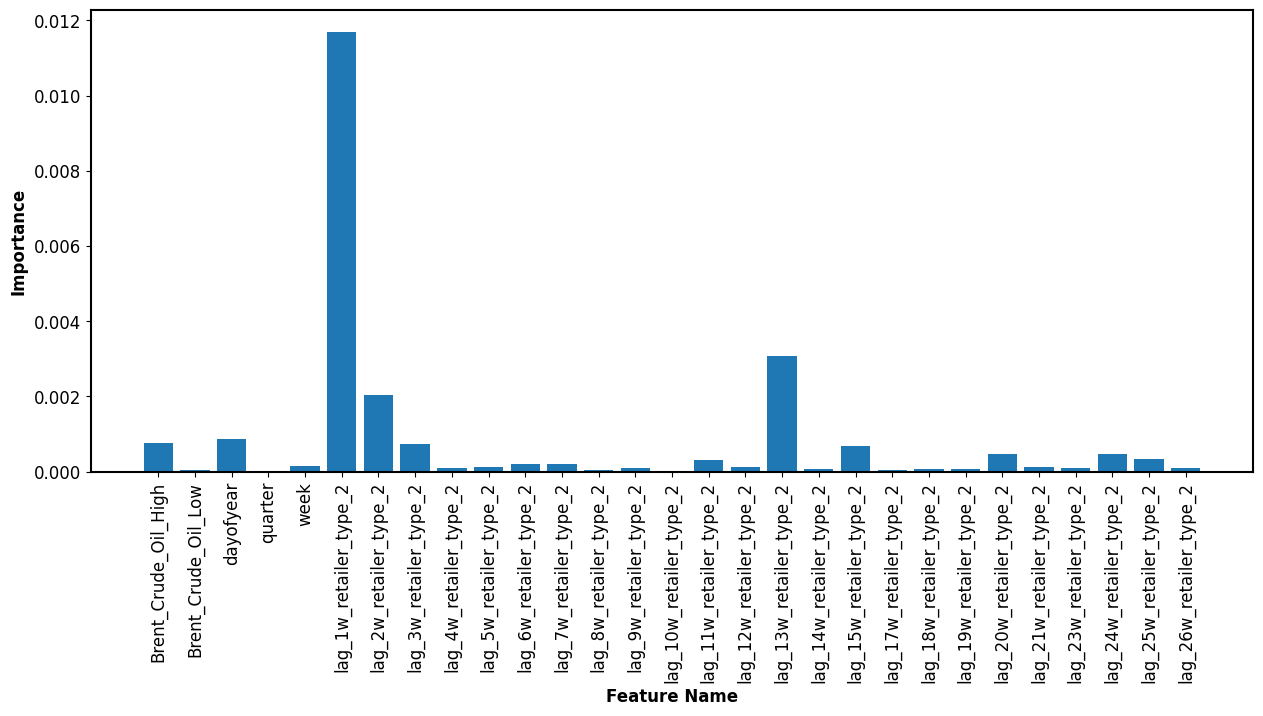

In [92]:
# Plot Feature importance
importance_plot(rt2_tuned_model_V3)

In [93]:
# Save the model
rt2_tuned_model_V3.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT2_Experiment3_20231108_V1.json"
)

#### 6.4.5. XGBoost Model for `retialer type 3`

In [94]:
(
    train_rt3,
    val_rt3,
    test_rt3,
    val_rt3_first_part,
    xgb_model_rt3,
    best_param_input_rt3_V3,
) = model_tuning(
    input_df=df_features_ex_NoNa,
    retailer_type="retailer_type_3",
    split_ratio=(0.55, 0.15, 0.2, 0.05, 0.05),
    ex_data=[
        "SI_High",
        "SI_Low",
        "SI_Mean",
        "Brent_Crude_Oil_High",
        "Brent_Crude_Oil_Low",
    ],
)

Using default space for finetuning
100%|██████████| 500/500 [01:06<00:00,  7.56trial/s, best loss: 0.00449767410630501]


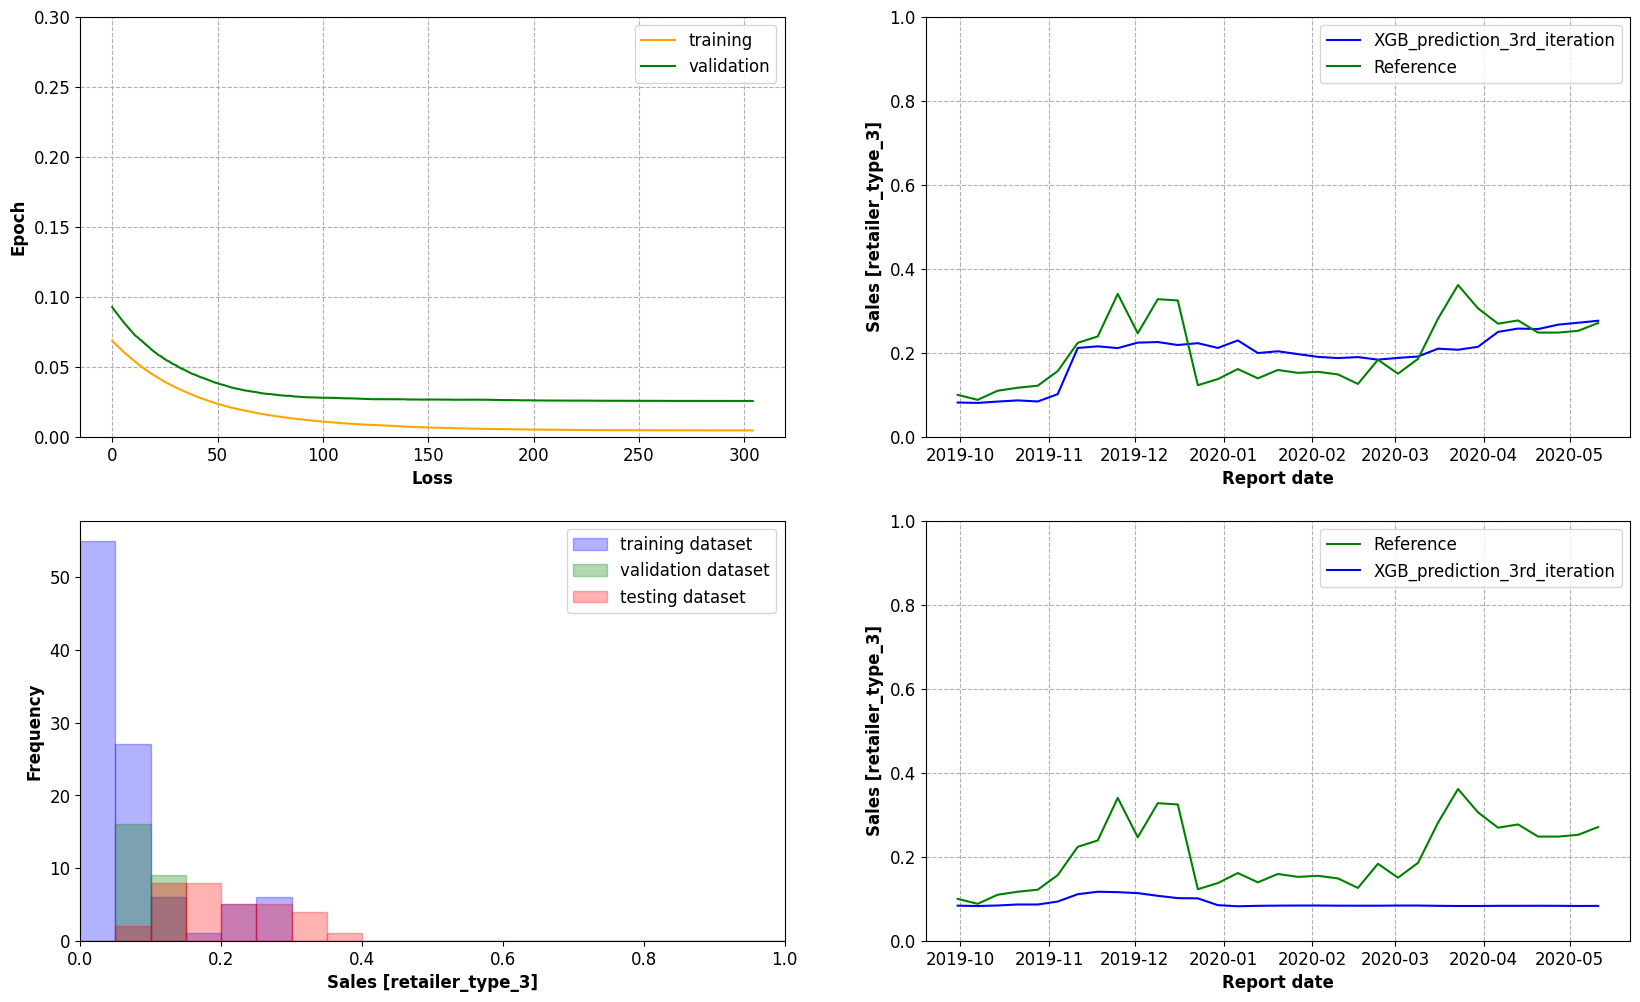

In [95]:
rt3_tuned_model_V3, rt3_training_log_tuned_V3 = xgb_model_rt3.single_xgb_train(
    best_param_input_rt3_V3
)

# Get Model Details
# print(json.loads(rt3_tuned_model_V3.save_config()))
# Get Feature Importance
# rt3_tuned_model_V3.get_score(importance_type="gain")

evaluation_plot(
    model_name=rt3_tuned_model_V3,
    training_log=rt3_training_log_tuned_V3,
    test_df=test_rt3,
    retailer_type_name="retailer_type_3",
    train_df=train_rt3,
    val_df=val_rt3_first_part,
    forecast_name="XGB_prediction_3rd_iteration",
)

evaluation_stat_rt3_V3 = evaluation_stat_dict(
    train_rt3,
    val_rt3,
    test_rt3,
    rt3_tuned_model_V3,
    "retailer_type_3",
    val_df_first_part=val_rt3_first_part,
)

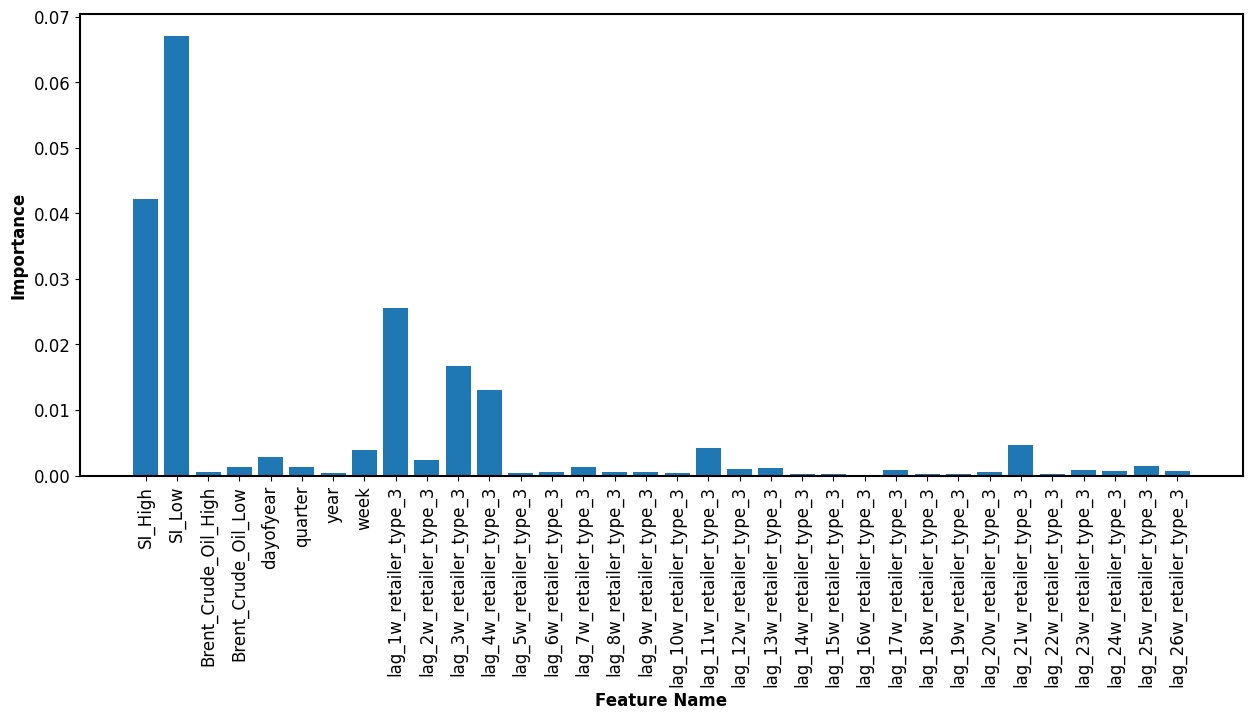

In [96]:
# Plot Feature importance
importance_plot(rt3_tuned_model_V3)

In [104]:
# Save the model
rt3_tuned_model_V3.save_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT3_Experiment3_20231108_V1.json"
)

#### 6.3.5. Summary of 3rd iteration

In [98]:
summary_df_iter_3 = pd.DataFrame(
    columns=[
        "train_RMSE",
        "val_RMSE",
        "test_RMSE",
        "forecast_RMSE",
        "train_MAE",
        "val_MAE",
        "test_MAE",
        "forecast_MAE",
        "train_R2",
        "val_R2",
        "test_R2",
        "forecast_R2",
    ],
    index=[
        "total (iter3)",
        "retailer_type_1 (iter3)",
        "retailer_type_2 (iter3)",
        "retailer_type_3 (iter3)",
    ],
)
summary_df_iter_3.iloc[0, :] = pd.DataFrame(evaluation_stat_total_V3.items())[1].values
summary_df_iter_3.iloc[1, :] = pd.DataFrame(evaluation_stat_rt1_V3.items())[1].values
summary_df_iter_3.iloc[2, :] = pd.DataFrame(evaluation_stat_rt2_V3.items())[1].values
summary_df_iter_3.iloc[3, :] = pd.DataFrame(evaluation_stat_rt3_V3.items())[1].values
summary_df_iter_3.astype("float").style.background_gradient(cmap="coolwarm")
summary_df_iter_3.to_csv(PARENT_DIR_PATH + "LOG/LOG_Experiment3_20231108_V1.csv")

## Section 7. Model Selection and Final Forecasting

In [124]:
summary_df_iter_1 = pd.read_csv(
    PARENT_DIR_PATH + "LOG/LOG_Experiment1_20231108_V1.csv", index_col=0
)
summary_df_iter_2 = pd.read_csv(
    PARENT_DIR_PATH + "LOG/LOG_Experiment2_20231108_V1.csv", index_col=0
)
summary_df_iter_3 = pd.read_csv(
    PARENT_DIR_PATH + "LOG/LOG_Experiment3_20231108_V1.csv", index_col=0
)
Overview_stat = pd.concat([summary_df_iter_1, summary_df_iter_2, summary_df_iter_3])
Overview_stat.astype("float").style.background_gradient(cmap="coolwarm")

In [125]:
lags = 26
retailer_type = "retailer_type_1"
ex_data = []
df_rt1_forecast = df_features_NoNa[
    [retailer_type]
    + ex_data
    + ["dayofyear", "dayofweek", "quarter", "year", "week"]
    + [f"lag_{lag}w_{retailer_type}" for lag in range(1, lags + 1)]
]

Best_model_rt1 = xgb.Booster()
Best_model_rt1.load_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT1_Experiment1_20231108_V1.json"
)
Best_model_rt1_forecast = recurrent_forecast(
    df_rt1_forecast.iloc[-1:, :], 12, Best_model_rt1, "retailer_type_1"
)["retailer_type_1"]

In [130]:
lags = 26
retailer_type = "retailer_type_2"
ex_data = [
    "SI_High",
    "SI_Low",
    "SI_Mean",
    "Brent_Crude_Oil_High",
    "Brent_Crude_Oil_Low",
]
df_rt2_forecast = df_features_ex_NoNa[
    [retailer_type]
    + ex_data
    + ["dayofyear", "dayofweek", "quarter", "year", "week"]
    + [f"lag_{lag}w_{retailer_type}" for lag in range(1, lags + 1)]
]

Best_model_rt2 = xgb.Booster()
Best_model_rt2.load_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT2_Experiment3_20231108_V1.json"
)
Best_model_rt2_forecast = recurrent_forecast(
    df_rt2_forecast.iloc[-1:, :], 12, Best_model_rt2, "retailer_type_2"
)["retailer_type_2"]

In [127]:
lags = 26
retailer_type = "retailer_type_3"
ex_data = [
    "SI_High",
    "SI_Low",
    "SI_Mean",
    "Brent_Crude_Oil_High",
    "Brent_Crude_Oil_Low",
]
df_rt3_forecast = df_features_ex_NoNa[
    [retailer_type]
    + ex_data
    + ["dayofyear", "dayofweek", "quarter", "year", "week"]
    + [f"lag_{lag}w_{retailer_type}" for lag in range(1, lags + 1)]
]

Best_model_rt3 = xgb.Booster()
Best_model_rt3.load_model(
    PARENT_DIR_PATH + "MODEL/XGB_RT3_Experiment3_20231108_V1.json"
)
Best_model_rt3_forecast = recurrent_forecast(
    df_rt3_forecast.iloc[-1:, :], 12, Best_model_rt3, "retailer_type_3"
)["retailer_type_3"]

In [128]:
Best_model_total_forecast = pd.DataFrame(
    Best_model_rt1_forecast + Best_model_rt2_forecast + Best_model_rt3_forecast
)
Best_model_total_forecast.columns = ["total"]

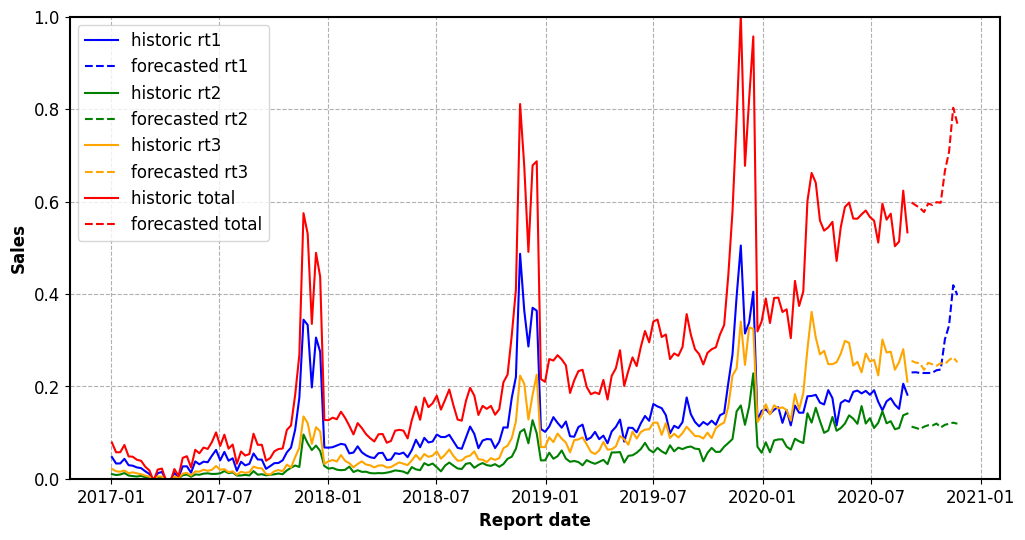

In [131]:
fig, ax = plt.subplots(figsize=(12, 6))

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

plt.plot(df_raw["retailer_type_1"], label="historic rt1", color="blue")
plt.plot(Best_model_rt1_forecast, label="forecasted rt1", linestyle="--", color="blue")

plt.plot(df_raw["retailer_type_2"], label="historic rt2", color="green")
plt.plot(Best_model_rt2_forecast, label="forecasted rt2", linestyle="--", color="green")

plt.plot(df_raw["retailer_type_3"], label="historic rt3", color="orange")
plt.plot(
    Best_model_rt3_forecast, label="forecasted rt3", linestyle="--", color="orange"
)

plt.plot(df_raw["total"], label="historic total", color="red")
plt.plot(
    Best_model_total_forecast, label="forecasted total", linestyle="--", color="red"
)

plt.xlabel("Report date", fontsize=12, fontweight="bold")
plt.ylabel("Sales", fontsize=12, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle="--")

plt.ylim(0, 1)

plt.legend(loc="upper left", fontsize=12)

plt.show()

In [123]:
output_csv = pd.concat(
    [
        Best_model_total_forecast,
        Best_model_rt1_forecast,
        Best_model_rt2_forecast,
        Best_model_rt3_forecast,
    ],
    axis=1,
)

output_csv

total  retailer_type_1  retailer_type_2  retailer_type_3
2020-09-07  0.557855         0.183681         0.119005         0.255168
2020-09-14  0.551949         0.183025         0.117696         0.251228
2020-09-21  0.553037         0.183025         0.119830         0.250181
2020-09-28  0.541075         0.183025         0.122223         0.235827
2020-10-05  0.554414         0.182032         0.121436         0.250946
2020-10-12  0.548713         0.182032         0.119044         0.247638
2020-10-19  0.556580         0.192314         0.119830         0.244436
2020-10-26  0.560832         0.192314         0.118482         0.250036
2020-11-02  0.631429         0.261377         0.122223         0.247829
2020-11-09  0.669603         0.295096         0.117696         0.256811
2020-11-16  0.741327         0.356280         0.122223         0.262824
2020-11-23  0.718596         0.348786         0.117696         0.252114

In [120]:
output_csv.to_csv(PARENT_DIR_PATH + "RESULT/FORECAST_RSULT_20231108_V1.csv")

> Format the Jupyter Notebook

In [ ]:
# formate the code
!pip install black

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!black /content/drive/MyDrive/Colab\ Notebooks/20231108_Data-Science-Assignment_HZ-for-BOL_V3.ipynb